In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from scipy import misc
import numpy as np
import glob
import matplotlib.pyplot as plt
from network import Network
from circle_generator import Circles
from dataset import SegmentationDataset
from loss import SegmentationLoss, ImageLoss
from unet import Unet

### Train on HeLa dataset

In [2]:
def train(num_epochs, batch_size, num_workers):
    transformed_dataset = SegmentationDataset(path_to_images='./datasets/HeLa/01/',
                                              path_to_segm='./datasets/HeLa/01_GT/SEG/', 
                                              transform=transforms.Compose([
                                                  ToTensor(), 
                                                  Normalize()
                                              ]))
    dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=num_workers)
    
    net = network()
    segm_loss = SegmentationLoss()
    img_loss = ImageLoss()
    z_input = Variable(torch.randn(84, 1, 512, 512), requires_grad=True)
    optimizer = optim.Adam([z_input] + list(net.parameters()), lr=0.1)
    
    for epoch in range(num_epochs):
        
        for data in dataloader:
            gt_img = Variable(data['image'])
            idx = data['idx']
            
            optimizer.zero_grad()
            img, segm = net(z_input[idx])
            loss = img_loss(img, gt_img)
            loss.backward()
            optimizer.step()
        

In [ ]:
train(1, 2, 1)

### circles example

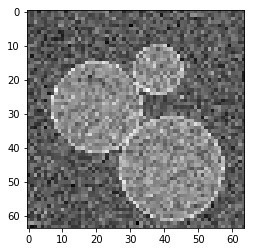

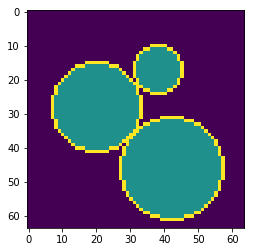

In [2]:
predata = Circles(radius=12, bg_color=0, perim_color=0.2, circle_color=0.1,
                  size=(64, 64), n_obj=5, var_n_obj=1, var_size=5, maxover=0)
x, y = predata.get_train_batch(1)
plt.imshow(x[0, 0],cmap='gray')
plt.figure()
plt.imshow(y[0])
plt.show()

## Training circles

In [3]:
def show_image_segm(gen_img, gen_segm, real_img, real_segm):
    for i, image in enumerate(gen_img):
        f, axarr = plt.subplots(2, 2, figsize=(10, 10))
        axarr[0, 0].imshow(image[0], cmap='gray')
        axarr[0, 0].set_title('Gen image')
        axarr[0, 1].imshow(real_img[i][0], cmap='gray')
        axarr[0, 1].set_title('Real image')
        axarr[1, 0].imshow(np.argmax(gen_segm[i], 0))
        axarr[1, 0].set_title('Gen segmentation')
        axarr[1, 1].imshow(real_segm[i])
        axarr[1, 1].set_title('Real segmentation')
    plt.show()

### Generate train batch

In [4]:
batch_size = 40

In [5]:
np.random.seed(42)
train_images, train_segmentation = predata.get_train_batch(batch_size)

In [6]:
train_images = Variable(torch.from_numpy(train_images).float().cuda(), requires_grad=False)
train_segmentation = Variable(torch.from_numpy(train_segmentation).cuda(), requires_grad=False)

In [7]:
net = Network(num_z_channels=3, num_classes=3).cuda()
segm_loss = SegmentationLoss()
img_loss = ImageLoss()

### create latent variable

In [8]:
torch.manual_seed(42)
z_input = Variable(torch.randn(batch_size, 3, 64, 64).cuda(), requires_grad=True)

### Training

In [9]:
def normalize_z(z):
    norm_z = z.data.norm(dim=1, p=2)
    norm_z = norm_z.unsqueeze(dim=1)
    norm_z = norm_z.repeat(1, 3, 1, 1)
    norm_z.clamp_(min=1.0)
    z.data = z.data / norm_z

In [10]:
without_segmentation = 1

In [11]:
def plot_segmentation(segm, gt_segm, num_epoch):
    segm_numpy = segm.data.cpu().numpy()
    gt_segm_numpy = gt_segm.data.cpu().numpy()
    for i, image in enumerate(segm_numpy):
        f, axarr = plt.subplots(1, 2, figsize=(10, 5))
        axarr[0].imshow(np.argmax(image, 0))
        axarr[0].set_title('Gen segmentation, epoch = {}'.format(num_epoch))
        axarr[1].imshow(gt_segm_numpy[i])
        axarr[1].set_title('Real segmentation')
    plt.show()

In [14]:
def train(net, train_images, train_segmentation, z_input, segm_loss, img_loss, without_segmentation):
    optimizer = optim.Adam([z_input] + list(net.parameters()), lr=0.005)

    loss_epoch = []
    num_epochs = 10000
    print_history = 50
    segmentation_loss = []

    for epoch in range(num_epochs):
        normalize_z(z_input)
        optimizer.zero_grad()   
        img, segm = net(z_input)

        if epoch % print_history == 0:
            plot_segmentation(segm[-1:], 
                              train_segmentation[-1:], 
                              epoch)

        loss = segm_loss(segm[:-without_segmentation], 
                         train_segmentation[:-without_segmentation]) + 1000 * img_loss(img, train_images)
        loss_epoch.append(loss.data)
        segmentation_loss.append(segm_loss(segm[-10:],
                                           train_segmentation[-10:]).data[0])

        loss.backward()
        optimizer.step()
        #print('epoch - {}, loss - {}'.format(epoch, loss.data.cpu().numpy()[0]))

    normalize_z(z_input)
    return loss_epoch, segmentation_loss

In [15]:
def generate_and_train(network_class):
    batch_size = 25
    tr_images, tr_segmentation = predata.get_train_batch(batch_size)
    train_images = Variable(torch.from_numpy(tr_images).float().cuda(), requires_grad=False)
    train_segmentation = Variable(torch.from_numpy(tr_segmentation).cuda(), requires_grad=False)
    net = network_class(num_z_channels=3, num_classes=3).cuda()
    segm_loss = SegmentationLoss()
    img_loss = ImageLoss()
    z_input = Variable(torch.randn(batch_size, 3, 64, 64).cuda(), requires_grad=True)
    loss_10, segm_loss_10 = train(net=net, z_input=z_input, segm_loss=segm_loss, 
                                  img_loss=img_loss, without_segmentation=10, 
                                  train_images=train_images, 
                                  train_segmentation=train_segmentation)
    
    batch_size = 115
    additional_tr_images, additional_tr_segmentation = predata.get_train_batch(90)
    tr_images = np.concatenate((tr_images[:15], additional_tr_images, tr_images[15:]), axis=0)
    tr_segmentation = np.concatenate((tr_segmentation[:15], additional_tr_segmentation, 
                                      tr_segmentation[15:]), axis=0)
    
    train_images = Variable(torch.from_numpy(tr_images).float().cuda(), requires_grad=False)
    train_segmentation = Variable(torch.from_numpy(tr_segmentation).cuda(), requires_grad=False)
    net = network_class(num_z_channels=3, num_classes=3).cuda()
    z_input = Variable(torch.randn(batch_size, 3, 64, 64).cuda(), requires_grad=True)
    loss_100, segm_loss_100 = train(net=net, z_input=z_input, segm_loss=segm_loss, 
                                    img_loss=img_loss, without_segmentation=100, 
                                    train_images=train_images, 
                                    train_segmentation=train_segmentation)
    return loss_10, loss_100, segm_loss_10, segm_loss_100

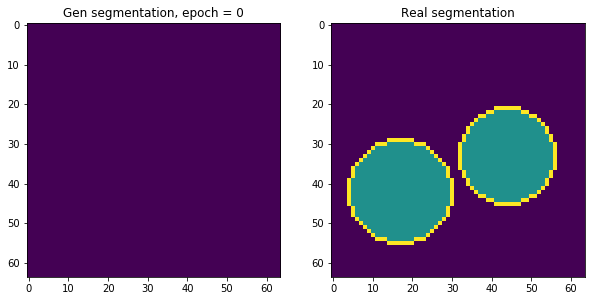

epoch - 0, loss - 6.87568235397
epoch - 1, loss - 25.7822437286
epoch - 2, loss - 6.98602199554
epoch - 3, loss - 6.5875377655
epoch - 4, loss - 6.82738780975
epoch - 5, loss - 6.72454118729
epoch - 6, loss - 6.50114059448
epoch - 7, loss - 6.52453804016
epoch - 8, loss - 6.49144649506
epoch - 9, loss - 6.37174272537
epoch - 10, loss - 6.35305595398
epoch - 11, loss - 6.34811544418
epoch - 12, loss - 6.27602338791
epoch - 13, loss - 6.18825626373
epoch - 14, loss - 6.1472902298
epoch - 15, loss - 6.0965795517
epoch - 16, loss - 6.08230638504
epoch - 17, loss - 6.11773729324
epoch - 18, loss - 6.08475732803
epoch - 19, loss - 6.08843231201
epoch - 20, loss - 6.03314113617
epoch - 21, loss - 6.01691770554
epoch - 22, loss - 5.99313020706
epoch - 23, loss - 5.98035430908
epoch - 24, loss - 5.97777700424
epoch - 25, loss - 5.96085786819
epoch - 26, loss - 5.96279716492
epoch - 27, loss - 5.94690084457
epoch - 28, loss - 5.93834114075
epoch - 29, loss - 5.92445850372
epoch - 30, loss - 5.90

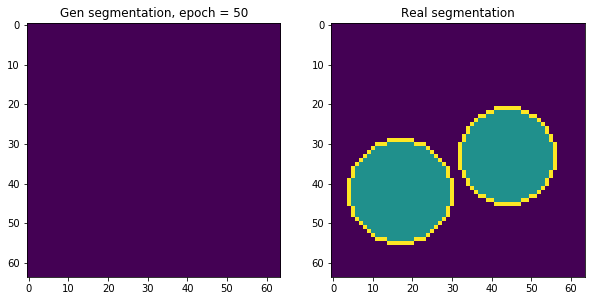

epoch - 50, loss - 5.81185770035
epoch - 51, loss - 5.79588460922
epoch - 52, loss - 5.76626396179
epoch - 53, loss - 5.78229188919
epoch - 54, loss - 5.75484132767
epoch - 55, loss - 5.74164247513
epoch - 56, loss - 5.74826002121
epoch - 57, loss - 5.71857976913
epoch - 58, loss - 5.72093963623
epoch - 59, loss - 5.69866132736
epoch - 60, loss - 5.69167661667
epoch - 61, loss - 5.66352319717
epoch - 62, loss - 5.66678476334
epoch - 63, loss - 5.64009952545
epoch - 64, loss - 5.62743377686
epoch - 65, loss - 5.6313867569
epoch - 66, loss - 5.66589355469
epoch - 67, loss - 5.84383583069
epoch - 68, loss - 5.80612897873
epoch - 69, loss - 5.58443164825
epoch - 70, loss - 5.63225078583
epoch - 71, loss - 5.62364292145
epoch - 72, loss - 5.54233217239
epoch - 73, loss - 5.60291194916
epoch - 74, loss - 5.50884246826
epoch - 75, loss - 5.56543159485
epoch - 76, loss - 5.48822975159
epoch - 77, loss - 5.50271701813
epoch - 78, loss - 5.47101449966
epoch - 79, loss - 5.42650032043
epoch - 80,

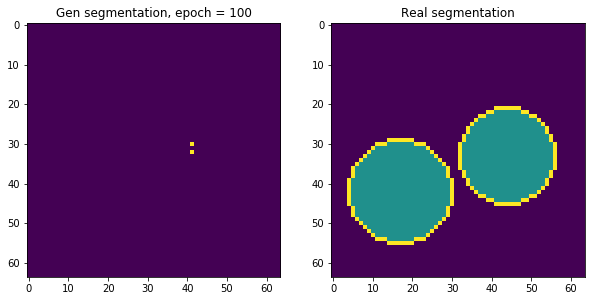

epoch - 100, loss - 5.08009004593
epoch - 101, loss - 5.05301141739
epoch - 102, loss - 5.08703136444
epoch - 103, loss - 4.89790439606
epoch - 104, loss - 4.85521459579
epoch - 105, loss - 4.84901046753
epoch - 106, loss - 4.66896009445
epoch - 107, loss - 4.72148513794
epoch - 108, loss - 4.56341648102
epoch - 109, loss - 4.60887432098
epoch - 110, loss - 4.48093509674
epoch - 111, loss - 4.50795173645
epoch - 112, loss - 4.39460897446
epoch - 113, loss - 4.39844322205
epoch - 114, loss - 4.32314586639
epoch - 115, loss - 4.28292131424
epoch - 116, loss - 4.2309885025
epoch - 117, loss - 4.17110967636
epoch - 118, loss - 4.14663028717
epoch - 119, loss - 4.07511997223
epoch - 120, loss - 4.08204889297
epoch - 121, loss - 3.99475693703
epoch - 122, loss - 3.97579836845
epoch - 123, loss - 3.93486666679
epoch - 124, loss - 3.8810801506
epoch - 125, loss - 3.87542080879
epoch - 126, loss - 3.81819963455
epoch - 127, loss - 3.80347371101
epoch - 128, loss - 3.79867959023
epoch - 129, los

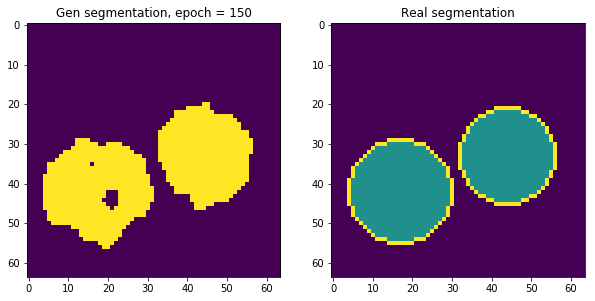

epoch - 150, loss - 3.42207479477
epoch - 151, loss - 3.41395449638
epoch - 152, loss - 3.4026222229
epoch - 153, loss - 3.38920903206
epoch - 154, loss - 3.37703156471
epoch - 155, loss - 3.36672282219
epoch - 156, loss - 3.35834550858
epoch - 157, loss - 3.35103440285
epoch - 158, loss - 3.34410238266
epoch - 159, loss - 3.33835840225
epoch - 160, loss - 3.33218693733
epoch - 161, loss - 3.32597303391
epoch - 162, loss - 3.31682515144
epoch - 163, loss - 3.30544161797
epoch - 164, loss - 3.29060959816
epoch - 165, loss - 3.27579951286
epoch - 166, loss - 3.26386499405
epoch - 167, loss - 3.25571870804
epoch - 168, loss - 3.25013399124
epoch - 169, loss - 3.24675178528
epoch - 170, loss - 3.24810266495
epoch - 171, loss - 3.25190925598
epoch - 172, loss - 3.25466275215
epoch - 173, loss - 3.24620270729
epoch - 174, loss - 3.22104501724
epoch - 175, loss - 3.18876338005
epoch - 176, loss - 3.17277193069
epoch - 177, loss - 3.17443346977
epoch - 178, loss - 3.1759531498
epoch - 179, los

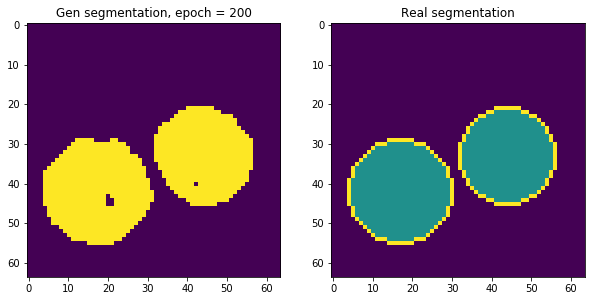

epoch - 200, loss - 2.95093035698
epoch - 201, loss - 2.94523692131
epoch - 202, loss - 2.93693757057
epoch - 203, loss - 2.92161417007
epoch - 204, loss - 2.9107375145
epoch - 205, loss - 2.89946722984
epoch - 206, loss - 2.89061808586
epoch - 207, loss - 2.88389611244
epoch - 208, loss - 2.87450408936
epoch - 209, loss - 2.86540174484
epoch - 210, loss - 2.8559691906
epoch - 211, loss - 2.84696054459
epoch - 212, loss - 2.84025120735
epoch - 213, loss - 2.83503913879
epoch - 214, loss - 2.83684659004
epoch - 215, loss - 2.85127973557
epoch - 216, loss - 2.87018537521
epoch - 217, loss - 2.87455701828
epoch - 218, loss - 2.86123847961
epoch - 219, loss - 2.80399012566
epoch - 220, loss - 2.76353335381
epoch - 221, loss - 2.77022027969
epoch - 222, loss - 2.78903365135
epoch - 223, loss - 2.78136014938
epoch - 224, loss - 2.7411043644
epoch - 225, loss - 2.72124838829
epoch - 226, loss - 2.73225331306
epoch - 227, loss - 2.73337554932
epoch - 228, loss - 2.71810722351
epoch - 229, loss

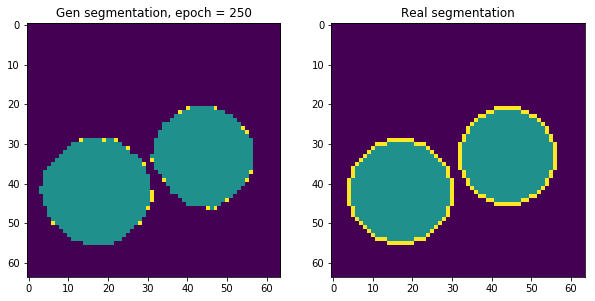

epoch - 250, loss - 2.58002948761
epoch - 251, loss - 2.53067803383
epoch - 252, loss - 2.59734988213
epoch - 253, loss - 2.55366849899
epoch - 254, loss - 2.49771881104
epoch - 255, loss - 2.53118920326
epoch - 256, loss - 2.53232717514
epoch - 257, loss - 2.4707660675
epoch - 258, loss - 2.48641514778
epoch - 259, loss - 2.49974250793
epoch - 260, loss - 2.48600888252
epoch - 261, loss - 2.43808317184
epoch - 262, loss - 2.46655321121
epoch - 263, loss - 2.47527766228
epoch - 264, loss - 2.42983579636
epoch - 265, loss - 2.41936731339
epoch - 266, loss - 2.43846726418
epoch - 267, loss - 2.42812228203
epoch - 268, loss - 2.38583946228
epoch - 269, loss - 2.38961744308
epoch - 270, loss - 2.39733743668
epoch - 271, loss - 2.39497280121
epoch - 272, loss - 2.35882043839
epoch - 273, loss - 2.353941679
epoch - 274, loss - 2.35088300705
epoch - 275, loss - 2.35622835159
epoch - 276, loss - 2.33701467514
epoch - 277, loss - 2.32122039795
epoch - 278, loss - 2.30641961098
epoch - 279, loss

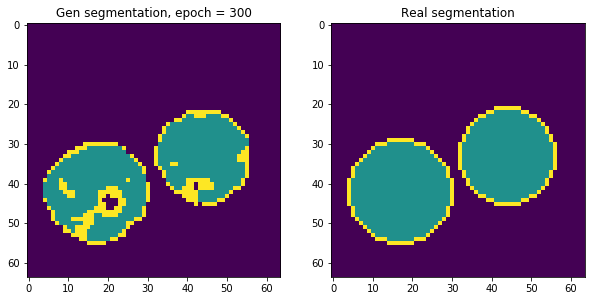

epoch - 300, loss - 2.44395446777
epoch - 301, loss - 2.50308299065
epoch - 302, loss - 2.45627689362
epoch - 303, loss - 2.1369035244
epoch - 304, loss - 2.26155686378
epoch - 305, loss - 2.43915891647
epoch - 306, loss - 2.12979221344
epoch - 307, loss - 2.27949213982
epoch - 308, loss - 2.31469106674
epoch - 309, loss - 2.11585068703
epoch - 310, loss - 2.32693576813
epoch - 311, loss - 2.1407418251
epoch - 312, loss - 2.16426420212
epoch - 313, loss - 2.19714975357
epoch - 314, loss - 2.06661534309
epoch - 315, loss - 2.14529585838
epoch - 316, loss - 2.07071638107
epoch - 317, loss - 2.08565473557
epoch - 318, loss - 2.08173370361
epoch - 319, loss - 2.0309574604
epoch - 320, loss - 2.07166051865
epoch - 321, loss - 2.02180600166
epoch - 322, loss - 2.02065253258
epoch - 323, loss - 2.02992463112
epoch - 324, loss - 1.98084580898
epoch - 325, loss - 1.99500870705
epoch - 326, loss - 1.97518730164
epoch - 327, loss - 1.96000230312
epoch - 328, loss - 1.9660513401
epoch - 329, loss 

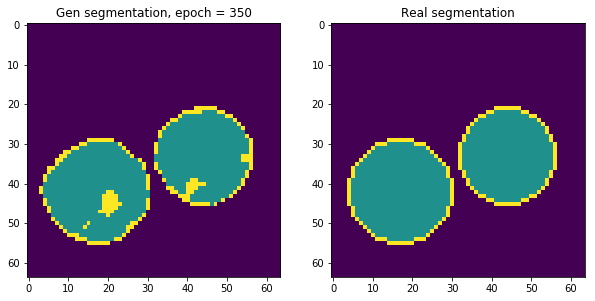

epoch - 350, loss - 1.77911949158
epoch - 351, loss - 1.7631649971
epoch - 352, loss - 1.75495052338
epoch - 353, loss - 1.75294089317
epoch - 354, loss - 1.74243247509
epoch - 355, loss - 1.73329913616
epoch - 356, loss - 1.72459304333
epoch - 357, loss - 1.71406805515
epoch - 358, loss - 1.70640420914
epoch - 359, loss - 1.70169019699
epoch - 360, loss - 1.68890452385
epoch - 361, loss - 1.69298839569
epoch - 362, loss - 1.69111394882
epoch - 363, loss - 1.68581557274
epoch - 364, loss - 1.68328917027
epoch - 365, loss - 1.67541348934
epoch - 366, loss - 1.68769717216
epoch - 367, loss - 1.67692160606
epoch - 368, loss - 1.67967939377
epoch - 369, loss - 1.64334881306
epoch - 370, loss - 1.62834966183
epoch - 371, loss - 1.61193907261
epoch - 372, loss - 1.60479390621
epoch - 373, loss - 1.59199500084
epoch - 374, loss - 1.59271538258
epoch - 375, loss - 1.58436882496
epoch - 376, loss - 1.5939437151
epoch - 377, loss - 1.60321748257
epoch - 378, loss - 1.60235416889
epoch - 379, los

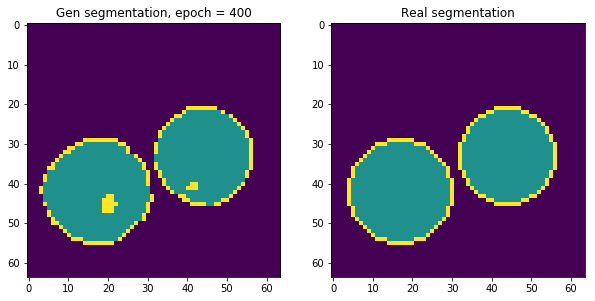

epoch - 400, loss - 1.46090400219
epoch - 401, loss - 1.472245574
epoch - 402, loss - 1.4492919445
epoch - 403, loss - 1.43631827831
epoch - 404, loss - 1.38482177258
epoch - 405, loss - 1.3734190464
epoch - 406, loss - 1.36629271507
epoch - 407, loss - 1.38587832451
epoch - 408, loss - 1.39280998707
epoch - 409, loss - 1.37804949284
epoch - 410, loss - 1.35903847218
epoch - 411, loss - 1.33199489117
epoch - 412, loss - 1.31234955788
epoch - 413, loss - 1.31298243999
epoch - 414, loss - 1.31673073769
epoch - 415, loss - 1.33295857906
epoch - 416, loss - 1.32035934925
epoch - 417, loss - 1.31338202953
epoch - 418, loss - 1.29479777813
epoch - 419, loss - 1.27206802368
epoch - 420, loss - 1.26021659374
epoch - 421, loss - 1.24344241619
epoch - 422, loss - 1.23968732357
epoch - 423, loss - 1.2363781929
epoch - 424, loss - 1.23847329617
epoch - 425, loss - 1.23665130138
epoch - 426, loss - 1.25241529942
epoch - 427, loss - 1.24983620644
epoch - 428, loss - 1.27047431469
epoch - 429, loss -

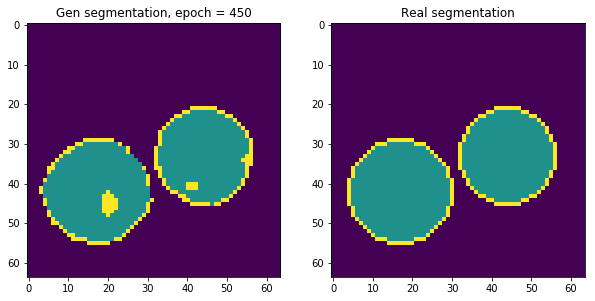

epoch - 450, loss - 1.06114637852
epoch - 451, loss - 1.06748640537
epoch - 452, loss - 1.06183028221
epoch - 453, loss - 1.06966662407
epoch - 454, loss - 1.06660044193
epoch - 455, loss - 1.08011436462
epoch - 456, loss - 1.06913840771
epoch - 457, loss - 1.09304106236
epoch - 458, loss - 1.06099998951
epoch - 459, loss - 1.0484650135
epoch - 460, loss - 1.01325547695
epoch - 461, loss - 0.996945381165
epoch - 462, loss - 0.988205432892
epoch - 463, loss - 1.01220142841
epoch - 464, loss - 1.03304743767
epoch - 465, loss - 1.00525617599
epoch - 466, loss - 1.05299723148
epoch - 467, loss - 0.986516952515
epoch - 468, loss - 0.98062723875
epoch - 469, loss - 0.963476538658
epoch - 470, loss - 0.945648133755
epoch - 471, loss - 0.959655344486
epoch - 472, loss - 0.946889519691
epoch - 473, loss - 0.949955642223
epoch - 474, loss - 0.95800024271
epoch - 475, loss - 0.962448120117
epoch - 476, loss - 0.954933106899
epoch - 477, loss - 0.955101847649
epoch - 478, loss - 0.912094116211
epo

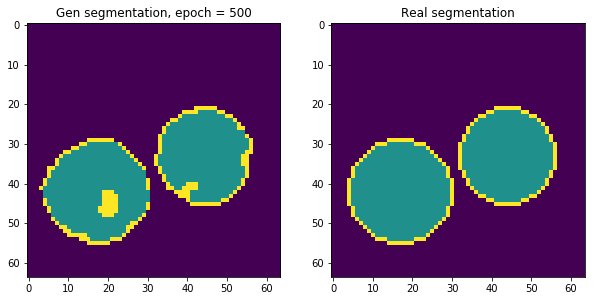

epoch - 500, loss - 0.805260956287
epoch - 501, loss - 0.839851081371
epoch - 502, loss - 0.823525726795
epoch - 503, loss - 0.823781728745
epoch - 504, loss - 0.781320989132
epoch - 505, loss - 0.796856403351
epoch - 506, loss - 0.749389052391
epoch - 507, loss - 0.766534388065
epoch - 508, loss - 0.738423883915
epoch - 509, loss - 0.753915727139
epoch - 510, loss - 0.728254318237
epoch - 511, loss - 0.736579120159
epoch - 512, loss - 0.718185305595
epoch - 513, loss - 0.718609035015
epoch - 514, loss - 0.711645126343
epoch - 515, loss - 0.704325199127
epoch - 516, loss - 0.702524185181
epoch - 517, loss - 0.696077406406
epoch - 518, loss - 0.70183712244
epoch - 519, loss - 0.699158787727
epoch - 520, loss - 0.721197903156
epoch - 521, loss - 0.74084764719
epoch - 522, loss - 0.804378032684
epoch - 523, loss - 0.791269421577
epoch - 524, loss - 0.791253566742
epoch - 525, loss - 0.700338125229
epoch - 526, loss - 0.655200779438
epoch - 527, loss - 0.662586092949
epoch - 528, loss - 0.

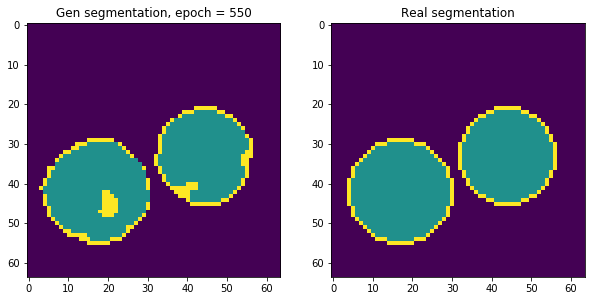

epoch - 550, loss - 0.562428176403
epoch - 551, loss - 0.549739480019
epoch - 552, loss - 0.541417181492
epoch - 553, loss - 0.534099876881
epoch - 554, loss - 0.532202124596
epoch - 555, loss - 0.525952756405
epoch - 556, loss - 0.529448032379
epoch - 557, loss - 0.535858154297
epoch - 558, loss - 0.542655646801
epoch - 559, loss - 0.57249045372
epoch - 560, loss - 0.583670437336
epoch - 561, loss - 0.610968887806
epoch - 562, loss - 0.576934695244
epoch - 563, loss - 0.553285181522
epoch - 564, loss - 0.508935809135
epoch - 565, loss - 0.502256393433
epoch - 566, loss - 0.51060551405
epoch - 567, loss - 0.531904757023
epoch - 568, loss - 0.537338912487
epoch - 569, loss - 0.510431945324
epoch - 570, loss - 0.484305888414
epoch - 571, loss - 0.471533417702
epoch - 572, loss - 0.480112344027
epoch - 573, loss - 0.491121739149
epoch - 574, loss - 0.495485395193
epoch - 575, loss - 0.486623257399
epoch - 576, loss - 0.466934204102
epoch - 577, loss - 0.454877853394
epoch - 578, loss - 0.

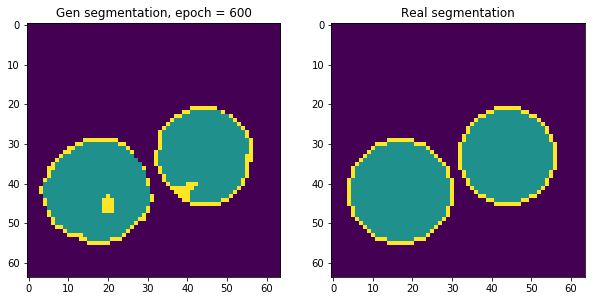

epoch - 600, loss - 0.390559017658
epoch - 601, loss - 0.391745090485
epoch - 602, loss - 0.39161837101
epoch - 603, loss - 0.411387532949
epoch - 604, loss - 0.40391010046
epoch - 605, loss - 0.396045744419
epoch - 606, loss - 0.408231914043
epoch - 607, loss - 0.376543372869
epoch - 608, loss - 0.369836062193
epoch - 609, loss - 0.354688882828
epoch - 610, loss - 0.364980071783
epoch - 611, loss - 0.358730018139
epoch - 612, loss - 0.376645326614
epoch - 613, loss - 0.38904234767
epoch - 614, loss - 0.394408851862
epoch - 615, loss - 0.393639862537
epoch - 616, loss - 0.384273767471
epoch - 617, loss - 0.384635448456
epoch - 618, loss - 0.351459294558
epoch - 619, loss - 0.346686065197
epoch - 620, loss - 0.337438136339
epoch - 621, loss - 0.349882990122
epoch - 622, loss - 0.350139826536
epoch - 623, loss - 0.371126323938
epoch - 624, loss - 0.370791584253
epoch - 625, loss - 0.356701612473
epoch - 626, loss - 0.341194242239
epoch - 627, loss - 0.339299470186
epoch - 628, loss - 0.3

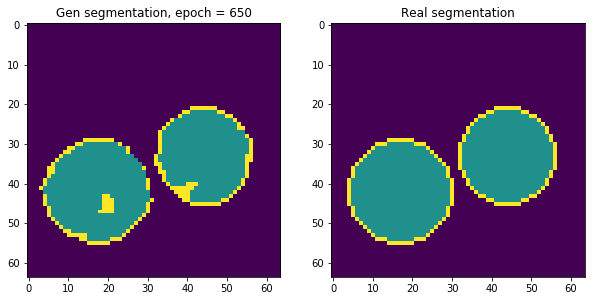

epoch - 650, loss - 0.271085619926
epoch - 651, loss - 0.25707051158
epoch - 652, loss - 0.259807497263
epoch - 653, loss - 0.263824909925
epoch - 654, loss - 0.262353509665
epoch - 655, loss - 0.262270510197
epoch - 656, loss - 0.269791722298
epoch - 657, loss - 0.277848035097
epoch - 658, loss - 0.276018619537
epoch - 659, loss - 0.282068103552
epoch - 660, loss - 0.2798576653
epoch - 661, loss - 0.284283995628
epoch - 662, loss - 0.269240856171
epoch - 663, loss - 0.262706160545
epoch - 664, loss - 0.244333803654
epoch - 665, loss - 0.233415871859
epoch - 666, loss - 0.229652523994
epoch - 667, loss - 0.233711332083
epoch - 668, loss - 0.236485674977
epoch - 669, loss - 0.240305423737
epoch - 670, loss - 0.244870126247
epoch - 671, loss - 0.245380550623
epoch - 672, loss - 0.243626400828
epoch - 673, loss - 0.23715120554
epoch - 674, loss - 0.233550384641
epoch - 675, loss - 0.224697679281
epoch - 676, loss - 0.218219190836
epoch - 677, loss - 0.211358740926
epoch - 678, loss - 0.20

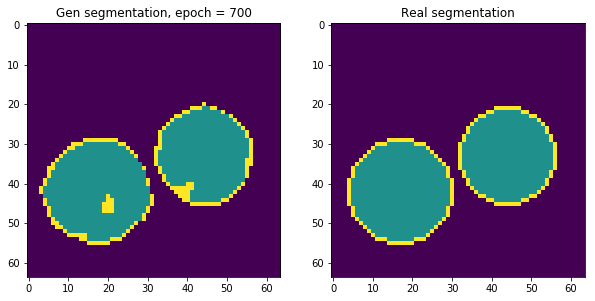

epoch - 700, loss - 0.18416595459
epoch - 701, loss - 0.193615585566
epoch - 702, loss - 0.20266969502
epoch - 703, loss - 0.203366756439
epoch - 704, loss - 0.189271882176
epoch - 705, loss - 0.178453415632
epoch - 706, loss - 0.168593257666
epoch - 707, loss - 0.174181252718
epoch - 708, loss - 0.17805556953
epoch - 709, loss - 0.185128077865
epoch - 710, loss - 0.184852734208
epoch - 711, loss - 0.178739950061
epoch - 712, loss - 0.171623706818
epoch - 713, loss - 0.162979289889
epoch - 714, loss - 0.16184040904
epoch - 715, loss - 0.158555522561
epoch - 716, loss - 0.163527160883
epoch - 717, loss - 0.164804294705
epoch - 718, loss - 0.16977623105
epoch - 719, loss - 0.173805236816
epoch - 720, loss - 0.174132496119
epoch - 721, loss - 0.178837805986
epoch - 722, loss - 0.172230273485
epoch - 723, loss - 0.174026578665
epoch - 724, loss - 0.166039764881
epoch - 725, loss - 0.167306095362
epoch - 726, loss - 0.157639637589
epoch - 727, loss - 0.15534697473
epoch - 728, loss - 0.1555

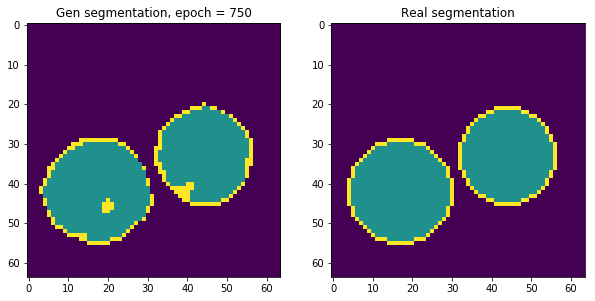

epoch - 750, loss - 0.134968712926
epoch - 751, loss - 0.14763431251
epoch - 752, loss - 0.172169938684
epoch - 753, loss - 0.232227236032
epoch - 754, loss - 0.258907437325
epoch - 755, loss - 0.32168713212
epoch - 756, loss - 0.236405670643
epoch - 757, loss - 0.168869718909
epoch - 758, loss - 0.121509104967
epoch - 759, loss - 0.152888402343
epoch - 760, loss - 0.215159952641
epoch - 761, loss - 0.179655909538
epoch - 762, loss - 0.13266633451
epoch - 763, loss - 0.117354542017
epoch - 764, loss - 0.147373452783
epoch - 765, loss - 0.175162449479
epoch - 766, loss - 0.143349409103
epoch - 767, loss - 0.113384023309
epoch - 768, loss - 0.117038413882
epoch - 769, loss - 0.13501739502
epoch - 770, loss - 0.145637363195
epoch - 771, loss - 0.121837645769
epoch - 772, loss - 0.10639616847
epoch - 773, loss - 0.112029843032
epoch - 774, loss - 0.123480655253
epoch - 775, loss - 0.124570421875
epoch - 776, loss - 0.10931456089
epoch - 777, loss - 0.101781703532
epoch - 778, loss - 0.1059

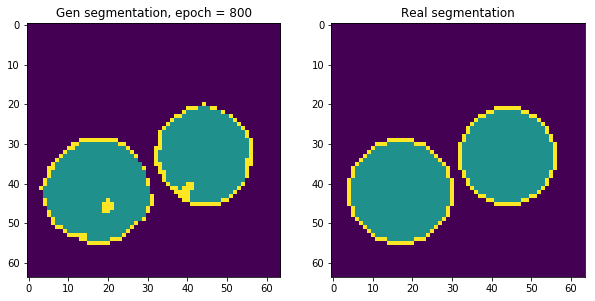

epoch - 800, loss - 0.0997447595
epoch - 801, loss - 0.10556960851
epoch - 802, loss - 0.10576724261
epoch - 803, loss - 0.109667673707
epoch - 804, loss - 0.102853029966
epoch - 805, loss - 0.0982737913728
epoch - 806, loss - 0.0890004485846
epoch - 807, loss - 0.082718834281
epoch - 808, loss - 0.0794327557087
epoch - 809, loss - 0.0799586102366
epoch - 810, loss - 0.0829588472843
epoch - 811, loss - 0.0852297097445
epoch - 812, loss - 0.0878250673413
epoch - 813, loss - 0.0859199762344
epoch - 814, loss - 0.0836699455976
epoch - 815, loss - 0.0797999948263
epoch - 816, loss - 0.0772617012262
epoch - 817, loss - 0.0765174254775
epoch - 818, loss - 0.0775091573596
epoch - 819, loss - 0.0778734907508
epoch - 820, loss - 0.0780637934804
epoch - 821, loss - 0.0772811695933
epoch - 822, loss - 0.0755953043699
epoch - 823, loss - 0.0730888098478
epoch - 824, loss - 0.0715852603316
epoch - 825, loss - 0.0708795115352
epoch - 826, loss - 0.0713709145784
epoch - 827, loss - 0.0724711418152
ep

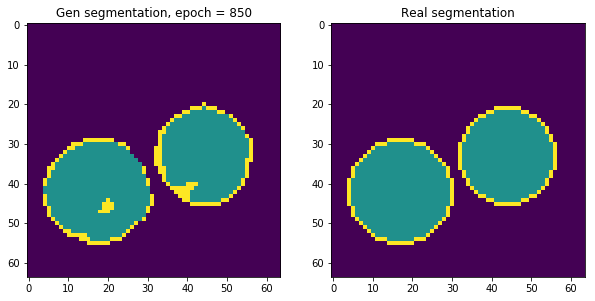

epoch - 850, loss - 0.0642139464617
epoch - 851, loss - 0.0668021142483
epoch - 852, loss - 0.0718024149537
epoch - 853, loss - 0.0762080848217
epoch - 854, loss - 0.0710802674294
epoch - 855, loss - 0.0646811053157
epoch - 856, loss - 0.0594494976103
epoch - 857, loss - 0.0595054402947
epoch - 858, loss - 0.0629540979862
epoch - 859, loss - 0.0655991360545
epoch - 860, loss - 0.0665215775371
epoch - 861, loss - 0.0628258138895
epoch - 862, loss - 0.0589107871056
epoch - 863, loss - 0.0559575557709
epoch - 864, loss - 0.0555530749261
epoch - 865, loss - 0.0569368675351
epoch - 866, loss - 0.0584737770259
epoch - 867, loss - 0.0593413673341
epoch - 868, loss - 0.0581891164184
epoch - 869, loss - 0.0566418208182
epoch - 870, loss - 0.0545367263258
epoch - 871, loss - 0.0532905682921
epoch - 872, loss - 0.052694760263
epoch - 873, loss - 0.0526014566422
epoch - 874, loss - 0.0526854656637
epoch - 875, loss - 0.0524842366576
epoch - 876, loss - 0.0518919229507
epoch - 877, loss - 0.0513250

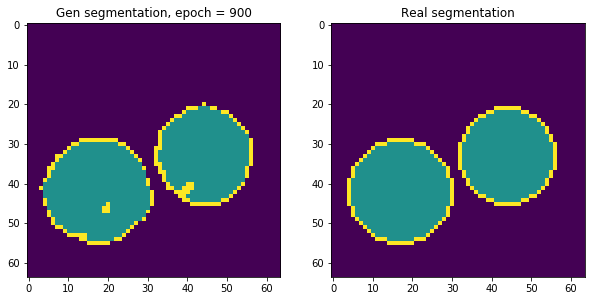

epoch - 900, loss - 0.0705844908953
epoch - 901, loss - 0.101166591048
epoch - 902, loss - 0.09285145998
epoch - 903, loss - 0.0758668705821
epoch - 904, loss - 0.0564454086125
epoch - 905, loss - 0.0611364468932
epoch - 906, loss - 0.0781740993261
epoch - 907, loss - 0.0736368075013
epoch - 908, loss - 0.060840729624
epoch - 909, loss - 0.0488511808217
epoch - 910, loss - 0.0517431646585
epoch - 911, loss - 0.062714330852
epoch - 912, loss - 0.0617491975427
epoch - 913, loss - 0.0554783195257
epoch - 914, loss - 0.0464314632118
epoch - 915, loss - 0.0458005741239
epoch - 916, loss - 0.0502076372504
epoch - 917, loss - 0.0514065660536
epoch - 918, loss - 0.0513030216098
epoch - 919, loss - 0.0476047955453
epoch - 920, loss - 0.0449179969728
epoch - 921, loss - 0.0426988825202
epoch - 922, loss - 0.042712457478
epoch - 923, loss - 0.0435400120914
epoch - 924, loss - 0.0440464802086
epoch - 925, loss - 0.0441780053079
epoch - 926, loss - 0.043386772275
epoch - 927, loss - 0.0427258983254

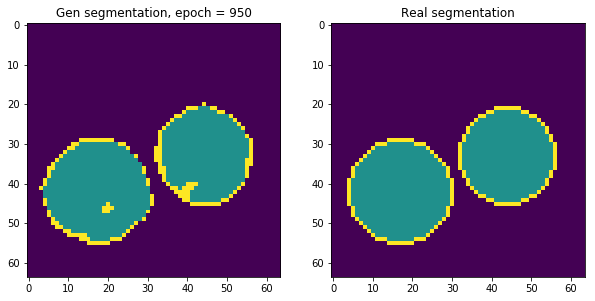

epoch - 950, loss - 0.036497592926
epoch - 951, loss - 0.0393072366714
epoch - 952, loss - 0.0427942350507
epoch - 953, loss - 0.0498804114759
epoch - 954, loss - 0.0553190968931
epoch - 955, loss - 0.0669606029987
epoch - 956, loss - 0.0707283988595
epoch - 957, loss - 0.0815524384379
epoch - 958, loss - 0.0753961503506
epoch - 959, loss - 0.0742043629289
epoch - 960, loss - 0.057994812727
epoch - 961, loss - 0.0482160151005
epoch - 962, loss - 0.041366841644
epoch - 963, loss - 0.0412576571107
epoch - 964, loss - 0.0442921072245
epoch - 965, loss - 0.0433065146208
epoch - 966, loss - 0.0418183803558
epoch - 967, loss - 0.038719303906
epoch - 968, loss - 0.0391878783703
epoch - 969, loss - 0.0407656133175
epoch - 970, loss - 0.0416683331132
epoch - 971, loss - 0.039030238986
epoch - 972, loss - 0.0337210930884
epoch - 973, loss - 0.0302406102419
epoch - 974, loss - 0.0304106771946
epoch - 975, loss - 0.0333878062665
epoch - 976, loss - 0.0357975438237
epoch - 977, loss - 0.03589014336

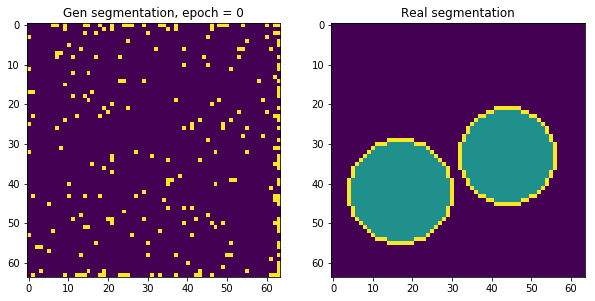

epoch - 0, loss - 6.50649547577
epoch - 1, loss - 12.8767766953
epoch - 2, loss - 6.86690807343
epoch - 3, loss - 6.33397054672
epoch - 4, loss - 6.51295042038
epoch - 5, loss - 6.44447851181
epoch - 6, loss - 6.34188938141
epoch - 7, loss - 6.29381418228
epoch - 8, loss - 6.27203941345
epoch - 9, loss - 6.24850034714
epoch - 10, loss - 6.22007274628
epoch - 11, loss - 6.18343639374
epoch - 12, loss - 6.1331744194
epoch - 13, loss - 6.07335472107
epoch - 14, loss - 6.02992105484
epoch - 15, loss - 6.0169301033
epoch - 16, loss - 6.0423374176
epoch - 17, loss - 5.98801279068
epoch - 18, loss - 5.96345758438
epoch - 19, loss - 5.92570257187
epoch - 20, loss - 5.92120265961
epoch - 21, loss - 5.90965938568
epoch - 22, loss - 5.89068126678
epoch - 23, loss - 5.8783659935
epoch - 24, loss - 5.86494016647
epoch - 25, loss - 5.84706068039
epoch - 26, loss - 5.82995223999
epoch - 27, loss - 5.81116867065
epoch - 28, loss - 5.7929315567
epoch - 29, loss - 5.81468153
epoch - 30, loss - 5.8358139

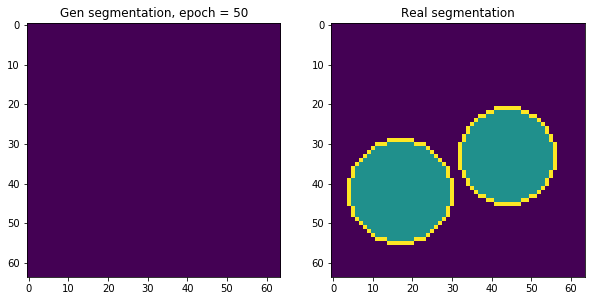

epoch - 50, loss - 5.69989204407
epoch - 51, loss - 5.77283096313
epoch - 52, loss - 5.77332115173
epoch - 53, loss - 5.68614149094
epoch - 54, loss - 5.71368408203
epoch - 55, loss - 5.67614650726
epoch - 56, loss - 5.64745616913
epoch - 57, loss - 5.68253707886
epoch - 58, loss - 5.65316486359
epoch - 59, loss - 5.62938022614
epoch - 60, loss - 5.65649843216
epoch - 61, loss - 5.61526823044
epoch - 62, loss - 5.61800813675
epoch - 63, loss - 5.61595726013
epoch - 64, loss - 5.58528423309
epoch - 65, loss - 5.58083677292
epoch - 66, loss - 5.55445718765
epoch - 67, loss - 5.55894422531
epoch - 68, loss - 5.52162837982
epoch - 69, loss - 5.53569412231
epoch - 70, loss - 5.50075244904
epoch - 71, loss - 5.46048355103
epoch - 72, loss - 5.4828338623
epoch - 73, loss - 5.53509140015
epoch - 74, loss - 5.50230503082
epoch - 75, loss - 5.38031864166
epoch - 76, loss - 5.37327480316
epoch - 77, loss - 5.43651771545
epoch - 78, loss - 5.43758153915
epoch - 79, loss - 5.34583616257
epoch - 80,

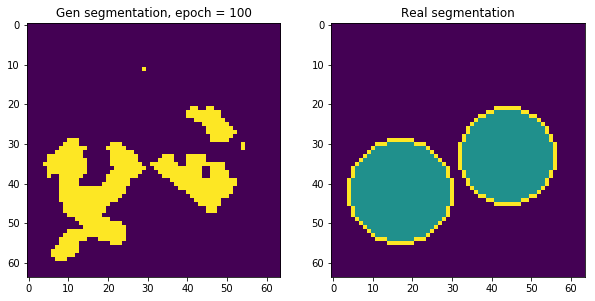

epoch - 100, loss - 4.14868307114
epoch - 101, loss - 4.19143915176
epoch - 102, loss - 4.20099115372
epoch - 103, loss - 4.02115917206
epoch - 104, loss - 4.07407236099
epoch - 105, loss - 3.97059965134
epoch - 106, loss - 3.93043923378
epoch - 107, loss - 3.91691160202
epoch - 108, loss - 3.81100702286
epoch - 109, loss - 3.81294775009
epoch - 110, loss - 3.72098994255
epoch - 111, loss - 3.7211432457
epoch - 112, loss - 3.6820025444
epoch - 113, loss - 3.65945005417
epoch - 114, loss - 3.63651061058
epoch - 115, loss - 3.58354711533
epoch - 116, loss - 3.5743534565
epoch - 117, loss - 3.53797650337
epoch - 118, loss - 3.53518843651
epoch - 119, loss - 3.4964299202
epoch - 120, loss - 3.47991728783
epoch - 121, loss - 3.4534907341
epoch - 122, loss - 3.44139075279
epoch - 123, loss - 3.42307257652
epoch - 124, loss - 3.4004907608
epoch - 125, loss - 3.38939070702
epoch - 126, loss - 3.36984276772
epoch - 127, loss - 3.36154961586
epoch - 128, loss - 3.33970236778
epoch - 129, loss - 

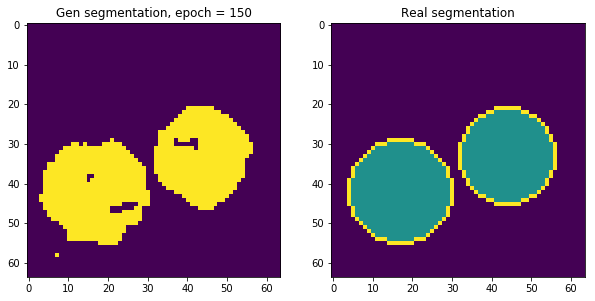

epoch - 150, loss - 3.11068606377
epoch - 151, loss - 3.10216617584
epoch - 152, loss - 3.09273314476
epoch - 153, loss - 3.08397650719
epoch - 154, loss - 3.07580566406
epoch - 155, loss - 3.06825733185
epoch - 156, loss - 3.06489634514
epoch - 157, loss - 3.07115292549
epoch - 158, loss - 3.10101389885
epoch - 159, loss - 3.18913841248
epoch - 160, loss - 3.22708058357
epoch - 161, loss - 3.19408941269
epoch - 162, loss - 3.02776241302
epoch - 163, loss - 3.10774087906
epoch - 164, loss - 3.17641878128
epoch - 165, loss - 3.0019402504
epoch - 166, loss - 3.13746738434
epoch - 167, loss - 3.12732458115
epoch - 168, loss - 3.01258397102
epoch - 169, loss - 3.15364694595
epoch - 170, loss - 3.02669978142
epoch - 171, loss - 3.05632662773
epoch - 172, loss - 3.00398612022
epoch - 173, loss - 3.00173139572
epoch - 174, loss - 2.99302458763
epoch - 175, loss - 2.99594593048
epoch - 176, loss - 2.96426296234
epoch - 177, loss - 2.97346568108
epoch - 178, loss - 2.93544650078
epoch - 179, lo

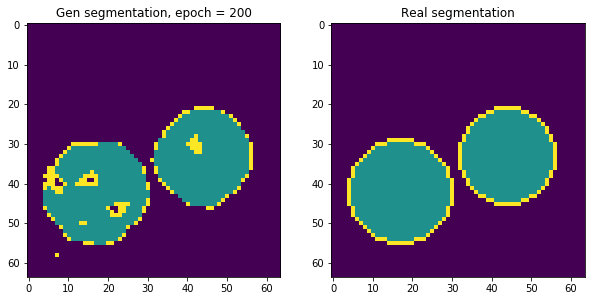

epoch - 200, loss - 2.76750826836
epoch - 201, loss - 2.76374340057
epoch - 202, loss - 2.76480150223
epoch - 203, loss - 2.77250170708
epoch - 204, loss - 2.80223631859
epoch - 205, loss - 2.82925438881
epoch - 206, loss - 2.86393260956
epoch - 207, loss - 2.83452010155
epoch - 208, loss - 2.75891041756
epoch - 209, loss - 2.70894384384
epoch - 210, loss - 2.70823311806
epoch - 211, loss - 2.74502849579
epoch - 212, loss - 2.73616051674
epoch - 213, loss - 2.69999718666
epoch - 214, loss - 2.67789912224
epoch - 215, loss - 2.68397212029
epoch - 216, loss - 2.69579172134
epoch - 217, loss - 2.67933797836
epoch - 218, loss - 2.65834522247
epoch - 219, loss - 2.64579749107
epoch - 220, loss - 2.65442538261
epoch - 221, loss - 2.66427135468
epoch - 222, loss - 2.66527962685
epoch - 223, loss - 2.64108037949
epoch - 224, loss - 2.61464691162
epoch - 225, loss - 2.60461616516
epoch - 226, loss - 2.61475157738
epoch - 227, loss - 2.62018704414
epoch - 228, loss - 2.61275434494
epoch - 229, l

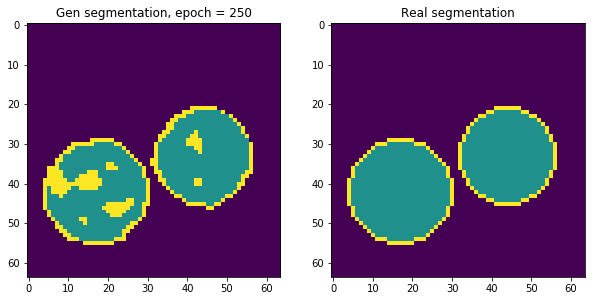

epoch - 250, loss - 2.52627491951
epoch - 251, loss - 2.57676768303
epoch - 252, loss - 2.51803708076
epoch - 253, loss - 2.53291082382
epoch - 254, loss - 2.52745199203
epoch - 255, loss - 2.50461816788
epoch - 256, loss - 2.50424075127
epoch - 257, loss - 2.50576353073
epoch - 258, loss - 2.48273253441
epoch - 259, loss - 2.48977279663
epoch - 260, loss - 2.4728474617
epoch - 261, loss - 2.48303437233
epoch - 262, loss - 2.46672272682
epoch - 263, loss - 2.45456314087
epoch - 264, loss - 2.45227789879
epoch - 265, loss - 2.45201230049
epoch - 266, loss - 2.4470949173
epoch - 267, loss - 2.4401614666
epoch - 268, loss - 2.42666530609
epoch - 269, loss - 2.42538928986
epoch - 270, loss - 2.41710400581
epoch - 271, loss - 2.41908073425
epoch - 272, loss - 2.41669845581
epoch - 273, loss - 2.41474270821
epoch - 274, loss - 2.4151237011
epoch - 275, loss - 2.40858435631
epoch - 276, loss - 2.40766406059
epoch - 277, loss - 2.40211701393
epoch - 278, loss - 2.39941072464
epoch - 279, loss 

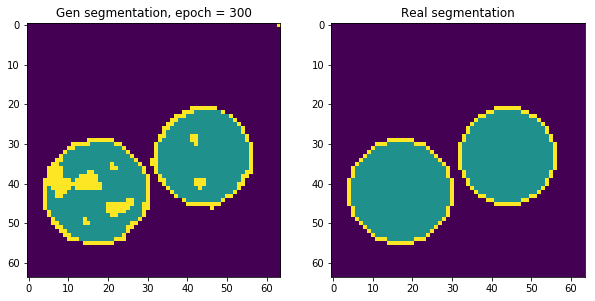

epoch - 300, loss - 2.36288499832
epoch - 301, loss - 2.33593130112
epoch - 302, loss - 2.29114198685
epoch - 303, loss - 2.31969738007
epoch - 304, loss - 2.32896256447
epoch - 305, loss - 2.28830504417
epoch - 306, loss - 2.27676010132
epoch - 307, loss - 2.30016255379
epoch - 308, loss - 2.29873728752
epoch - 309, loss - 2.28217029572
epoch - 310, loss - 2.25915336609
epoch - 311, loss - 2.25497794151
epoch - 312, loss - 2.26904201508
epoch - 313, loss - 2.28002333641
epoch - 314, loss - 2.27002668381
epoch - 315, loss - 2.25209403038
epoch - 316, loss - 2.24008774757
epoch - 317, loss - 2.22557520866
epoch - 318, loss - 2.22677302361
epoch - 319, loss - 2.23456811905
epoch - 320, loss - 2.24285364151
epoch - 321, loss - 2.24444890022
epoch - 322, loss - 2.25100421906
epoch - 323, loss - 2.25146865845
epoch - 324, loss - 2.23913455009
epoch - 325, loss - 2.22338557243
epoch - 326, loss - 2.20609855652
epoch - 327, loss - 2.19355559349
epoch - 328, loss - 2.18287301064
epoch - 329, l

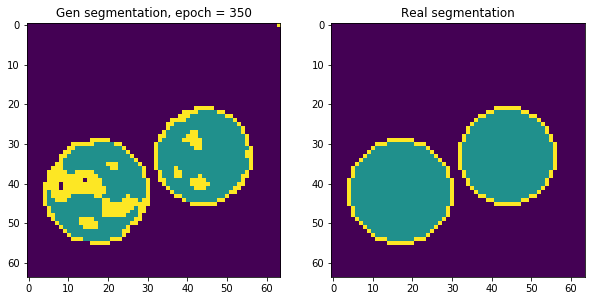

epoch - 350, loss - 2.13059830666
epoch - 351, loss - 2.15393090248
epoch - 352, loss - 2.22471761703
epoch - 353, loss - 2.29372477531
epoch - 354, loss - 2.24993419647
epoch - 355, loss - 2.15950107574
epoch - 356, loss - 2.12010669708
epoch - 357, loss - 2.14061307907
epoch - 358, loss - 2.12035679817
epoch - 359, loss - 2.11242842674
epoch - 360, loss - 2.1283082962
epoch - 361, loss - 2.09916806221
epoch - 362, loss - 2.06085133553
epoch - 363, loss - 2.07965564728
epoch - 364, loss - 2.09358477592
epoch - 365, loss - 2.05797553062
epoch - 366, loss - 2.04023623466
epoch - 367, loss - 2.06248688698
epoch - 368, loss - 2.05539083481
epoch - 369, loss - 2.0275747776
epoch - 370, loss - 2.02950286865
epoch - 371, loss - 2.04138445854
epoch - 372, loss - 2.02529096603
epoch - 373, loss - 2.01273560524
epoch - 374, loss - 2.03216791153
epoch - 375, loss - 2.08003664017
epoch - 376, loss - 2.14917349815
epoch - 377, loss - 2.19495868683
epoch - 378, loss - 2.13418936729
epoch - 379, los

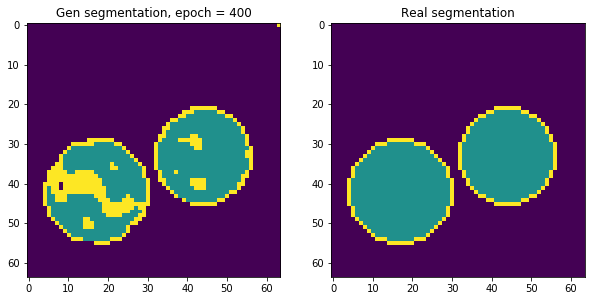

epoch - 400, loss - 1.92725431919
epoch - 401, loss - 1.91570448875
epoch - 402, loss - 1.91377437115
epoch - 403, loss - 1.92494523525
epoch - 404, loss - 1.95139837265
epoch - 405, loss - 1.98621678352
epoch - 406, loss - 2.00419425964
epoch - 407, loss - 2.00491666794
epoch - 408, loss - 1.97508215904
epoch - 409, loss - 1.91475236416
epoch - 410, loss - 1.87533676624
epoch - 411, loss - 1.88148367405
epoch - 412, loss - 1.91215443611
epoch - 413, loss - 1.9205493927
epoch - 414, loss - 1.88072729111
epoch - 415, loss - 1.84949171543
epoch - 416, loss - 1.85457110405
epoch - 417, loss - 1.87071669102
epoch - 418, loss - 1.87477099895
epoch - 419, loss - 1.87031555176
epoch - 420, loss - 1.87955987453
epoch - 421, loss - 1.88447475433
epoch - 422, loss - 1.86990177631
epoch - 423, loss - 1.84531104565
epoch - 424, loss - 1.83377718925
epoch - 425, loss - 1.82943665981
epoch - 426, loss - 1.81801056862
epoch - 427, loss - 1.80167019367
epoch - 428, loss - 1.79367399216
epoch - 429, lo

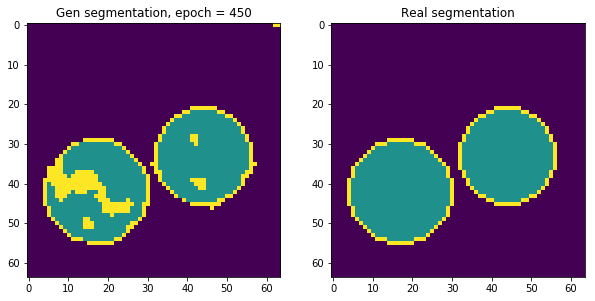

epoch - 450, loss - 1.75824725628
epoch - 451, loss - 1.75163924694
epoch - 452, loss - 1.75320744514
epoch - 453, loss - 1.78261089325
epoch - 454, loss - 1.77887070179
epoch - 455, loss - 1.77294504642
epoch - 456, loss - 1.75709605217
epoch - 457, loss - 1.72128820419
epoch - 458, loss - 1.69429409504
epoch - 459, loss - 1.68585312366
epoch - 460, loss - 1.68279588223
epoch - 461, loss - 1.69317674637
epoch - 462, loss - 1.705514431
epoch - 463, loss - 1.69524538517
epoch - 464, loss - 1.67823660374
epoch - 465, loss - 1.66655361652
epoch - 466, loss - 1.65658068657
epoch - 467, loss - 1.64289629459
epoch - 468, loss - 1.64073646069
epoch - 469, loss - 1.64923417568
epoch - 470, loss - 1.65914368629
epoch - 471, loss - 1.67829692364
epoch - 472, loss - 1.72026705742
epoch - 473, loss - 1.76809668541
epoch - 474, loss - 1.74601221085
epoch - 475, loss - 1.68102359772
epoch - 476, loss - 1.63359332085
epoch - 477, loss - 1.61099207401
epoch - 478, loss - 1.61898171902
epoch - 479, los

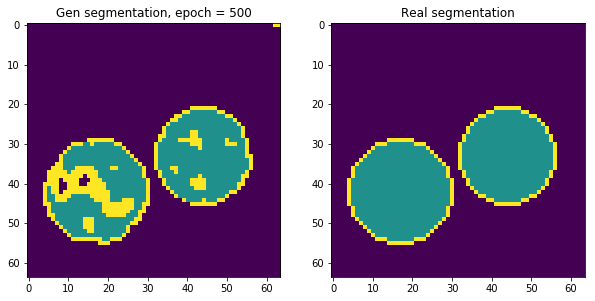

epoch - 500, loss - 1.52648866177
epoch - 501, loss - 1.51270759106
epoch - 502, loss - 1.51137089729
epoch - 503, loss - 1.52062237263
epoch - 504, loss - 1.5298422575
epoch - 505, loss - 1.53326678276
epoch - 506, loss - 1.51239943504
epoch - 507, loss - 1.49223518372
epoch - 508, loss - 1.48599016666
epoch - 509, loss - 1.51012396812
epoch - 510, loss - 1.57572305202
epoch - 511, loss - 1.64812016487
epoch - 512, loss - 1.64242577553
epoch - 513, loss - 1.59754419327
epoch - 514, loss - 1.58098006248
epoch - 515, loss - 1.57046639919
epoch - 516, loss - 1.49659717083
epoch - 517, loss - 1.46683943272
epoch - 518, loss - 1.50806748867
epoch - 519, loss - 1.52144312859
epoch - 520, loss - 1.45643997192
epoch - 521, loss - 1.43785452843
epoch - 522, loss - 1.47568821907
epoch - 523, loss - 1.46857893467
epoch - 524, loss - 1.42593050003
epoch - 525, loss - 1.4350297451
epoch - 526, loss - 1.46137523651
epoch - 527, loss - 1.44296550751
epoch - 528, loss - 1.44410502911
epoch - 529, los

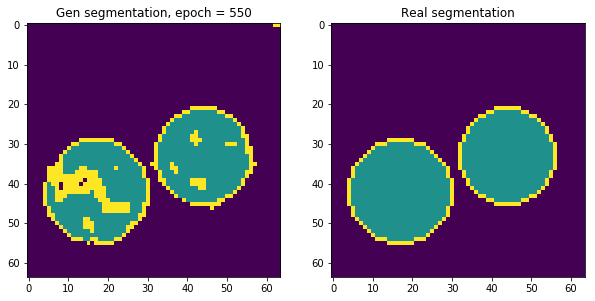

epoch - 550, loss - 1.35609567165
epoch - 551, loss - 1.3979088068
epoch - 552, loss - 1.42149877548
epoch - 553, loss - 1.41081833839
epoch - 554, loss - 1.38742983341
epoch - 555, loss - 1.35723984241
epoch - 556, loss - 1.32912957668
epoch - 557, loss - 1.31656479836
epoch - 558, loss - 1.32488894463
epoch - 559, loss - 1.33751761913
epoch - 560, loss - 1.33686995506
epoch - 561, loss - 1.32990455627
epoch - 562, loss - 1.32010710239
epoch - 563, loss - 1.29086899757
epoch - 564, loss - 1.26803731918
epoch - 565, loss - 1.27452433109
epoch - 566, loss - 1.29373812675
epoch - 567, loss - 1.29245483875
epoch - 568, loss - 1.27338671684
epoch - 569, loss - 1.26323747635
epoch - 570, loss - 1.27004635334
epoch - 571, loss - 1.28329408169
epoch - 572, loss - 1.28589558601
epoch - 573, loss - 1.25820064545
epoch - 574, loss - 1.25410687923
epoch - 575, loss - 1.27144896984
epoch - 576, loss - 1.28796994686
epoch - 577, loss - 1.29307496548
epoch - 578, loss - 1.28813588619
epoch - 579, lo

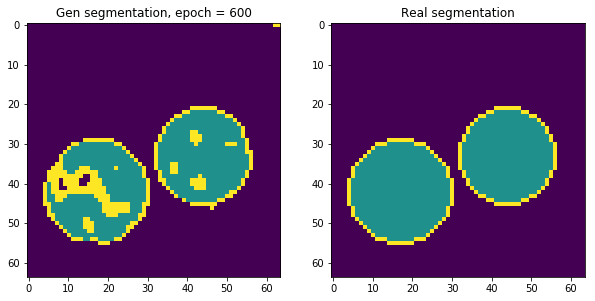

epoch - 600, loss - 1.14548873901
epoch - 601, loss - 1.13275587559
epoch - 602, loss - 1.142791152
epoch - 603, loss - 1.15072000027
epoch - 604, loss - 1.16286683083
epoch - 605, loss - 1.19280004501
epoch - 606, loss - 1.23910701275
epoch - 607, loss - 1.26028370857
epoch - 608, loss - 1.21361327171
epoch - 609, loss - 1.16422379017
epoch - 610, loss - 1.13970255852
epoch - 611, loss - 1.13031256199
epoch - 612, loss - 1.13334274292
epoch - 613, loss - 1.14747524261
epoch - 614, loss - 1.15573620796
epoch - 615, loss - 1.13719522953
epoch - 616, loss - 1.09698450565
epoch - 617, loss - 1.08325791359
epoch - 618, loss - 1.10378611088
epoch - 619, loss - 1.11348724365
epoch - 620, loss - 1.10231995583
epoch - 621, loss - 1.10637366772
epoch - 622, loss - 1.13301575184
epoch - 623, loss - 1.14554798603
epoch - 624, loss - 1.11964309216
epoch - 625, loss - 1.09998488426
epoch - 626, loss - 1.09519696236
epoch - 627, loss - 1.07368373871
epoch - 628, loss - 1.0459843874
epoch - 629, loss

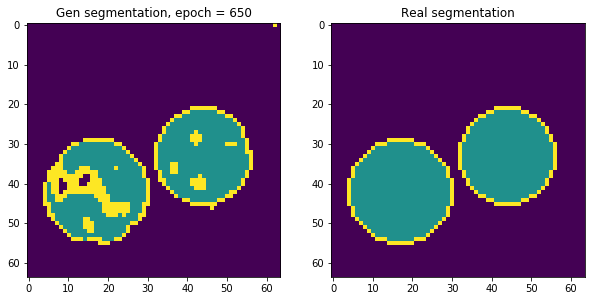

epoch - 650, loss - 1.0010612011
epoch - 651, loss - 0.975543558598
epoch - 652, loss - 0.976215422153
epoch - 653, loss - 0.993406176567
epoch - 654, loss - 1.01073253155
epoch - 655, loss - 1.03216445446
epoch - 656, loss - 1.06160712242
epoch - 657, loss - 1.10172104836
epoch - 658, loss - 1.1119171381
epoch - 659, loss - 1.06064414978
epoch - 660, loss - 0.983096241951
epoch - 661, loss - 0.950634121895
epoch - 662, loss - 0.977424144745
epoch - 663, loss - 1.01920926571
epoch - 664, loss - 1.01162791252
epoch - 665, loss - 0.95874363184
epoch - 666, loss - 0.928632616997
epoch - 667, loss - 0.945660471916
epoch - 668, loss - 0.97650462389
epoch - 669, loss - 0.97839641571
epoch - 670, loss - 0.942587018013
epoch - 671, loss - 0.920653820038
epoch - 672, loss - 0.931345820427
epoch - 673, loss - 0.936993360519
epoch - 674, loss - 0.923311769962
epoch - 675, loss - 0.901210188866
epoch - 676, loss - 0.90941375494
epoch - 677, loss - 0.937638700008
epoch - 678, loss - 0.931300699711


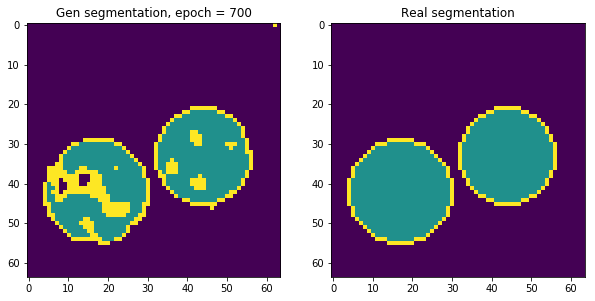

epoch - 700, loss - 0.842048704624
epoch - 701, loss - 0.835120201111
epoch - 702, loss - 0.825207650661
epoch - 703, loss - 0.819481194019
epoch - 704, loss - 0.822939276695
epoch - 705, loss - 0.831076681614
epoch - 706, loss - 0.840789079666
epoch - 707, loss - 0.850558340549
epoch - 708, loss - 0.876487314701
epoch - 709, loss - 0.925403475761
epoch - 710, loss - 0.961068868637
epoch - 711, loss - 0.933632254601
epoch - 712, loss - 0.848930120468
epoch - 713, loss - 0.81114178896
epoch - 714, loss - 0.821187257767
epoch - 715, loss - 0.83771699667
epoch - 716, loss - 0.837588429451
epoch - 717, loss - 0.817690253258
epoch - 718, loss - 0.80610960722
epoch - 719, loss - 0.807636022568
epoch - 720, loss - 0.810976862907
epoch - 721, loss - 0.803318083286
epoch - 722, loss - 0.78993076086
epoch - 723, loss - 0.774710714817
epoch - 724, loss - 0.774596810341
epoch - 725, loss - 0.786851346493
epoch - 726, loss - 0.795066535473
epoch - 727, loss - 0.785487771034
epoch - 728, loss - 0.76

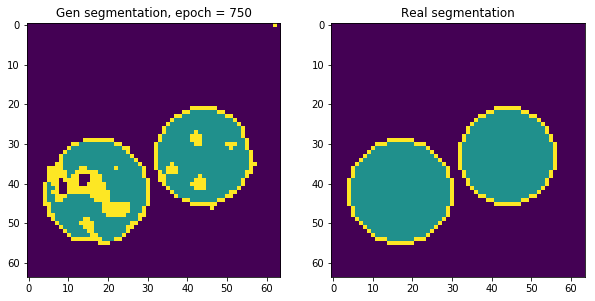

epoch - 750, loss - 0.740241587162
epoch - 751, loss - 0.728220522404
epoch - 752, loss - 0.738241314888
epoch - 753, loss - 0.791465163231
epoch - 754, loss - 0.815413594246
epoch - 755, loss - 0.784950077534
epoch - 756, loss - 0.749779701233
epoch - 757, loss - 0.734176397324
epoch - 758, loss - 0.708909928799
epoch - 759, loss - 0.694465339184
epoch - 760, loss - 0.70238751173
epoch - 761, loss - 0.709529101849
epoch - 762, loss - 0.697503328323
epoch - 763, loss - 0.692055225372
epoch - 764, loss - 0.703327894211
epoch - 765, loss - 0.706594586372
epoch - 766, loss - 0.683262705803
epoch - 767, loss - 0.671889483929
epoch - 768, loss - 0.673975944519
epoch - 769, loss - 0.677451908588
epoch - 770, loss - 0.679215610027
epoch - 771, loss - 0.674924552441
epoch - 772, loss - 0.674504041672
epoch - 773, loss - 0.669353067875
epoch - 774, loss - 0.667572081089
epoch - 775, loss - 0.685235202312
epoch - 776, loss - 0.733501195908
epoch - 777, loss - 0.787015318871
epoch - 778, loss - 0

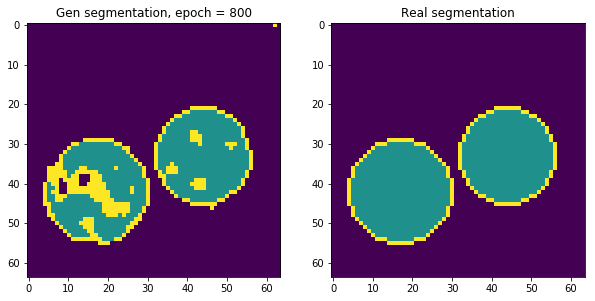

epoch - 800, loss - 0.591640591621
epoch - 801, loss - 0.591022312641
epoch - 802, loss - 0.596461594105
epoch - 803, loss - 0.599766254425
epoch - 804, loss - 0.598042905331
epoch - 805, loss - 0.59240680933
epoch - 806, loss - 0.586477458477
epoch - 807, loss - 0.581431150436
epoch - 808, loss - 0.5841319561
epoch - 809, loss - 0.60090136528
epoch - 810, loss - 0.624986946583
epoch - 811, loss - 0.638536155224
epoch - 812, loss - 0.641459822655
epoch - 813, loss - 0.652813017368
epoch - 814, loss - 0.665937066078
epoch - 815, loss - 0.656433522701
epoch - 816, loss - 0.609101593494
epoch - 817, loss - 0.565948665142
epoch - 818, loss - 0.562114655972
epoch - 819, loss - 0.587643325329
epoch - 820, loss - 0.600802183151
epoch - 821, loss - 0.578855514526
epoch - 822, loss - 0.554573893547
epoch - 823, loss - 0.558725893497
epoch - 824, loss - 0.585114240646
epoch - 825, loss - 0.579644739628
epoch - 826, loss - 0.556612610817
epoch - 827, loss - 0.539985656738
epoch - 828, loss - 0.55

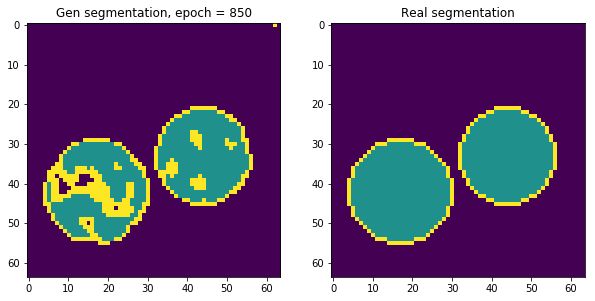

epoch - 850, loss - 0.533791422844
epoch - 851, loss - 0.518994092941
epoch - 852, loss - 0.498557537794
epoch - 853, loss - 0.497603774071
epoch - 854, loss - 0.512462496758
epoch - 855, loss - 0.520725131035
epoch - 856, loss - 0.527470946312
epoch - 857, loss - 0.549442768097
epoch - 858, loss - 0.590608656406
epoch - 859, loss - 0.605231642723
epoch - 860, loss - 0.563348770142
epoch - 861, loss - 0.527417421341
epoch - 862, loss - 0.517519652843
epoch - 863, loss - 0.513476371765
epoch - 864, loss - 0.51612919569
epoch - 865, loss - 0.52767932415
epoch - 866, loss - 0.54761081934
epoch - 867, loss - 0.536686062813
epoch - 868, loss - 0.500277280807
epoch - 869, loss - 0.480149894953
epoch - 870, loss - 0.484127134085
epoch - 871, loss - 0.489639312029
epoch - 872, loss - 0.483127832413
epoch - 873, loss - 0.480052500963
epoch - 874, loss - 0.496770232916
epoch - 875, loss - 0.501323461533
epoch - 876, loss - 0.481623768806
epoch - 877, loss - 0.47496214509
epoch - 878, loss - 0.49

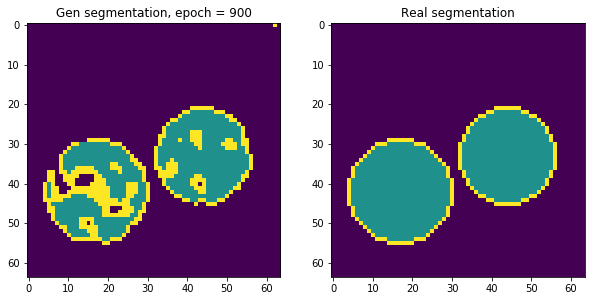

epoch - 900, loss - 0.607836902142
epoch - 901, loss - 0.618015170097
epoch - 902, loss - 0.534014046192
epoch - 903, loss - 0.447246938944
epoch - 904, loss - 0.444664359093
epoch - 905, loss - 0.487431794405
epoch - 906, loss - 0.506021261215
epoch - 907, loss - 0.487350344658
epoch - 908, loss - 0.466121524572
epoch - 909, loss - 0.451340913773
epoch - 910, loss - 0.449865102768
epoch - 911, loss - 0.460197478533
epoch - 912, loss - 0.464466392994
epoch - 913, loss - 0.444265395403
epoch - 914, loss - 0.417780786753
epoch - 915, loss - 0.426431208849
epoch - 916, loss - 0.450766205788
epoch - 917, loss - 0.447483032942
epoch - 918, loss - 0.413496732712
epoch - 919, loss - 0.397174686193
epoch - 920, loss - 0.414844483137
epoch - 921, loss - 0.432361483574
epoch - 922, loss - 0.425218433142
epoch - 923, loss - 0.407214283943
epoch - 924, loss - 0.412967294455
epoch - 925, loss - 0.435887932777
epoch - 926, loss - 0.44437405467
epoch - 927, loss - 0.416305601597
epoch - 928, loss - 0

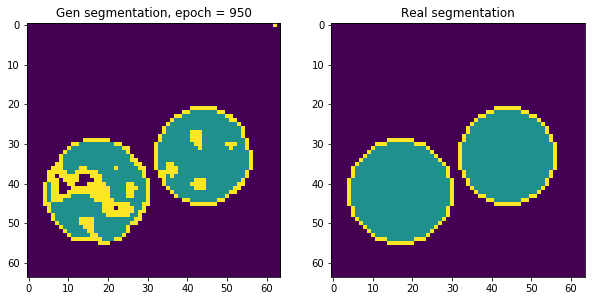

epoch - 950, loss - 0.374713927507
epoch - 951, loss - 0.38199570775
epoch - 952, loss - 0.386507809162
epoch - 953, loss - 0.38796839118
epoch - 954, loss - 0.389883518219
epoch - 955, loss - 0.392122983932
epoch - 956, loss - 0.388633131981
epoch - 957, loss - 0.376583307981
epoch - 958, loss - 0.363765180111
epoch - 959, loss - 0.353770643473
epoch - 960, loss - 0.346983164549
epoch - 961, loss - 0.345127522945
epoch - 962, loss - 0.345416516066
epoch - 963, loss - 0.351765275002
epoch - 964, loss - 0.358636707067
epoch - 965, loss - 0.366662234068
epoch - 966, loss - 0.372909784317
epoch - 967, loss - 0.381827265024
epoch - 968, loss - 0.394329488277
epoch - 969, loss - 0.401949286461
epoch - 970, loss - 0.399045944214
epoch - 971, loss - 0.381553769112
epoch - 972, loss - 0.356108993292
epoch - 973, loss - 0.335336118937
epoch - 974, loss - 0.332845121622
epoch - 975, loss - 0.341713070869
epoch - 976, loss - 0.351924866438
epoch - 977, loss - 0.35161921382
epoch - 978, loss - 0.3

In [34]:
torch.manual_seed(42)
loss_10, loss_100, segm_loss_10, segm_loss_100 = generate_and_train(network_class=Network)

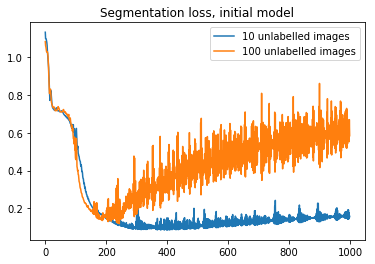

In [35]:
plt.plot(segm_loss_10, label='10 unlabelled images')
plt.plot(segm_loss_100, label='100 unlabelled images')
plt.title('Segmentation loss, initial model')
plt.legend()
plt.show()

### Unet

/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:961: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


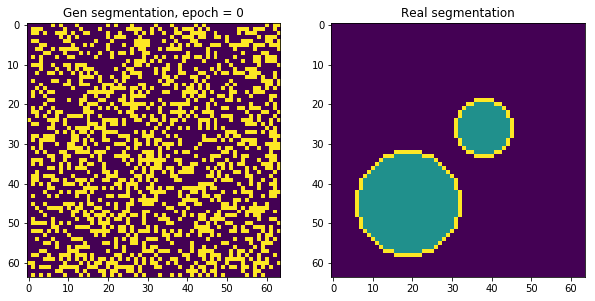

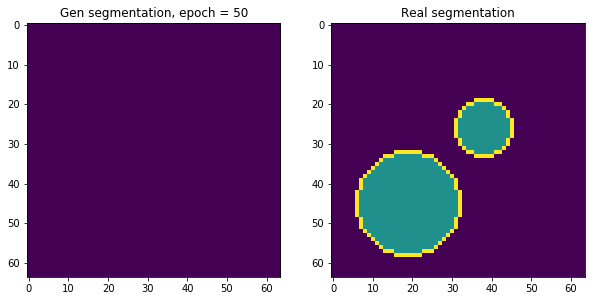

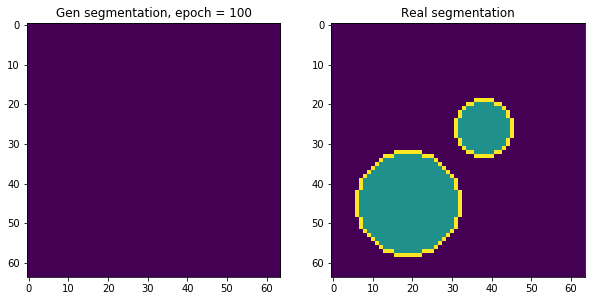

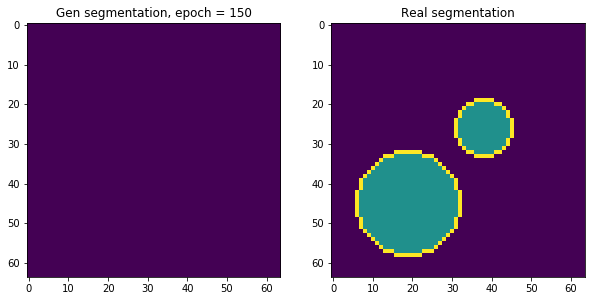

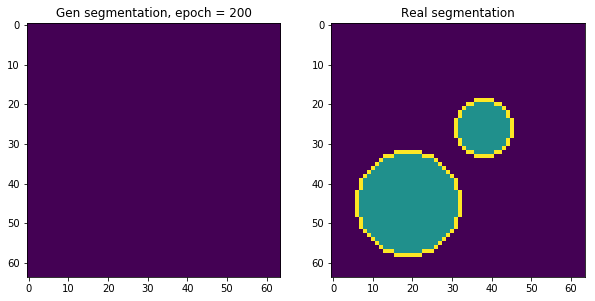

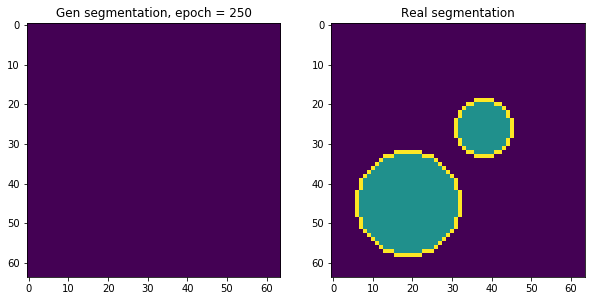

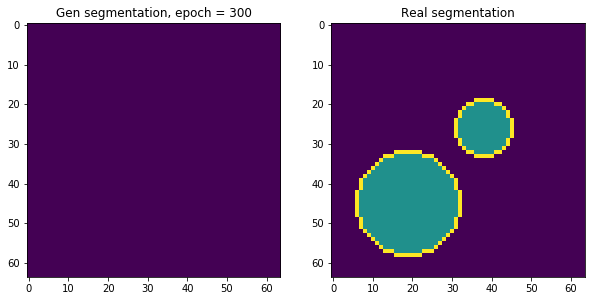

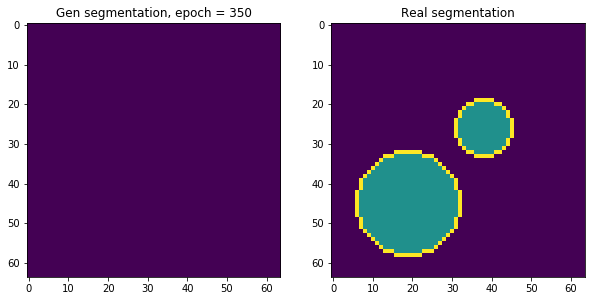

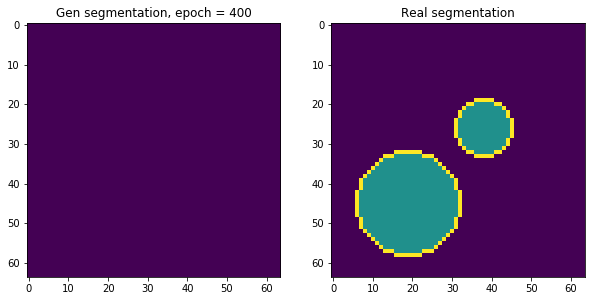

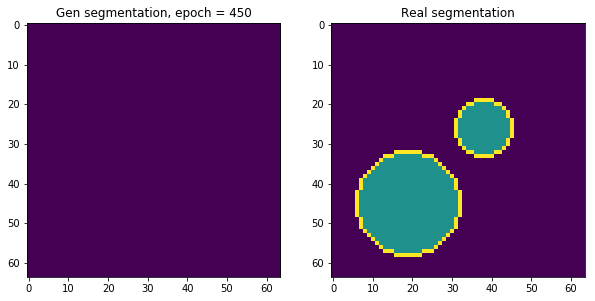

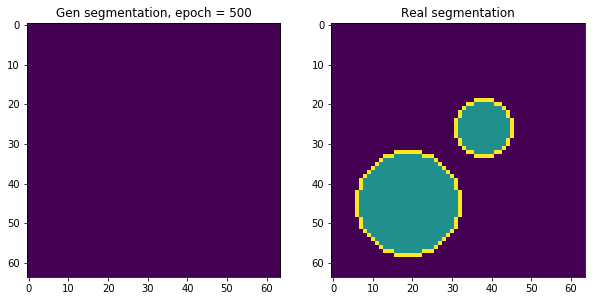

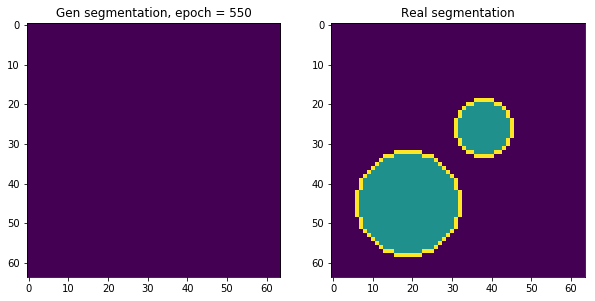

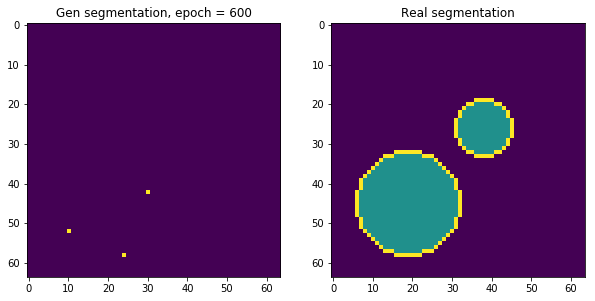

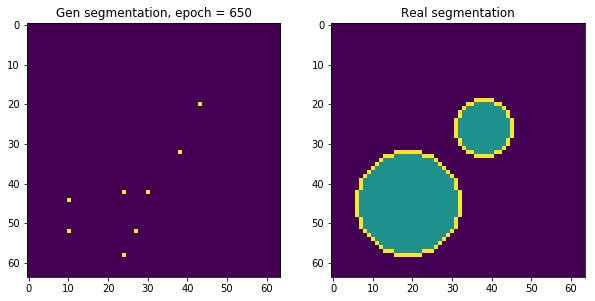

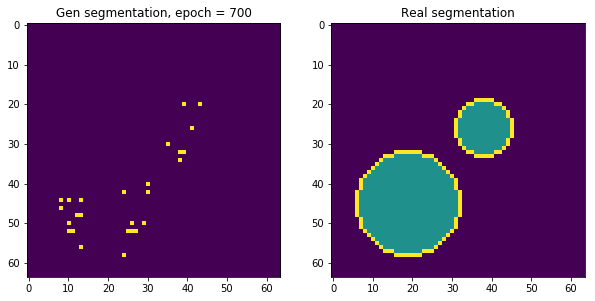

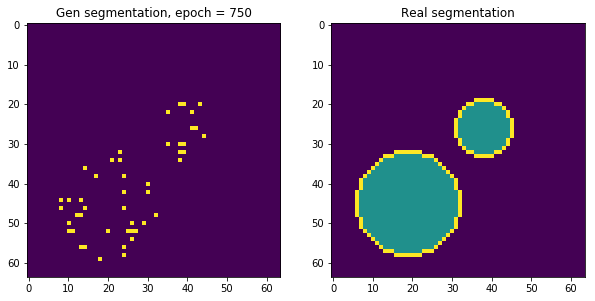

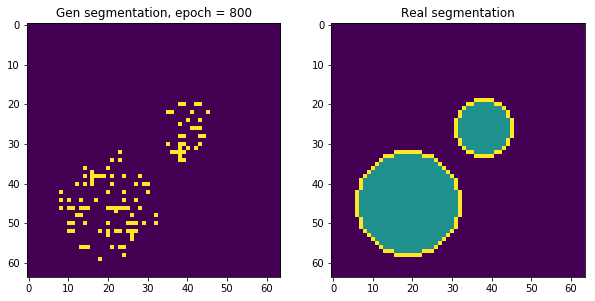

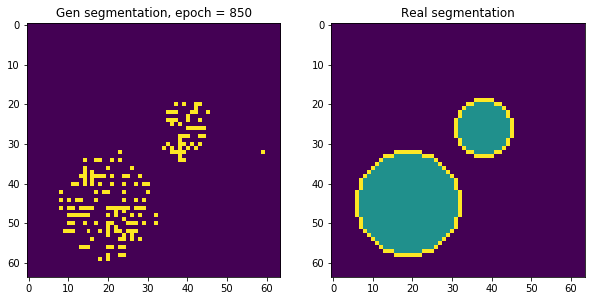

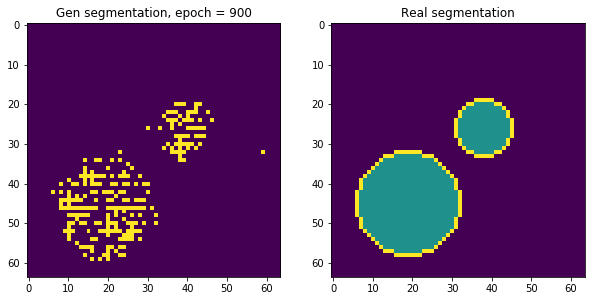

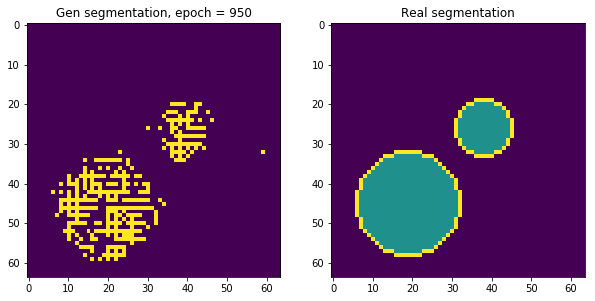

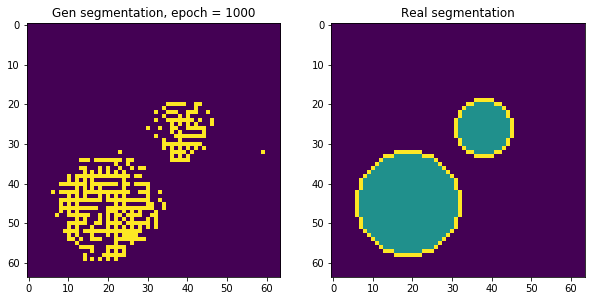

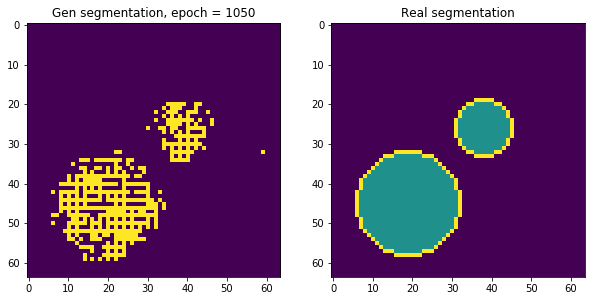

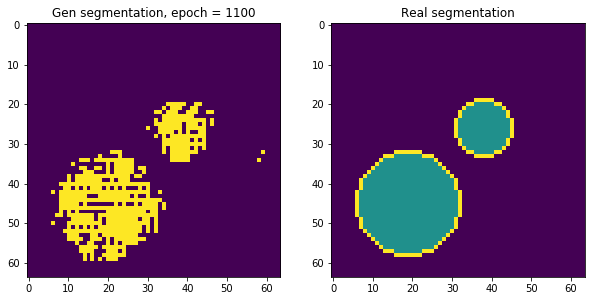

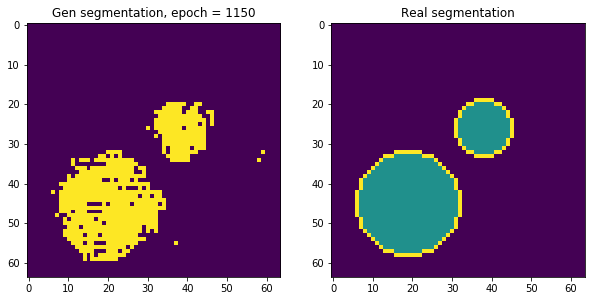

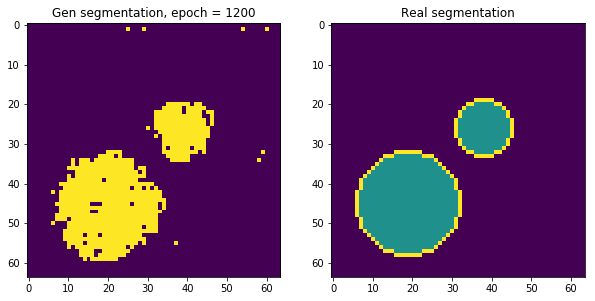

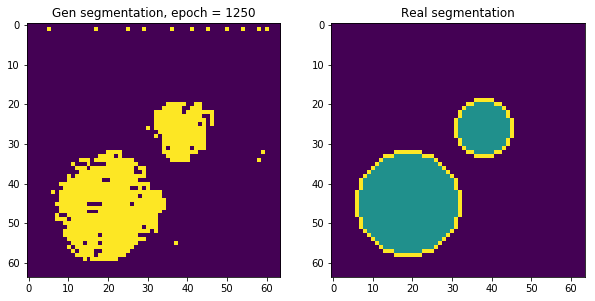

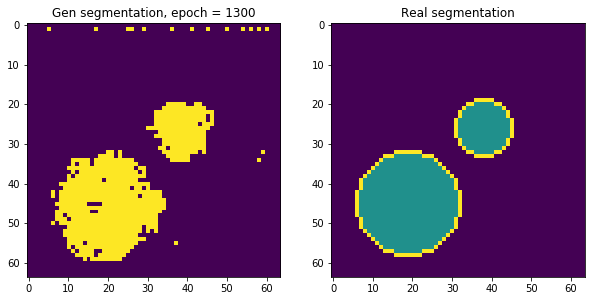

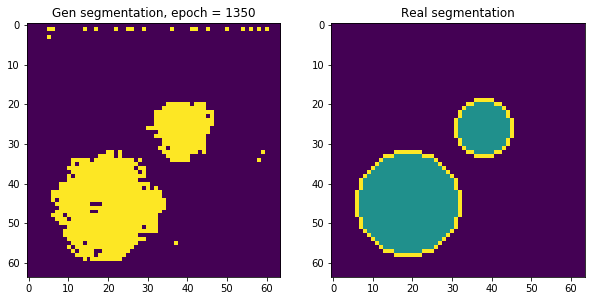

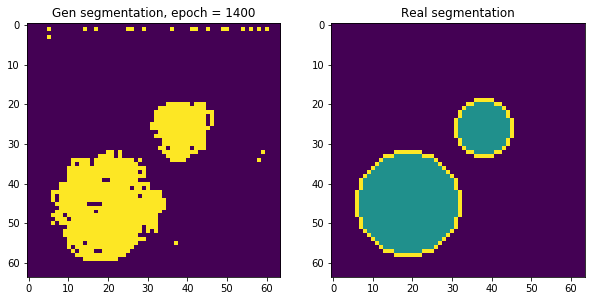

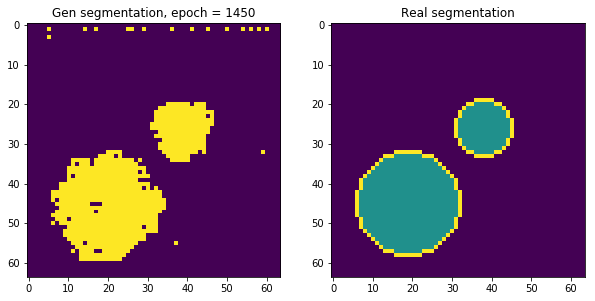

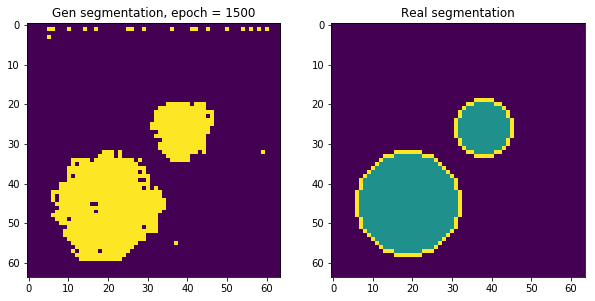

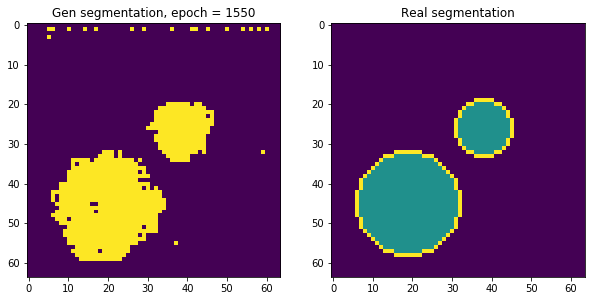

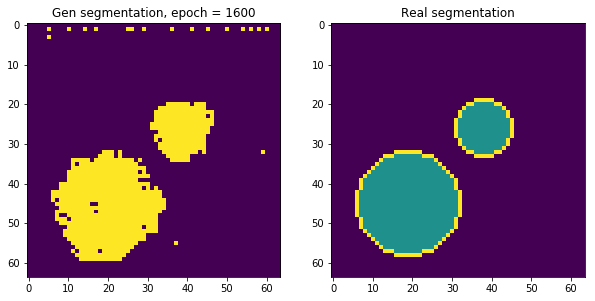

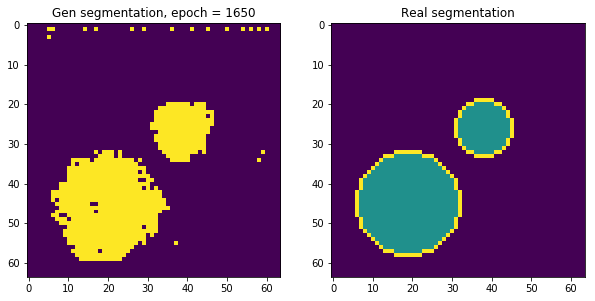

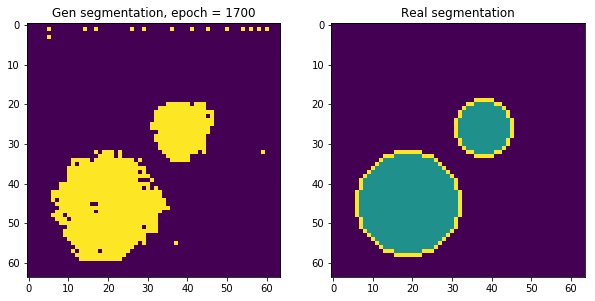

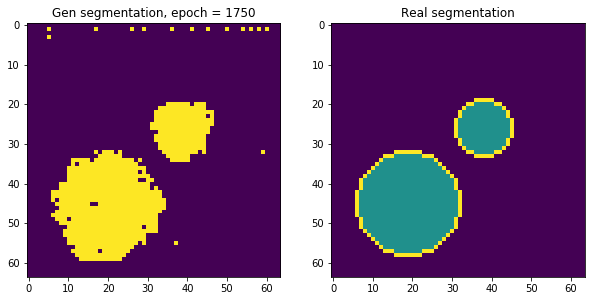

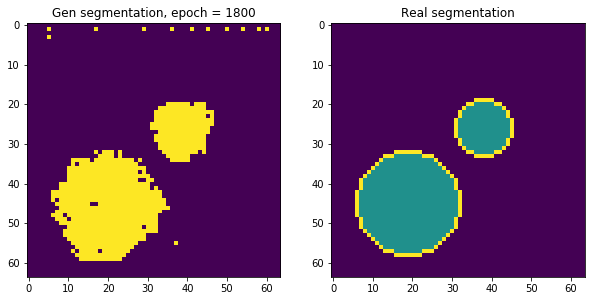

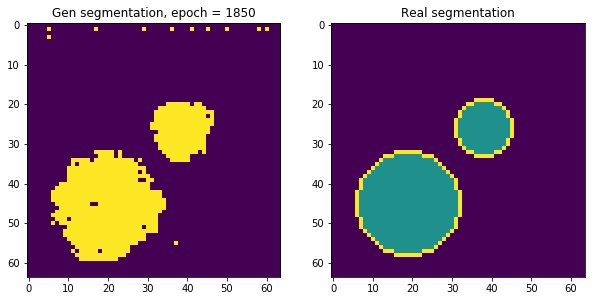

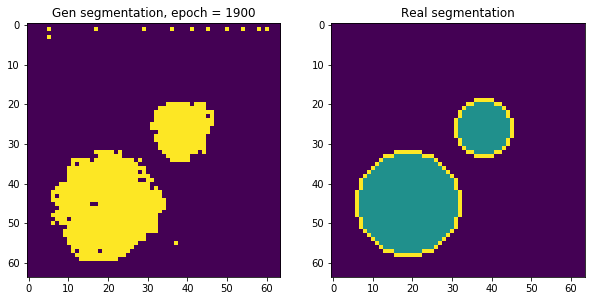

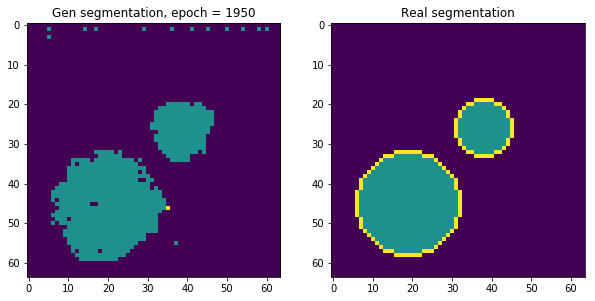

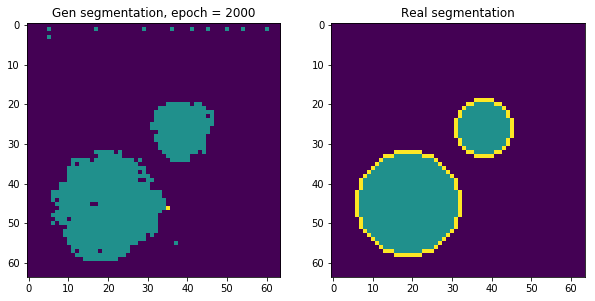

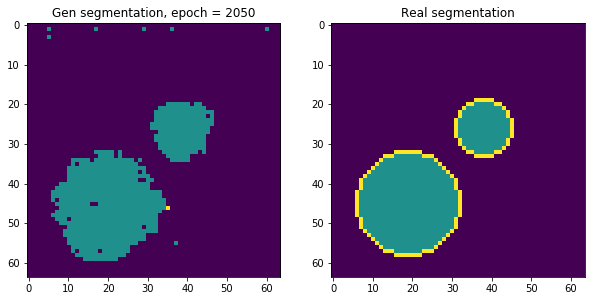

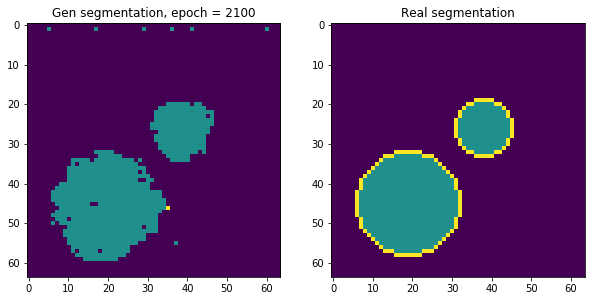

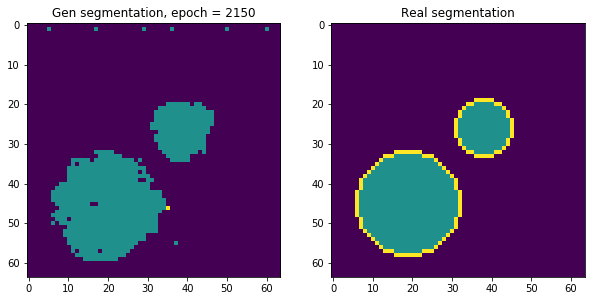

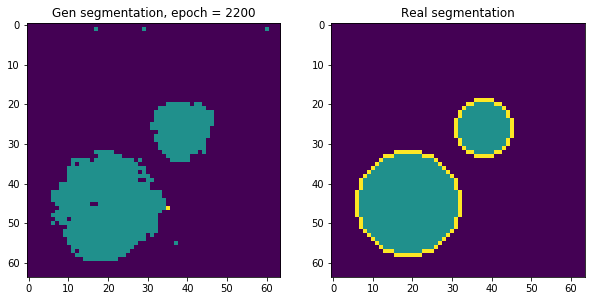

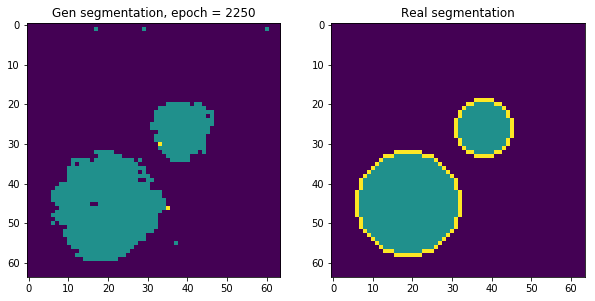

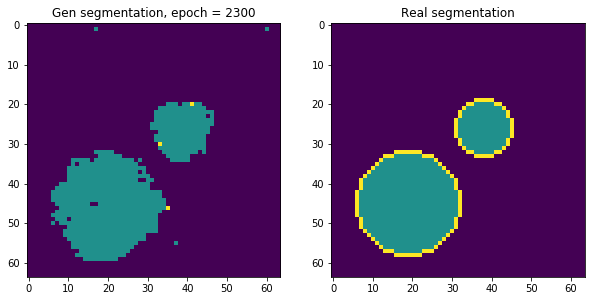

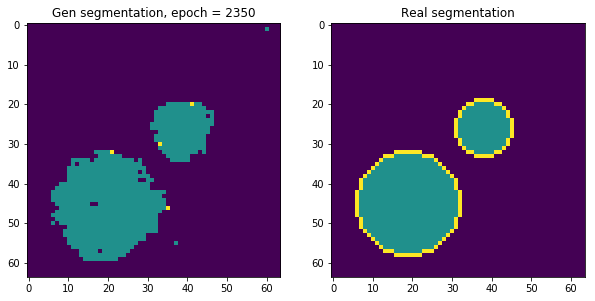

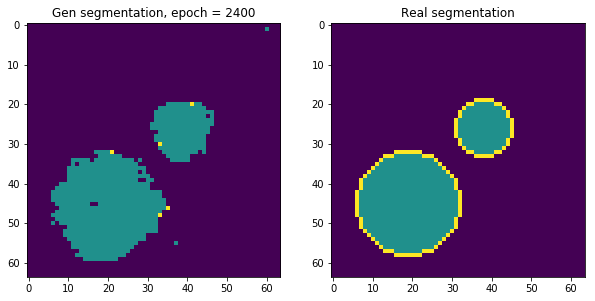

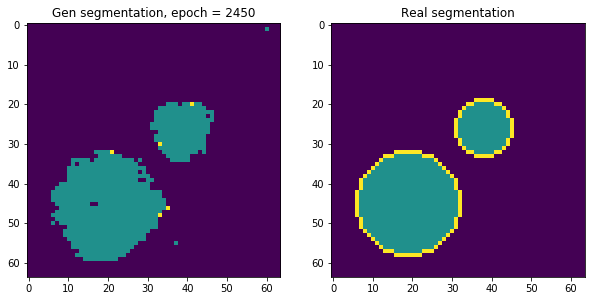

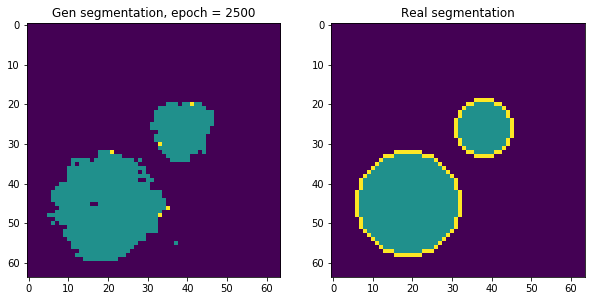

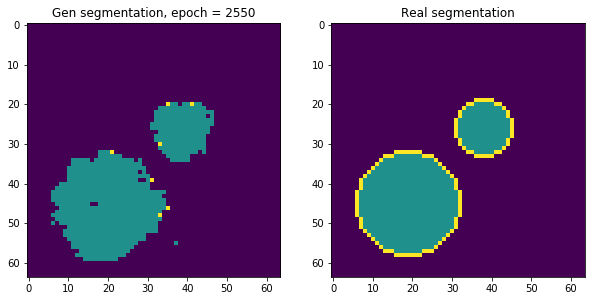

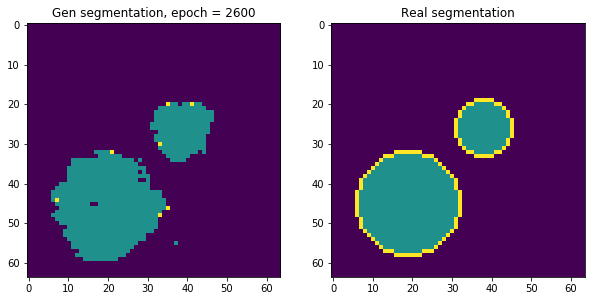

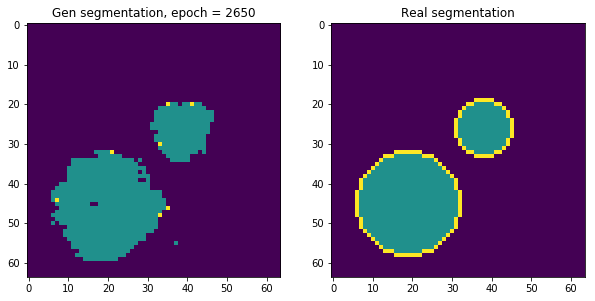

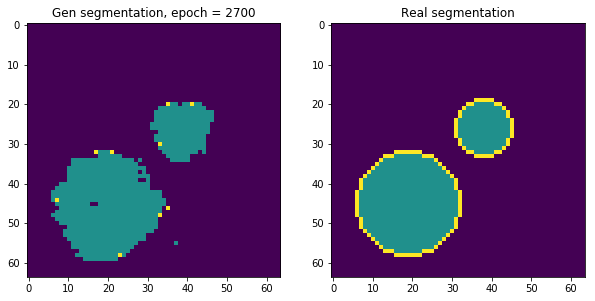

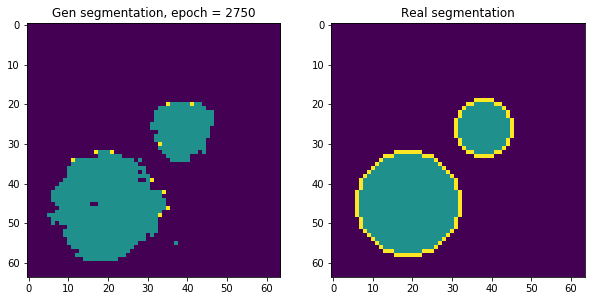

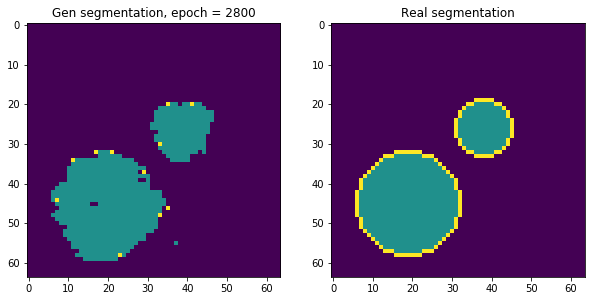

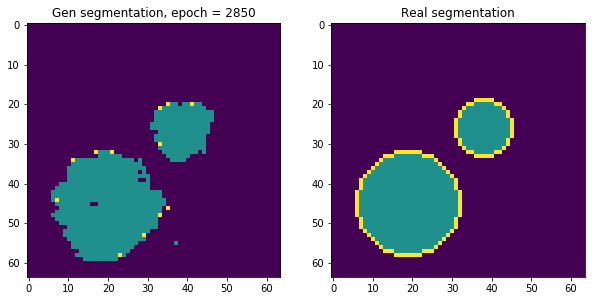

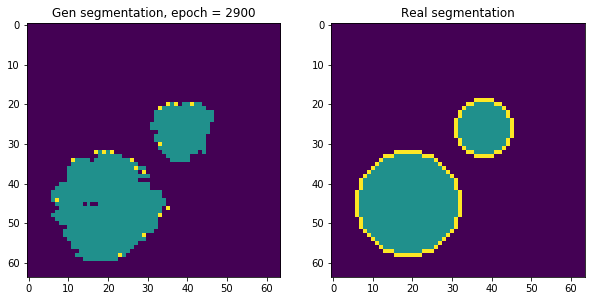

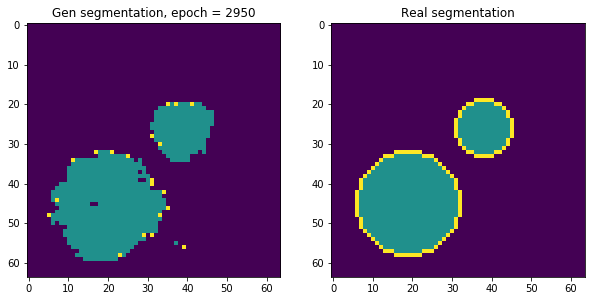

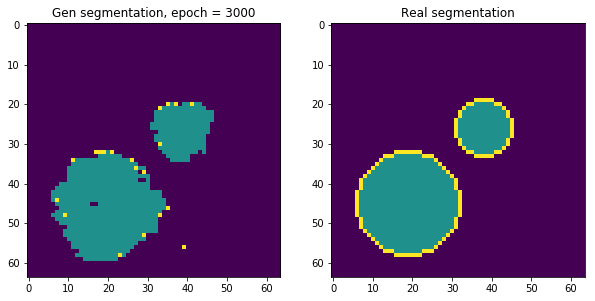

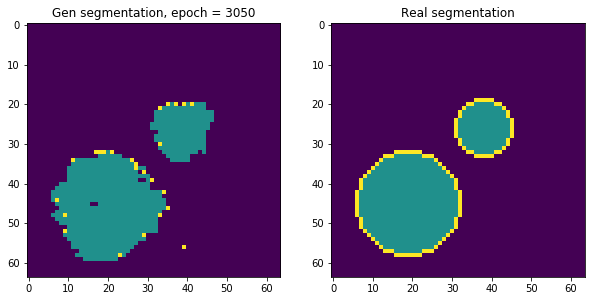

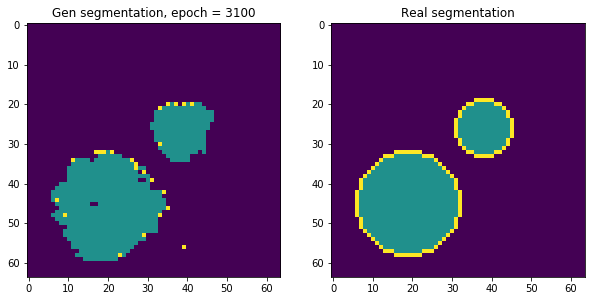

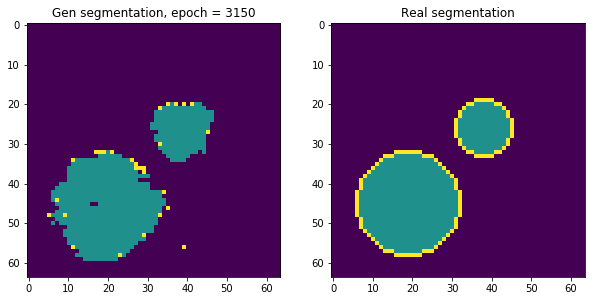

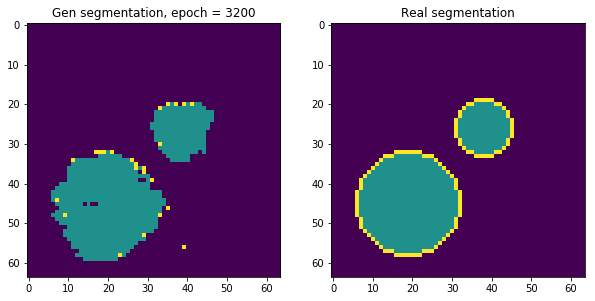

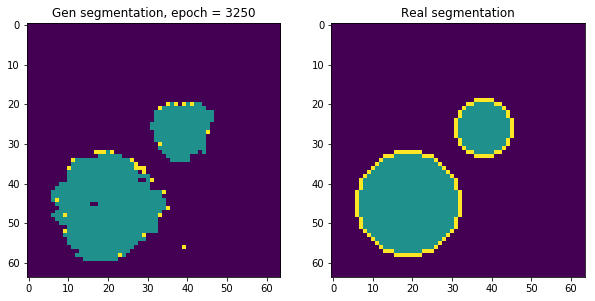

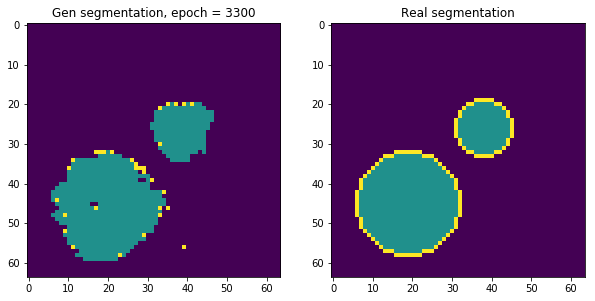

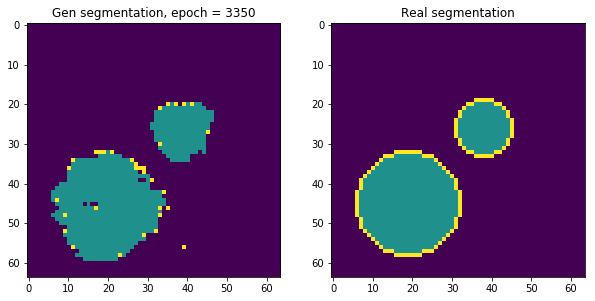

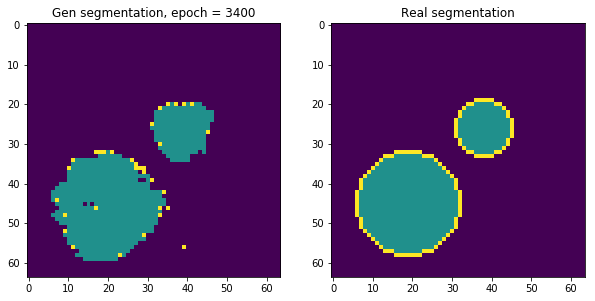

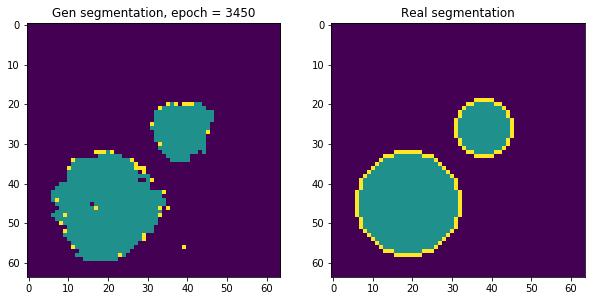

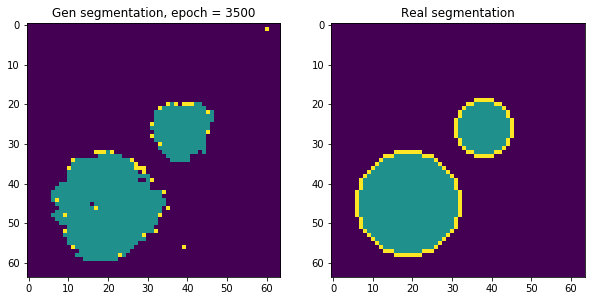

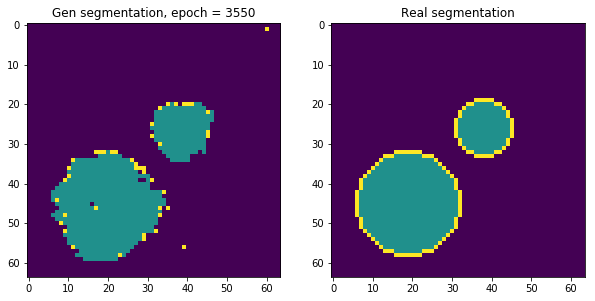

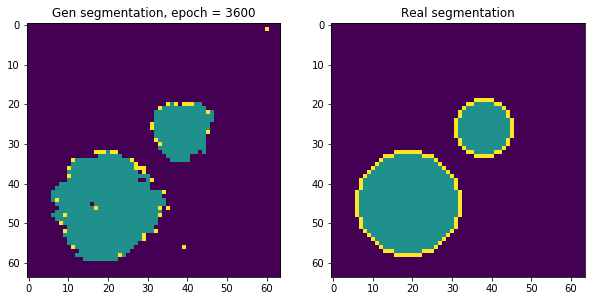

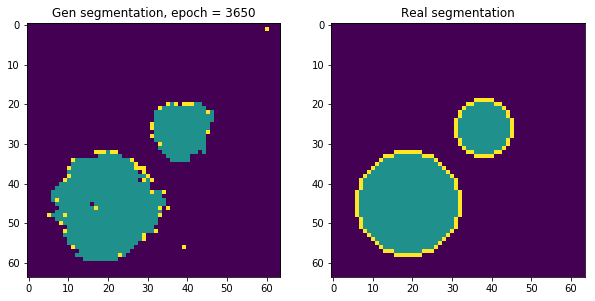

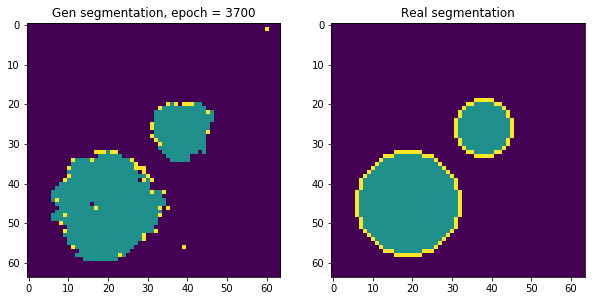

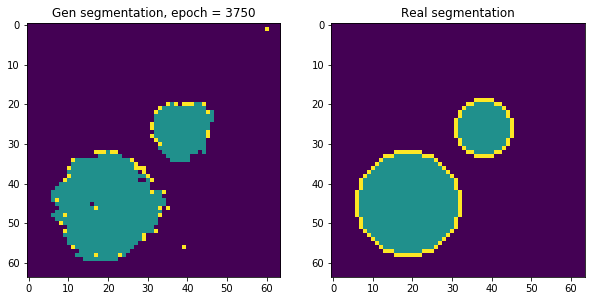

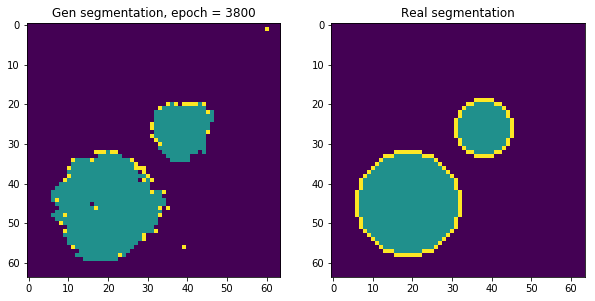

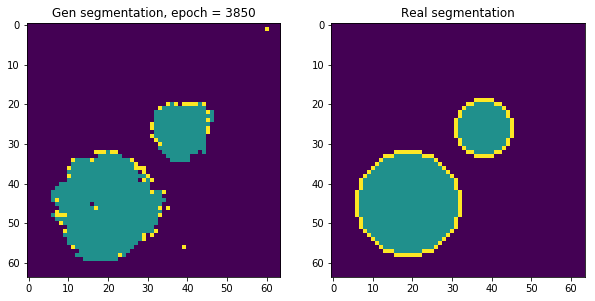

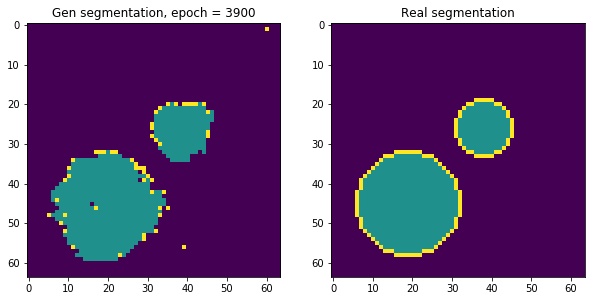

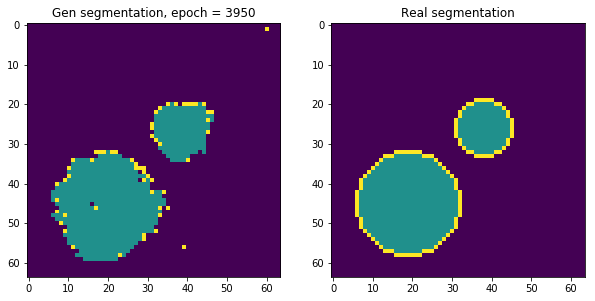

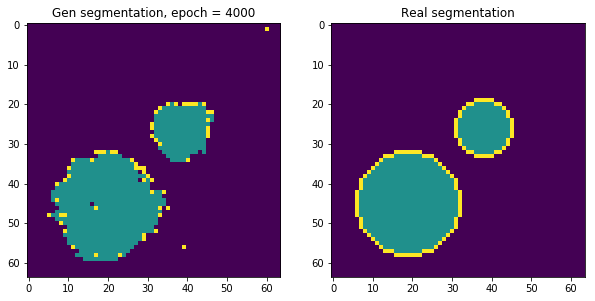

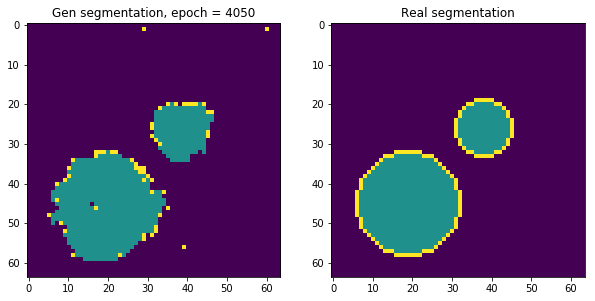

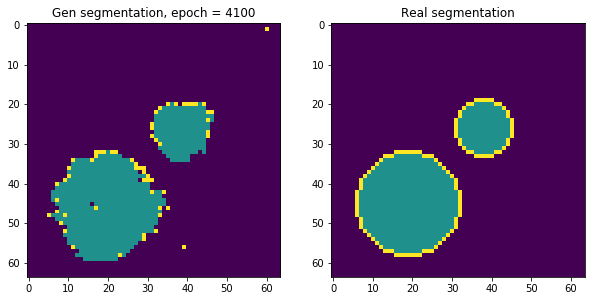

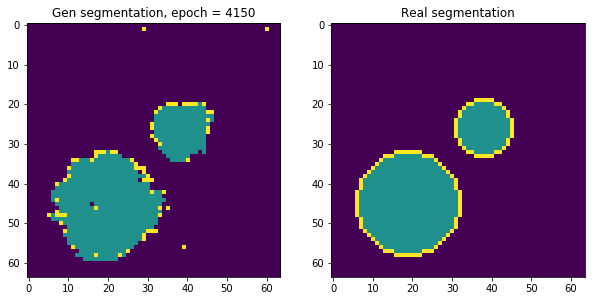

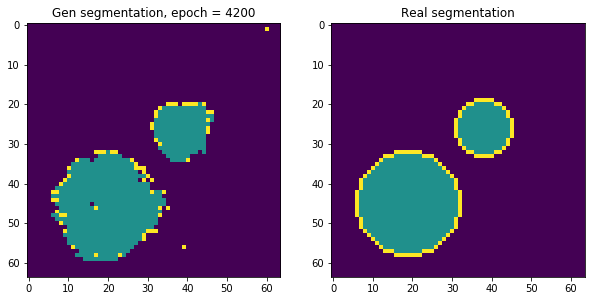

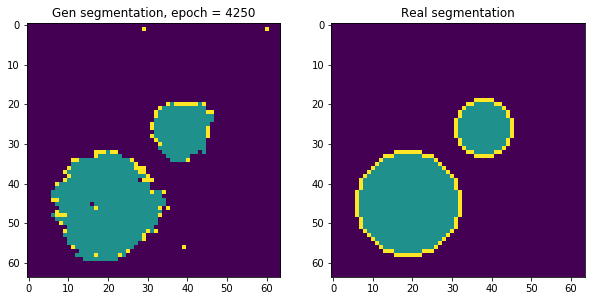

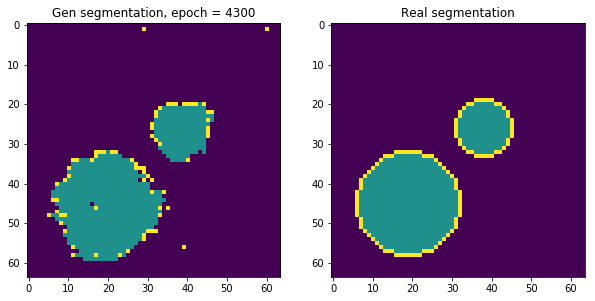

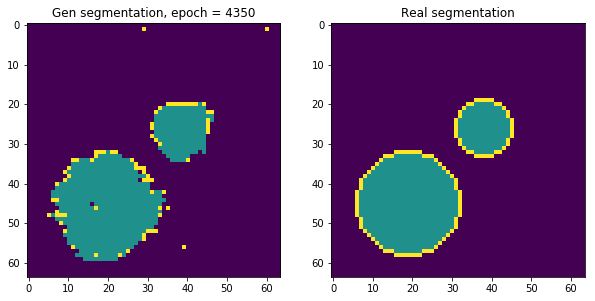

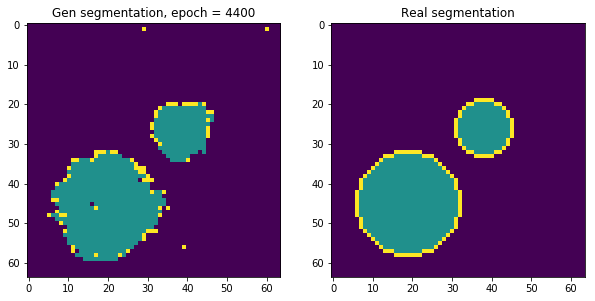

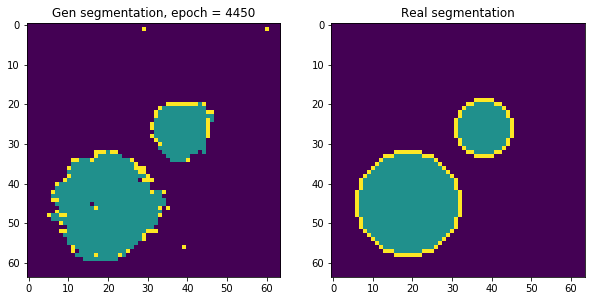

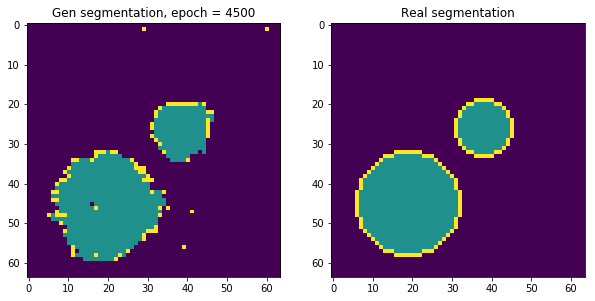

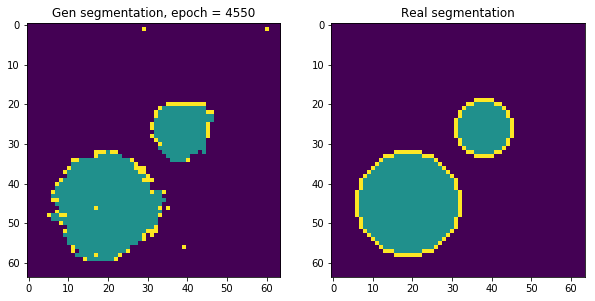

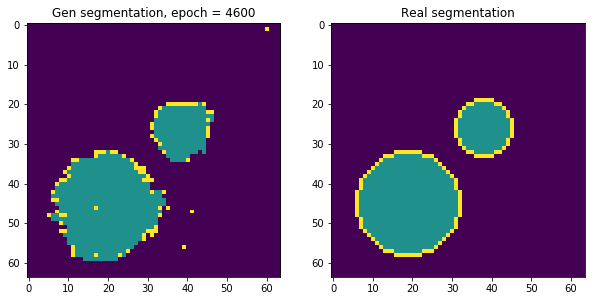

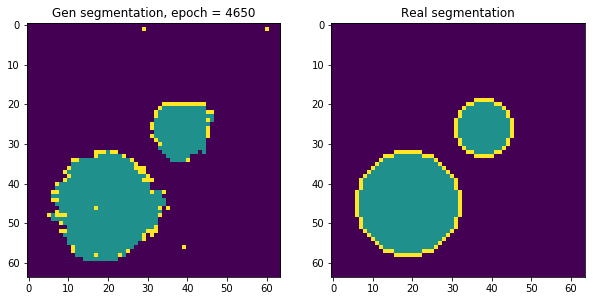

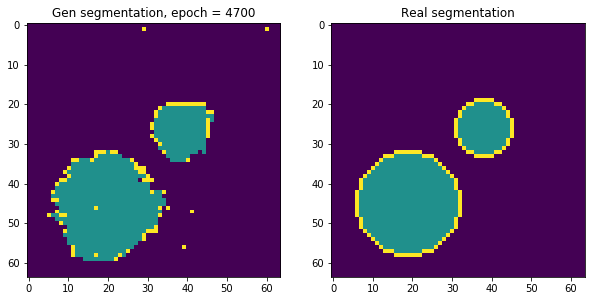

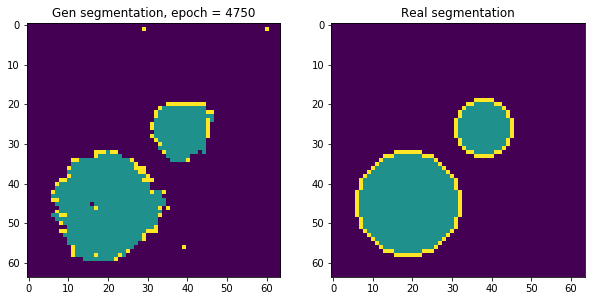

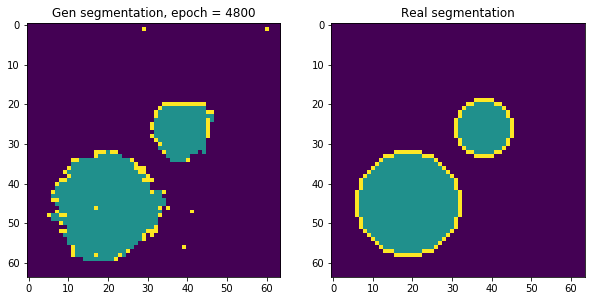

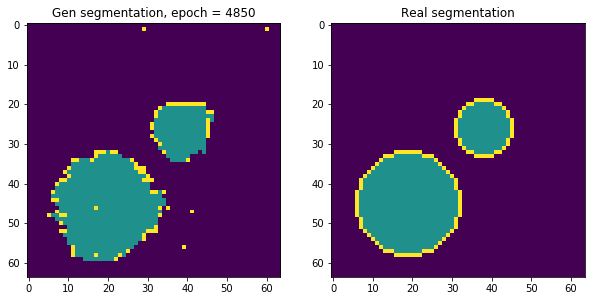

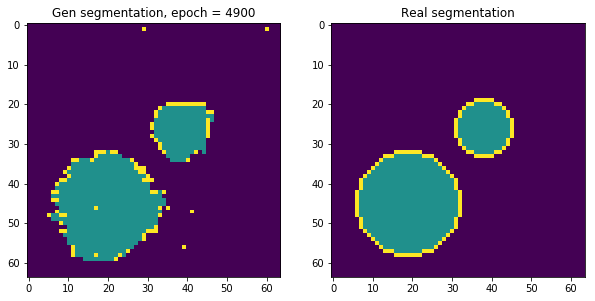

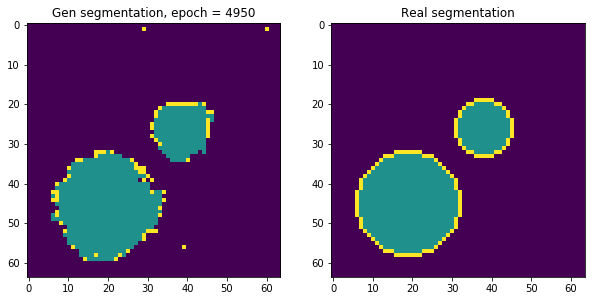

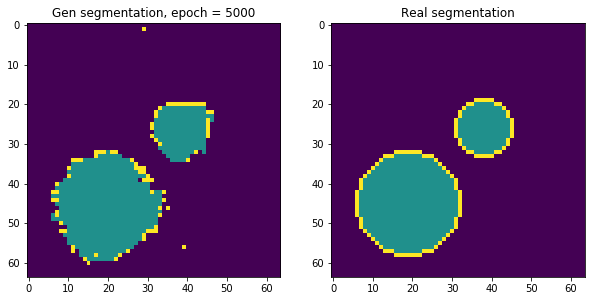

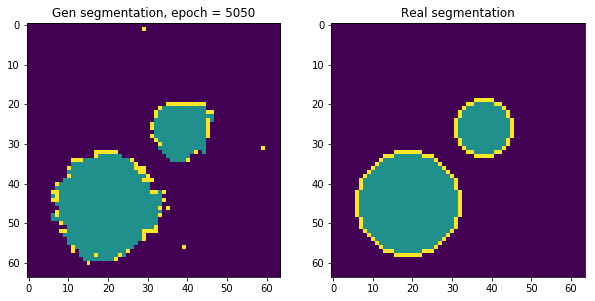

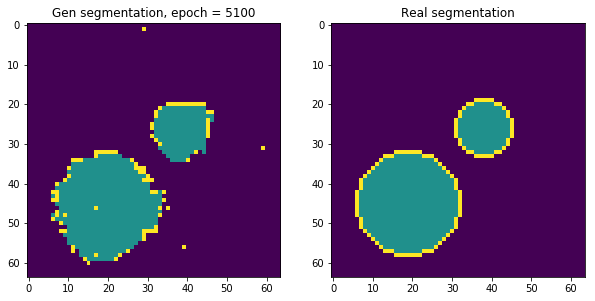

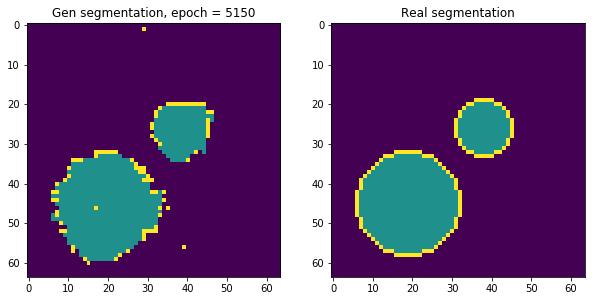

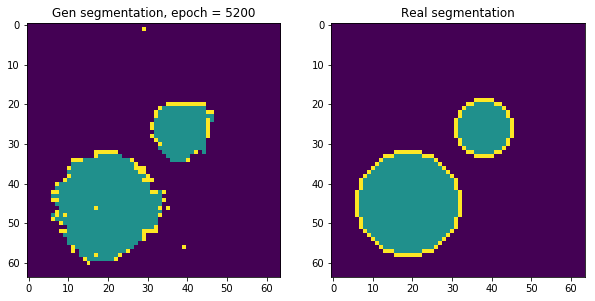

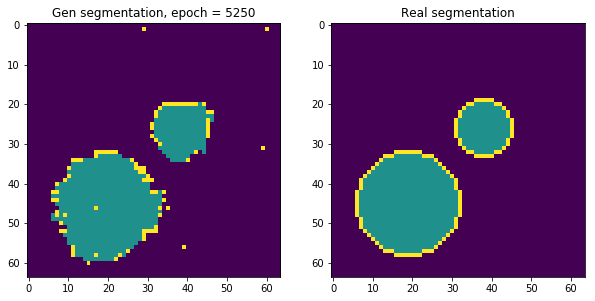

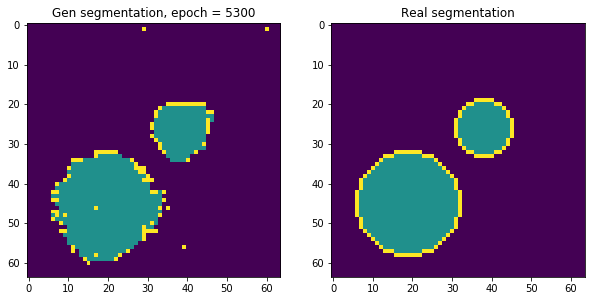

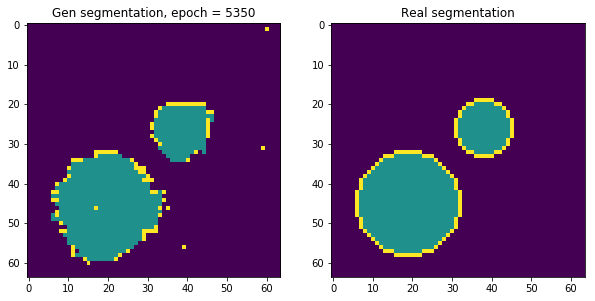

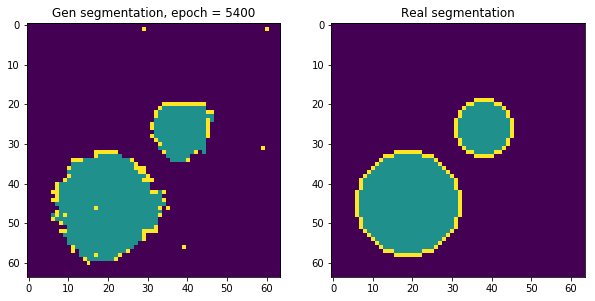

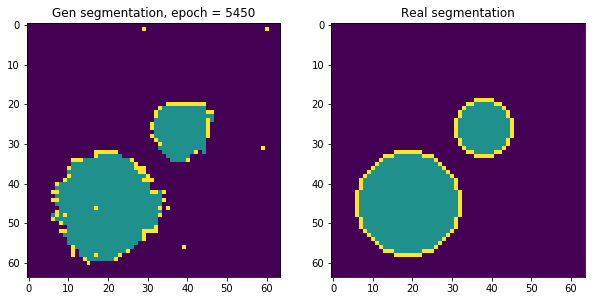

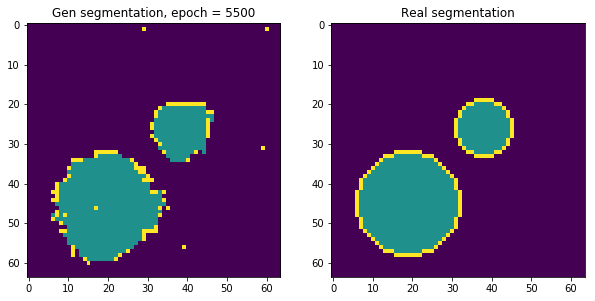

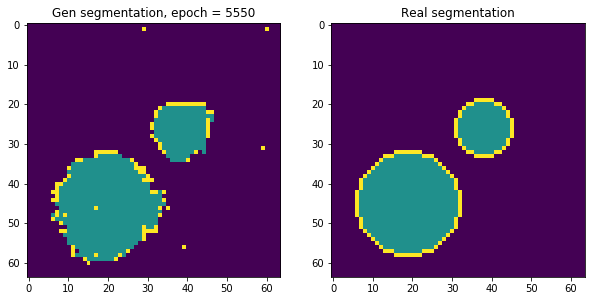

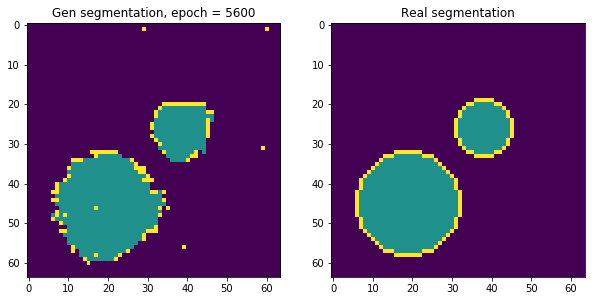

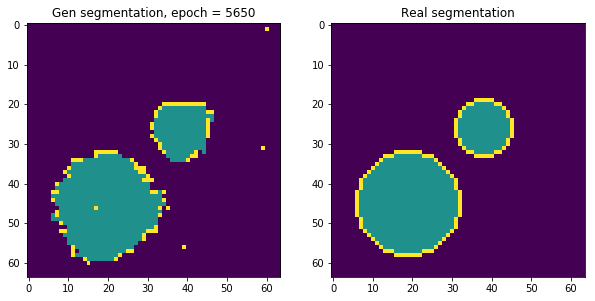

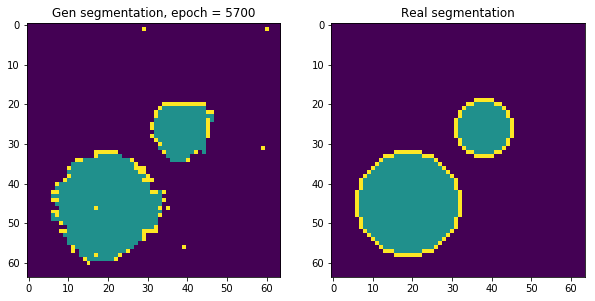

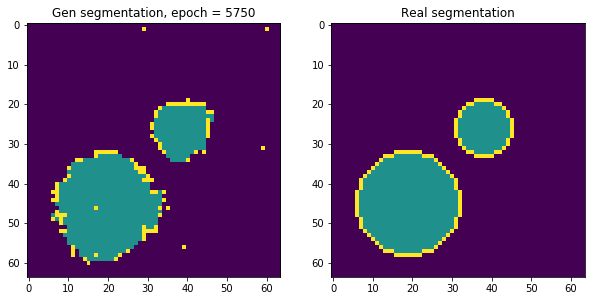

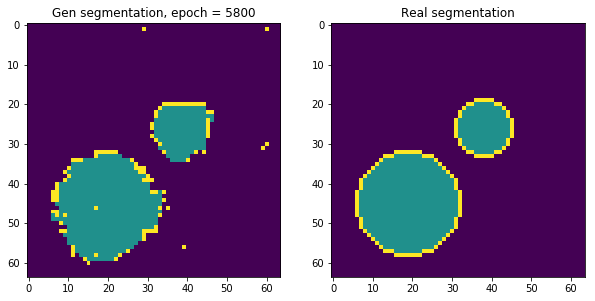

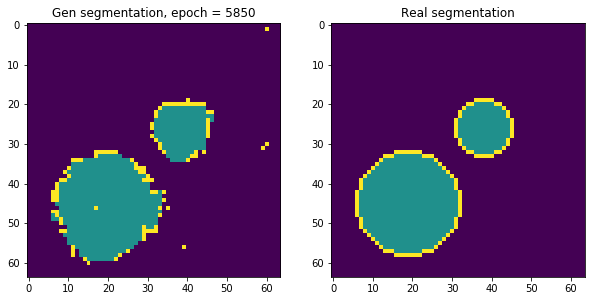

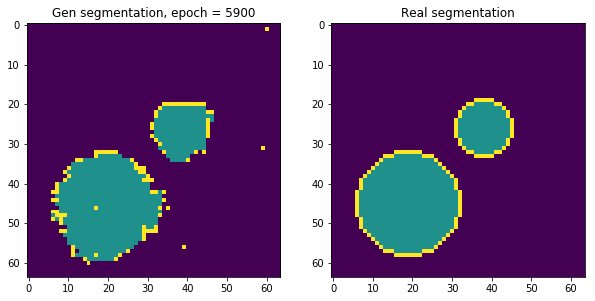

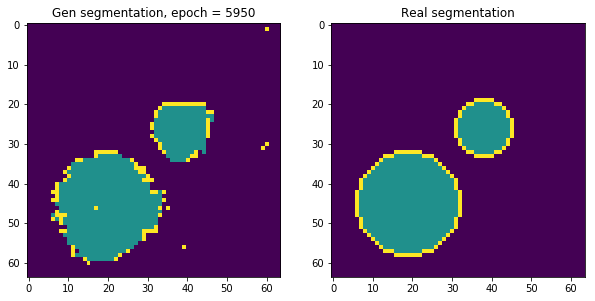

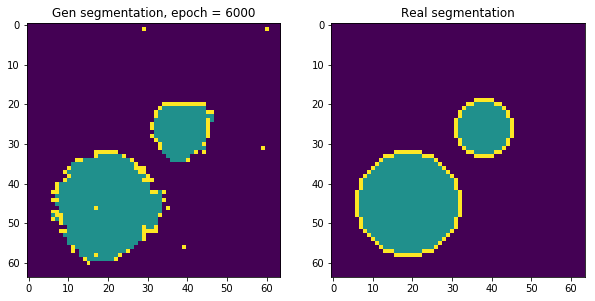

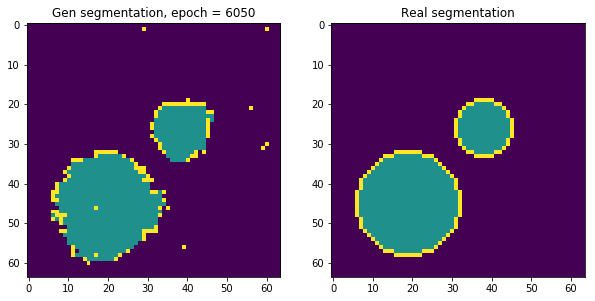

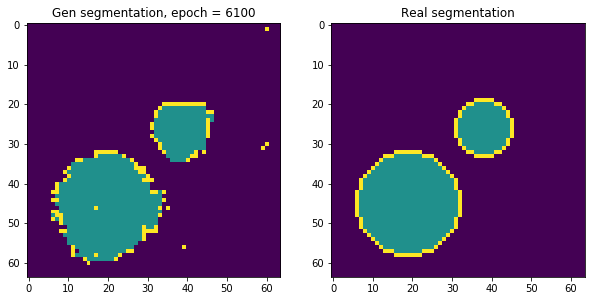

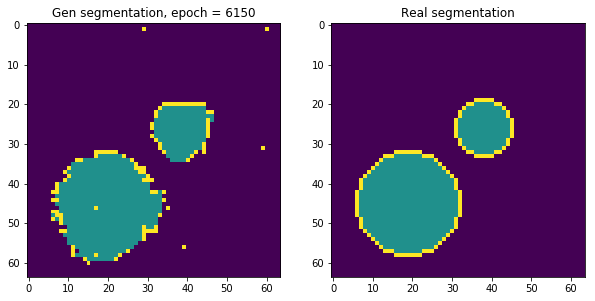

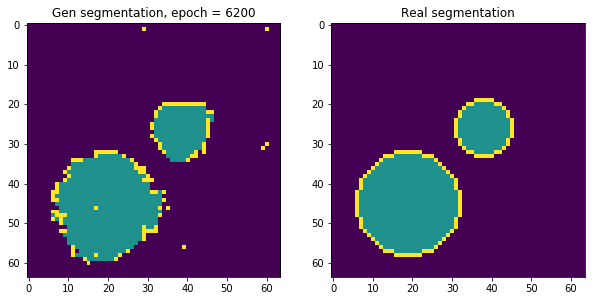

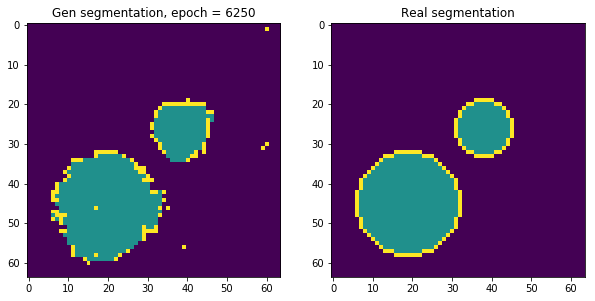

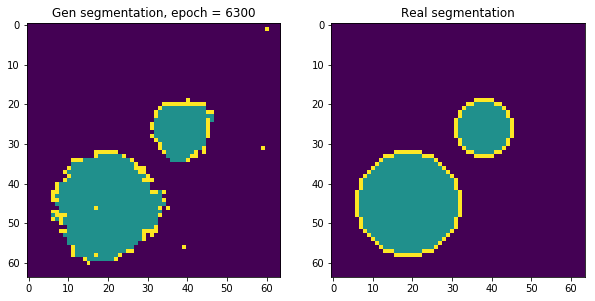

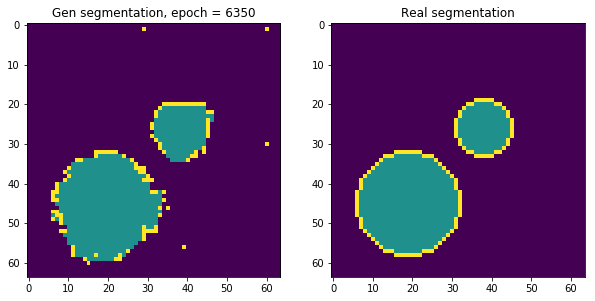

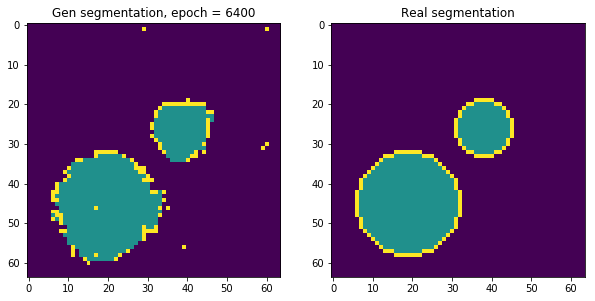

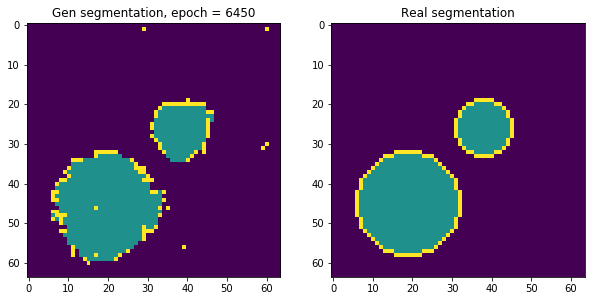

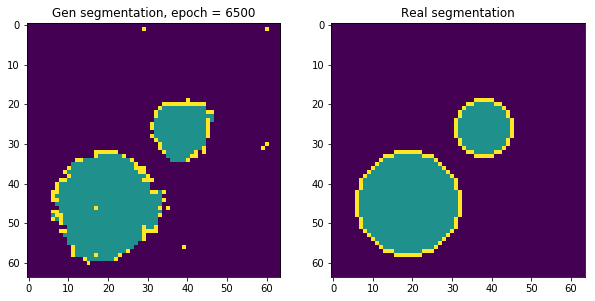

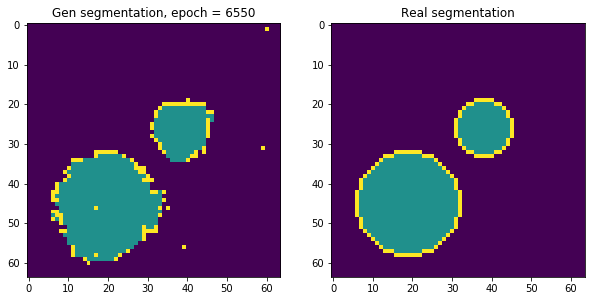

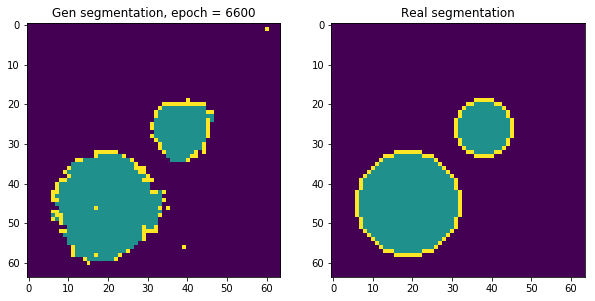

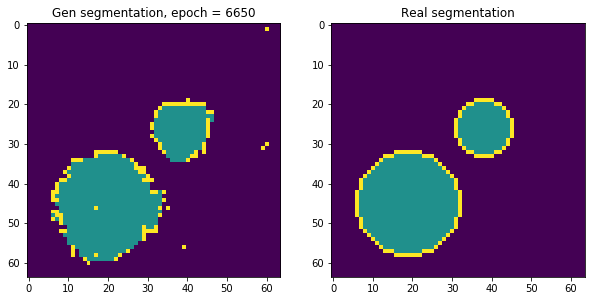

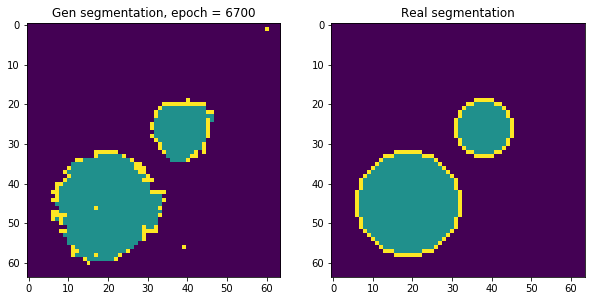

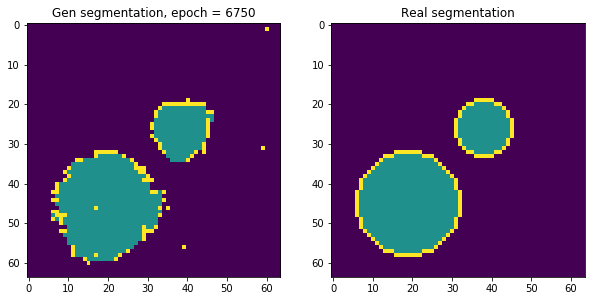

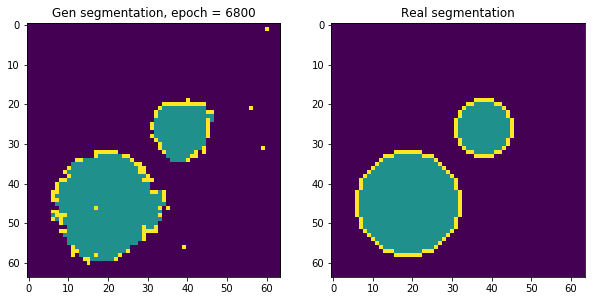

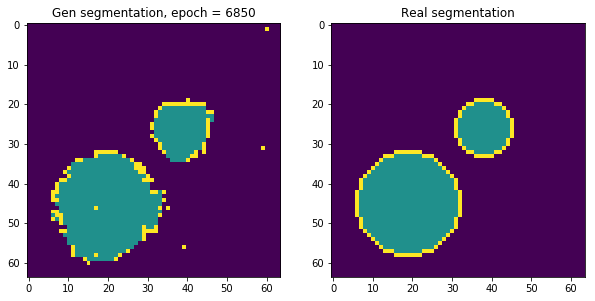

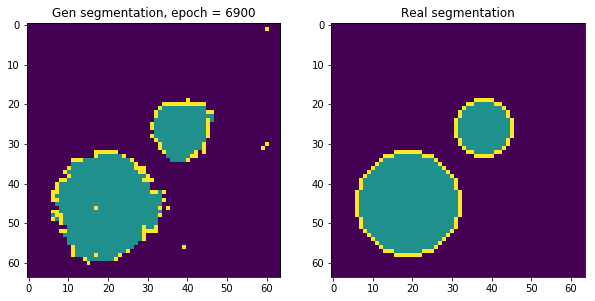

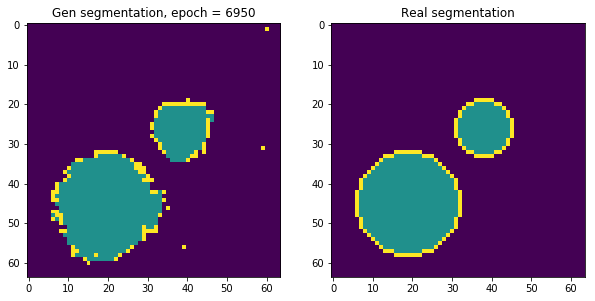

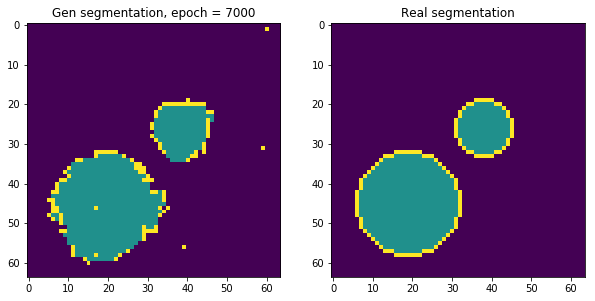

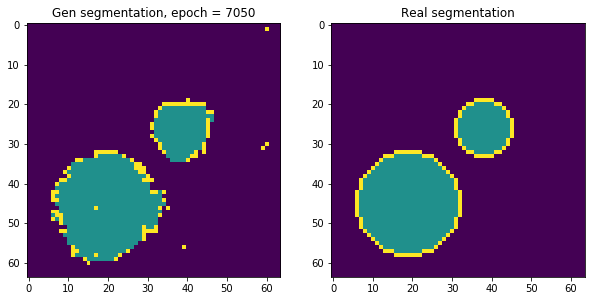

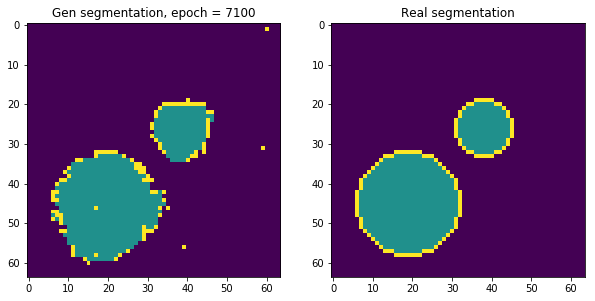

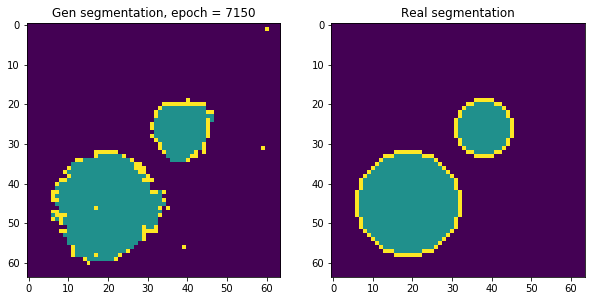

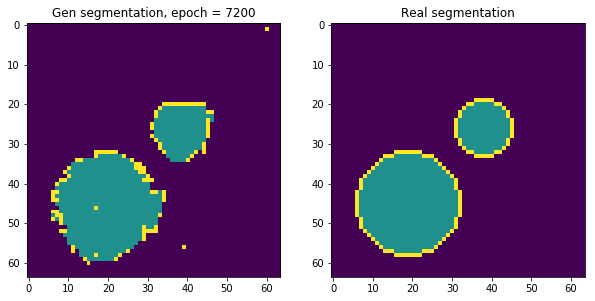

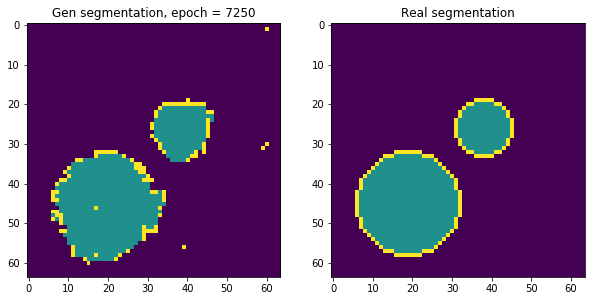

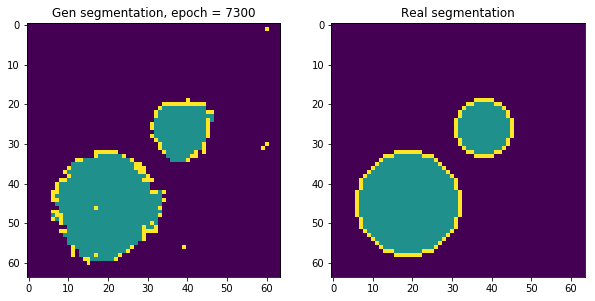

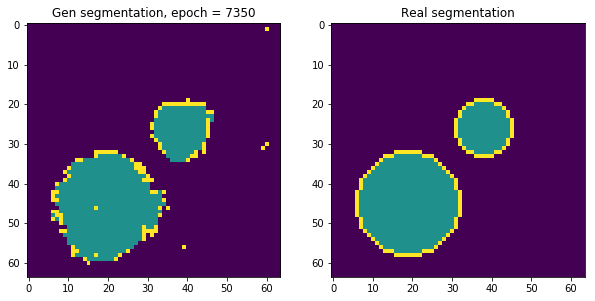

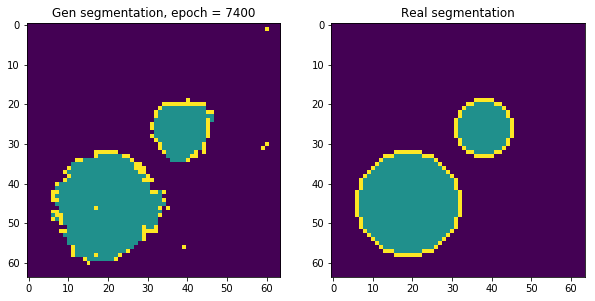

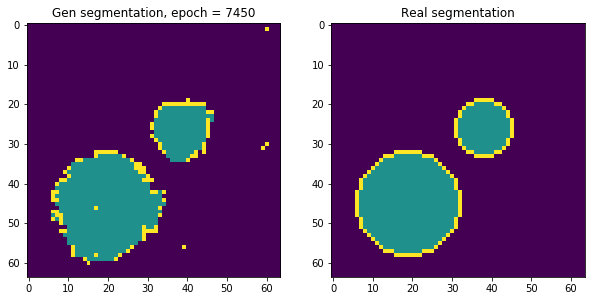

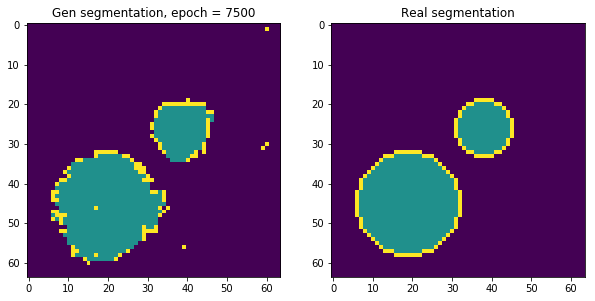

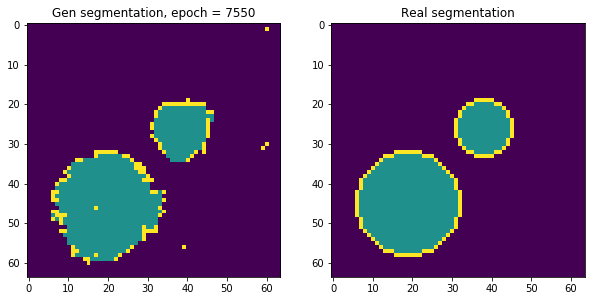

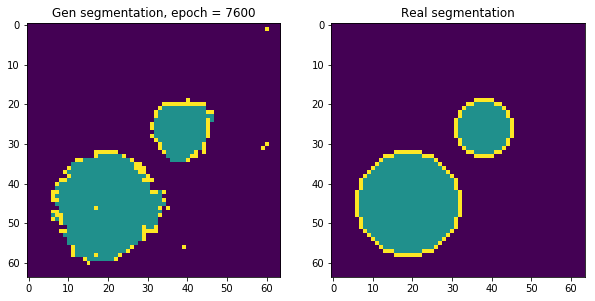

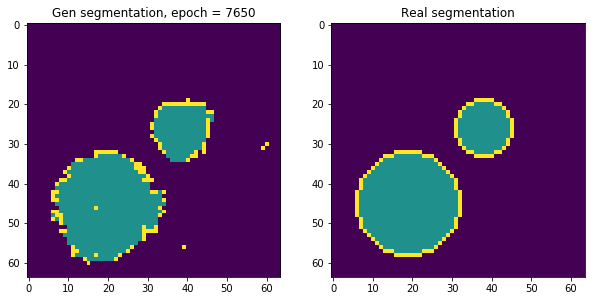

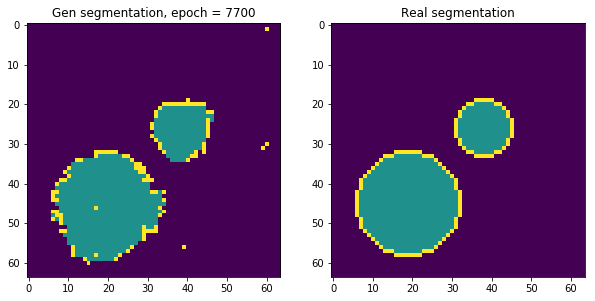

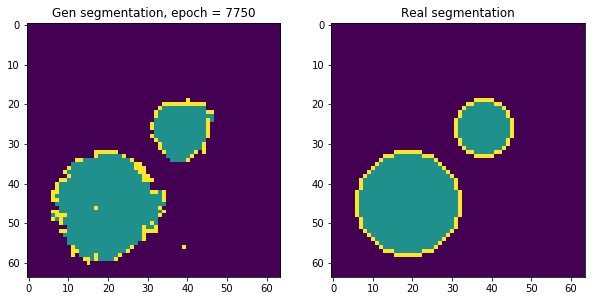

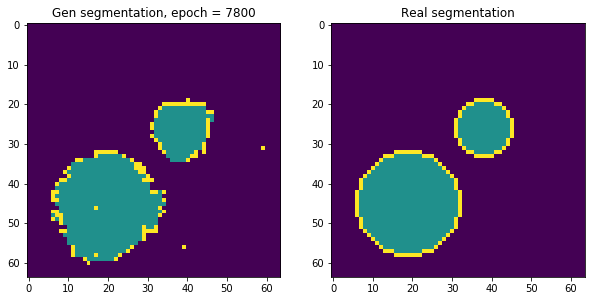

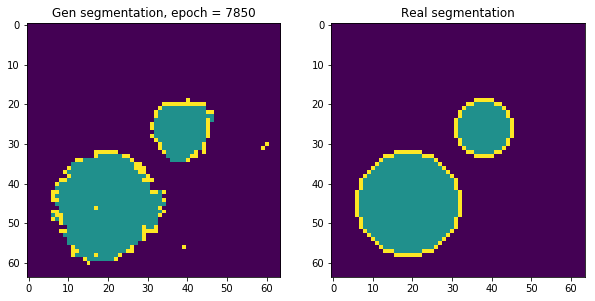

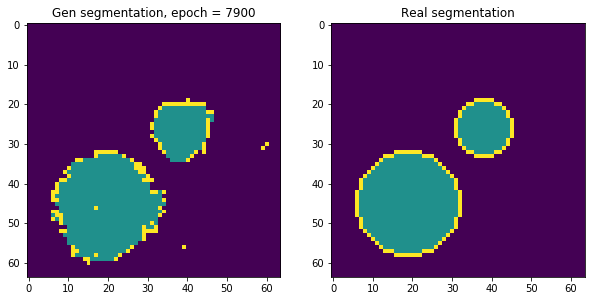

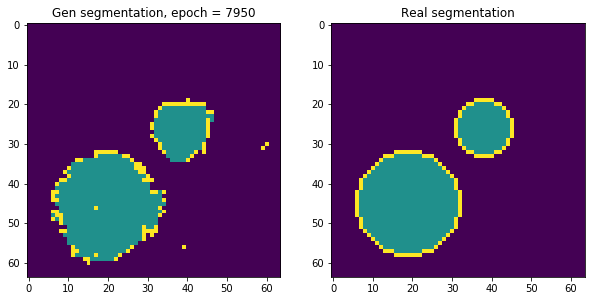

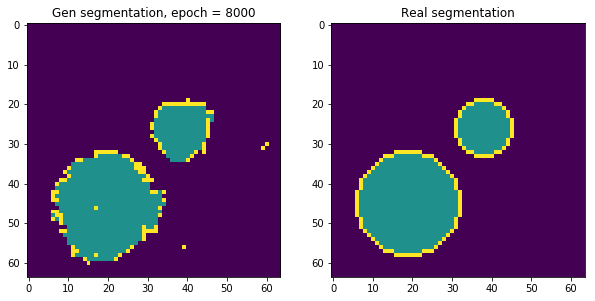

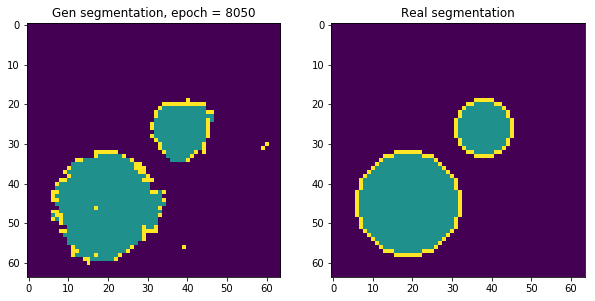

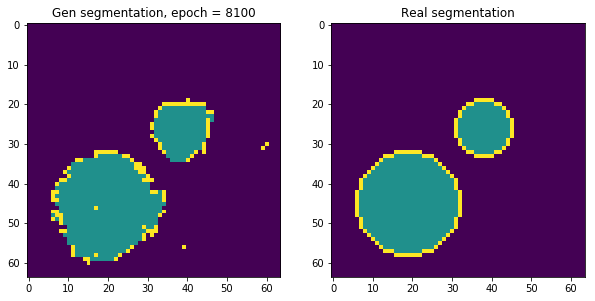

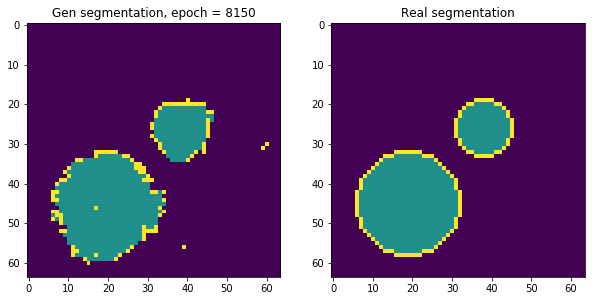

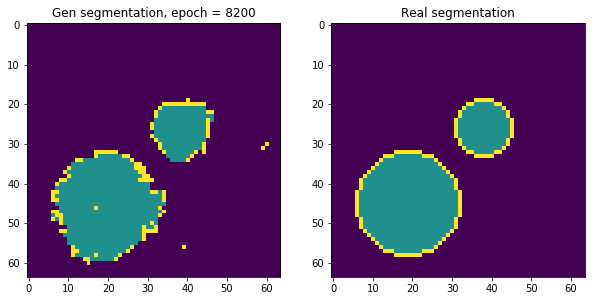

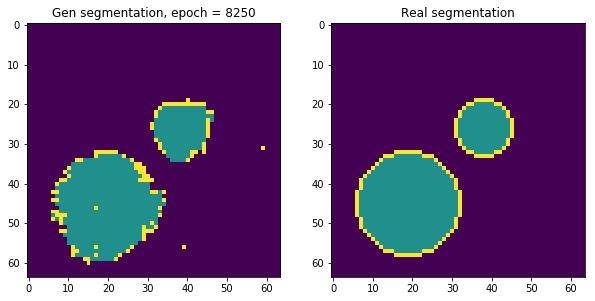

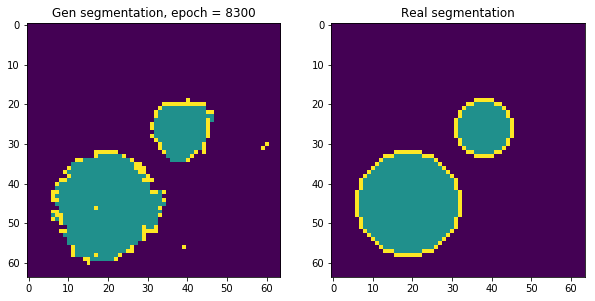

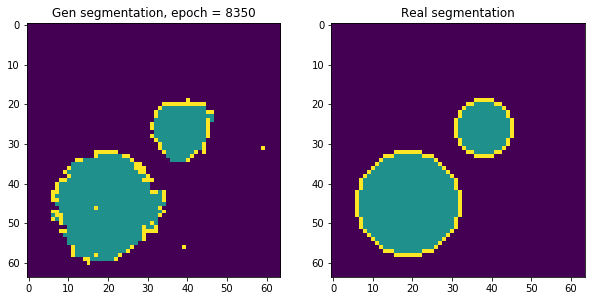

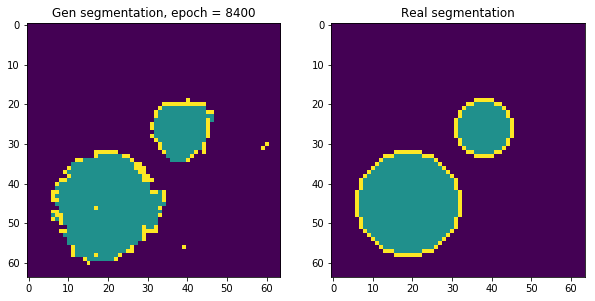

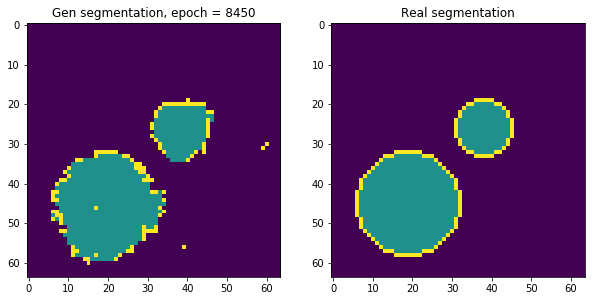

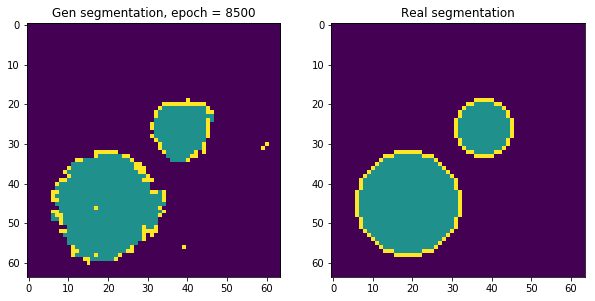

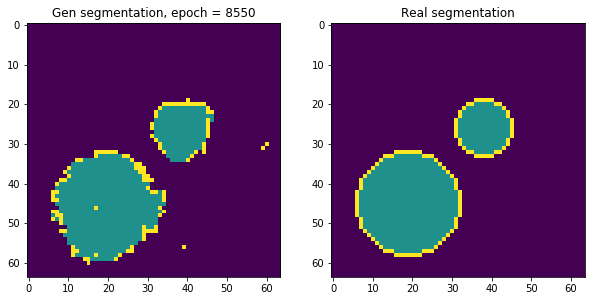

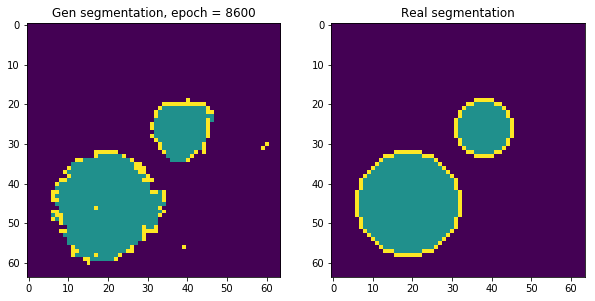

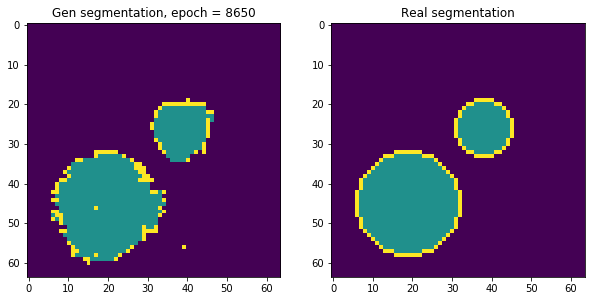

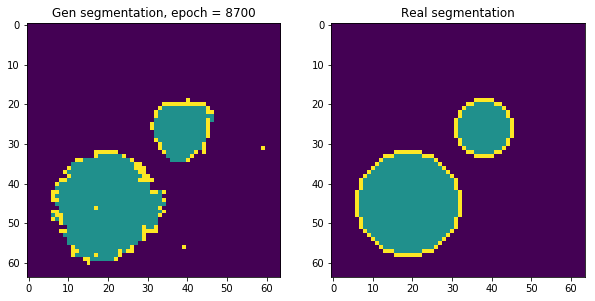

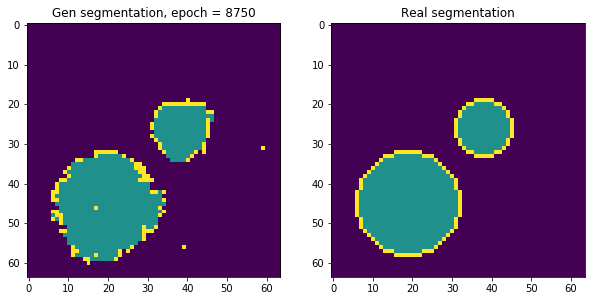

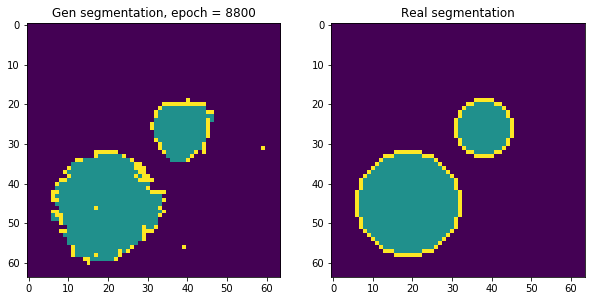

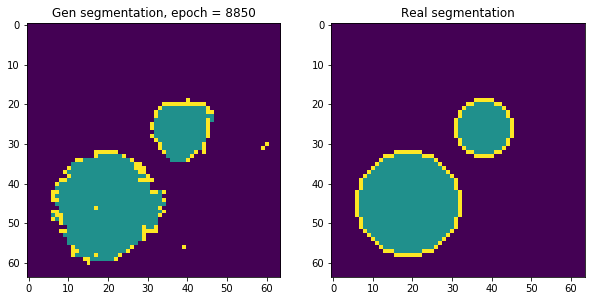

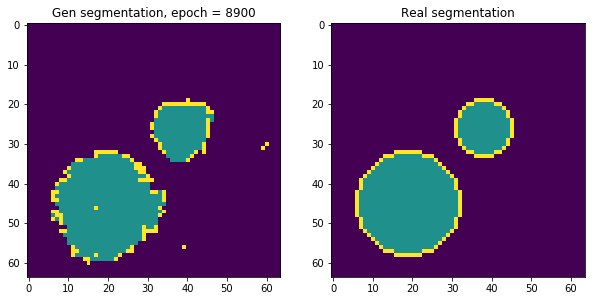

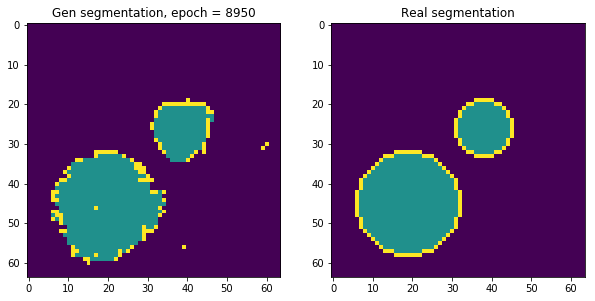

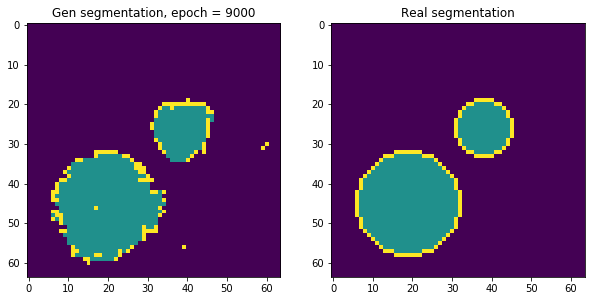

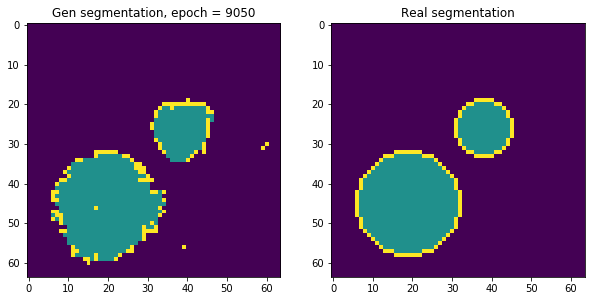

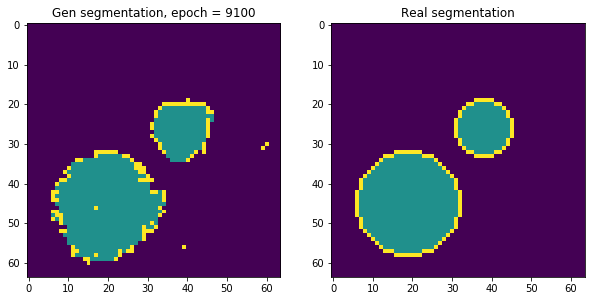

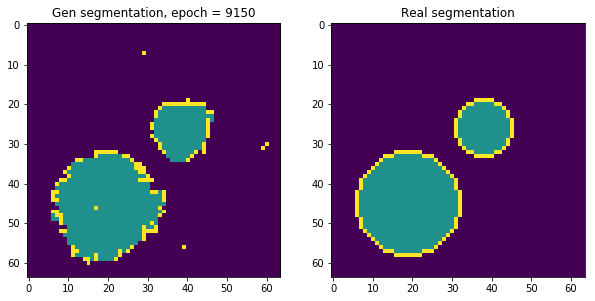

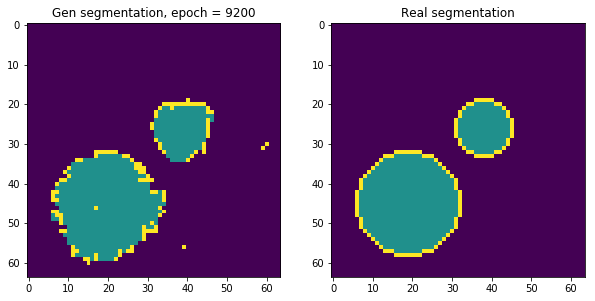

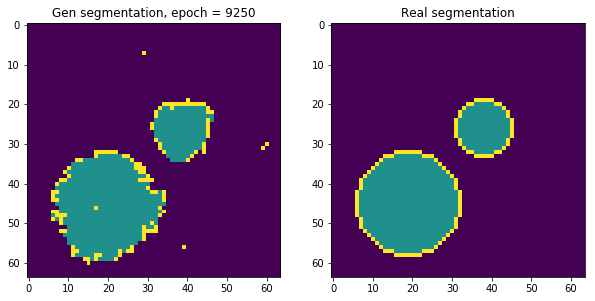

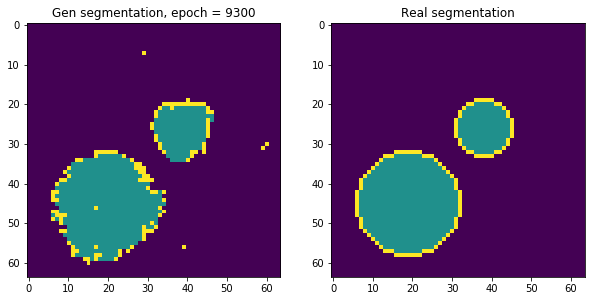

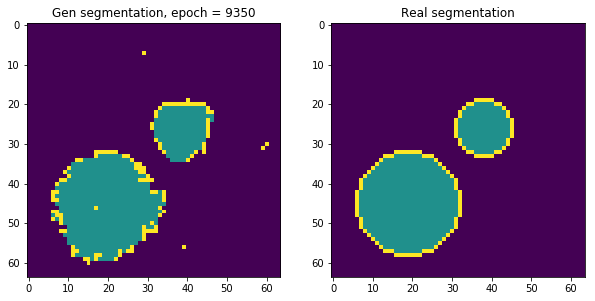

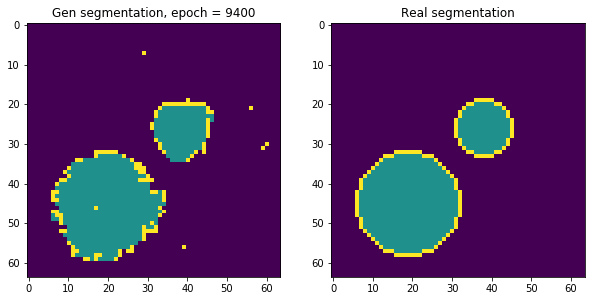

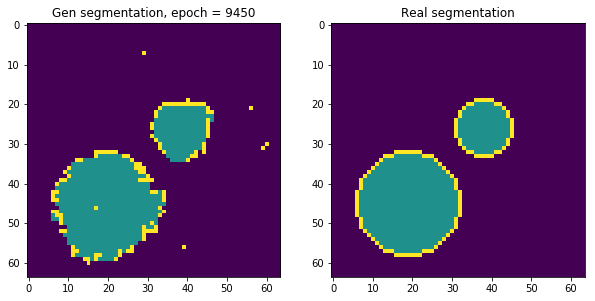

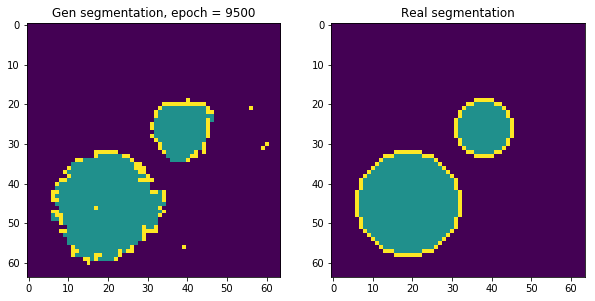

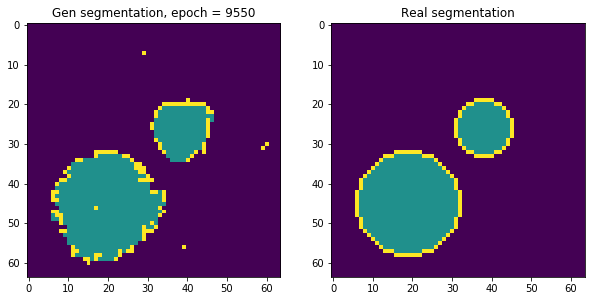

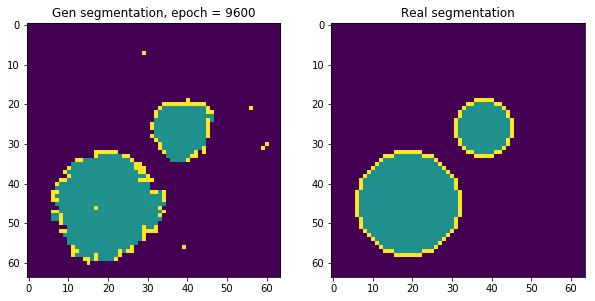

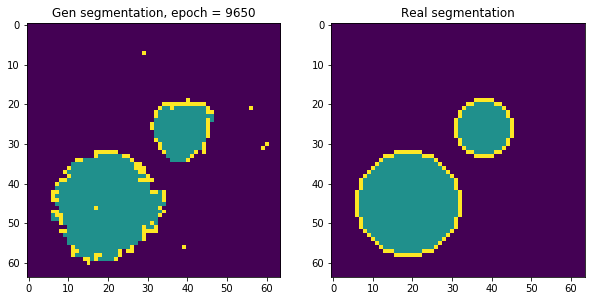

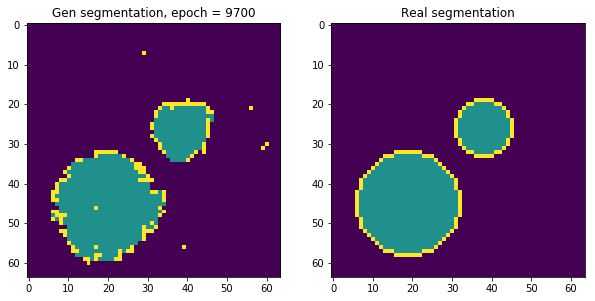

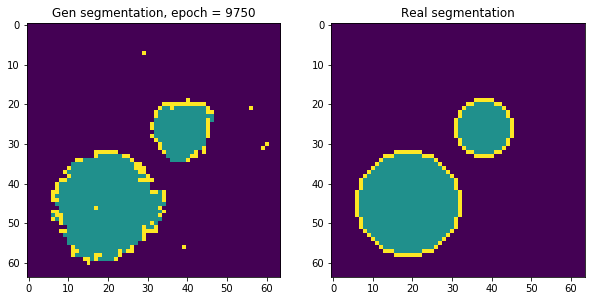

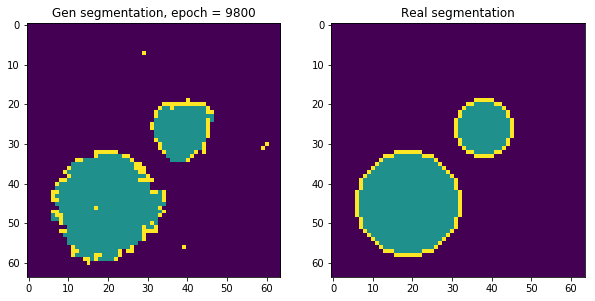

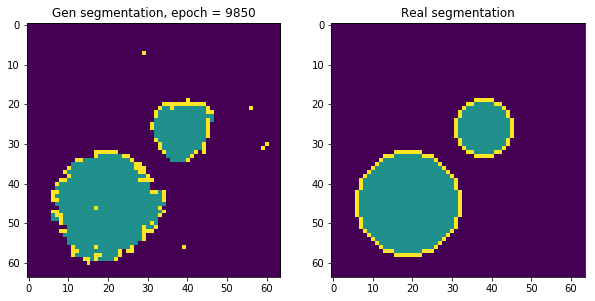

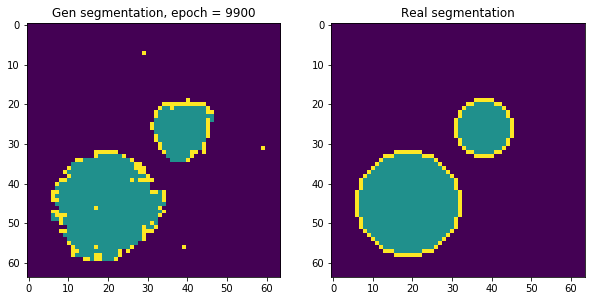

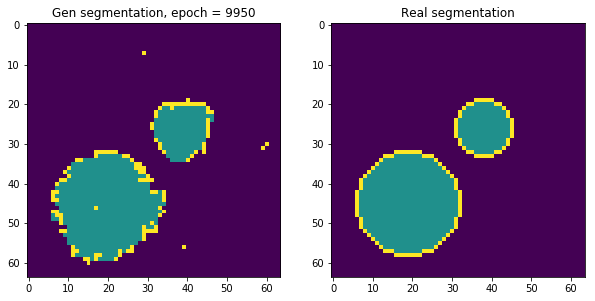

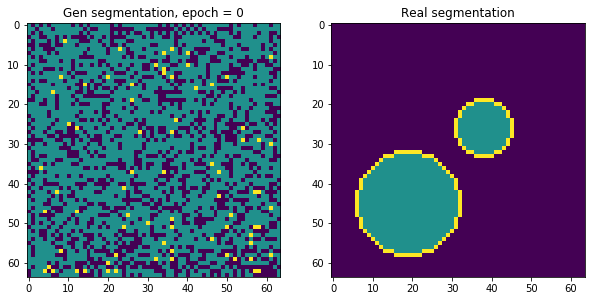

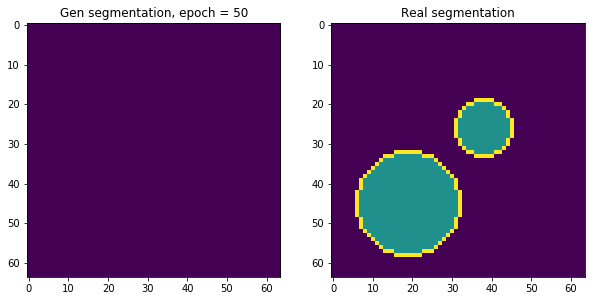

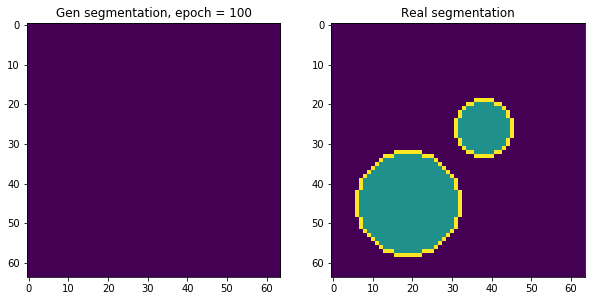

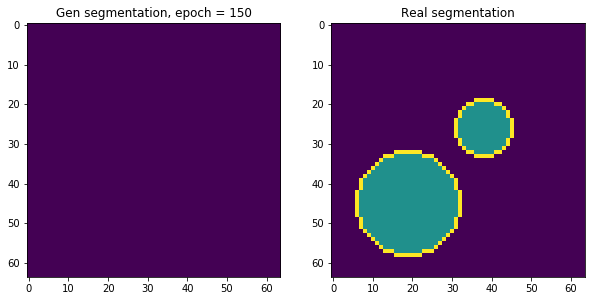

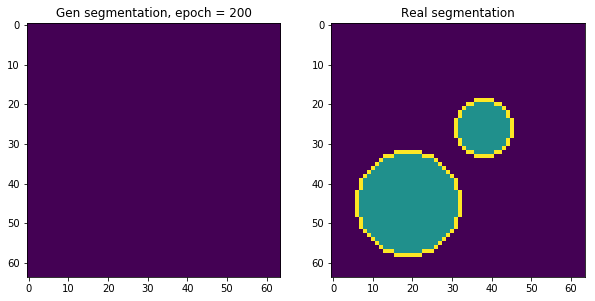

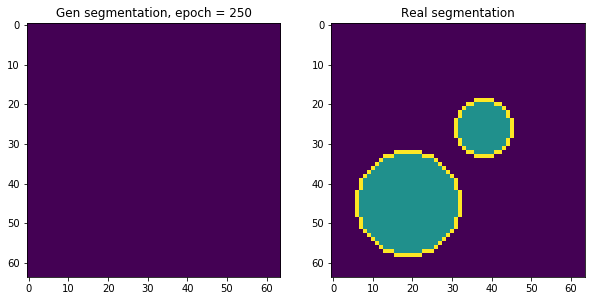

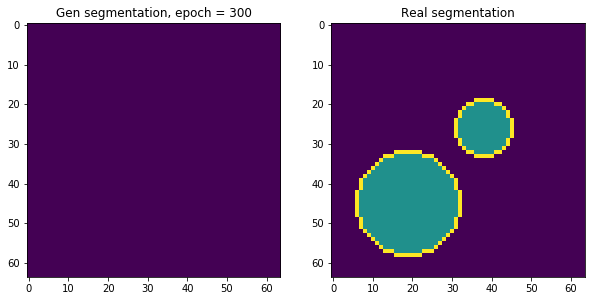

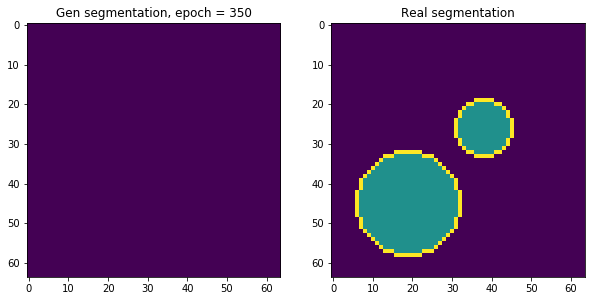

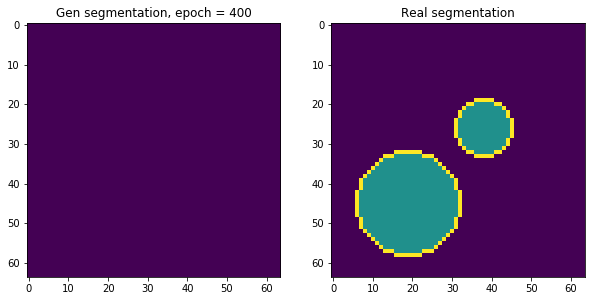

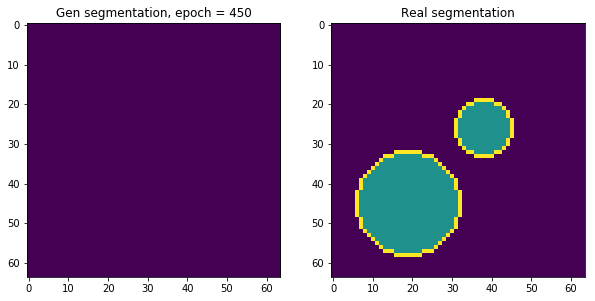

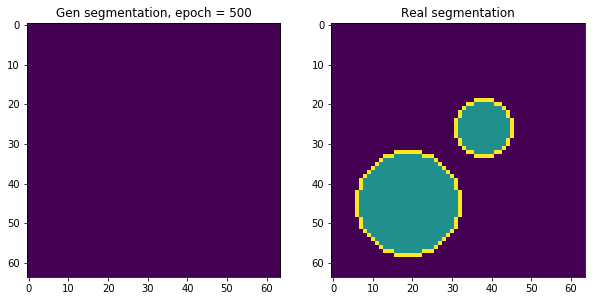

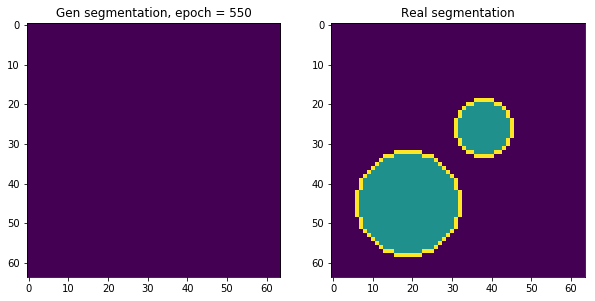

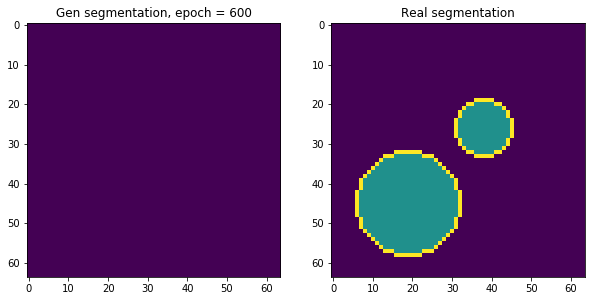

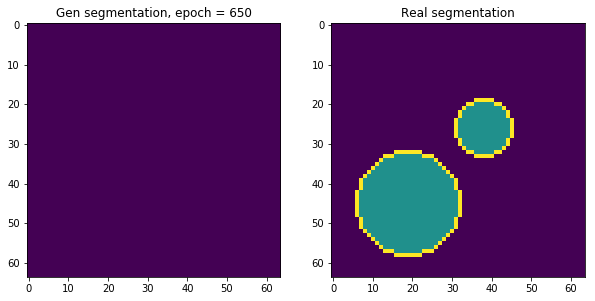

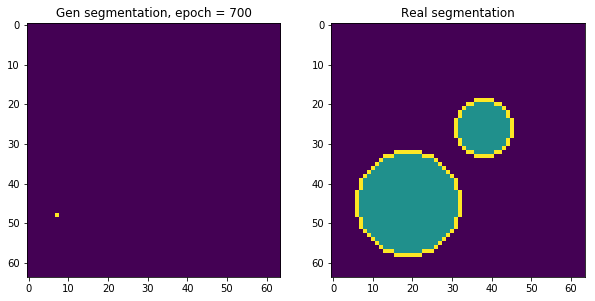

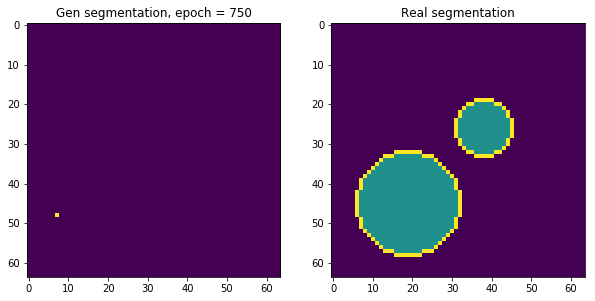

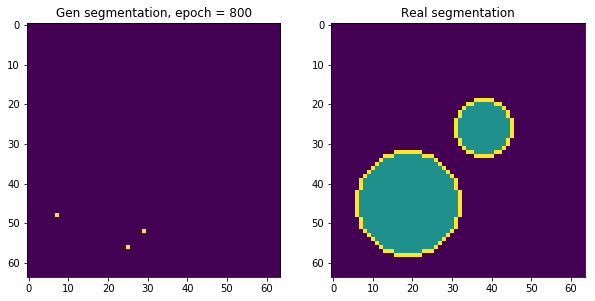

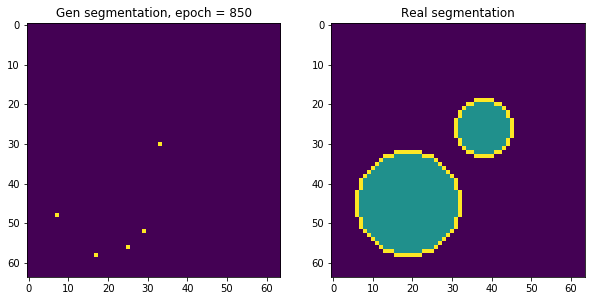

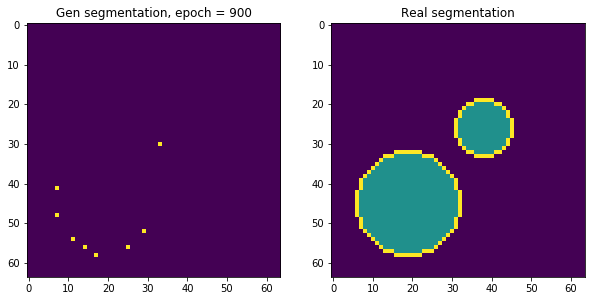

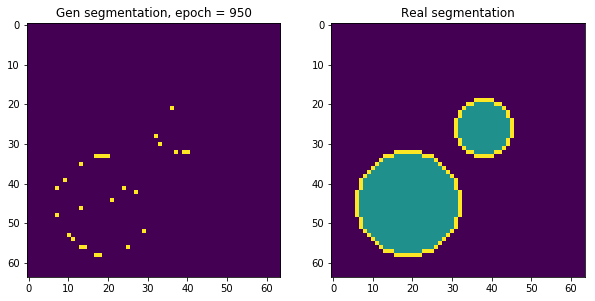

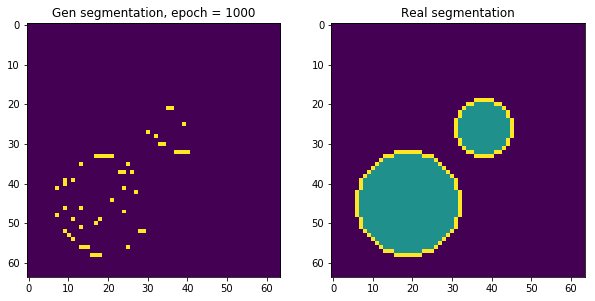

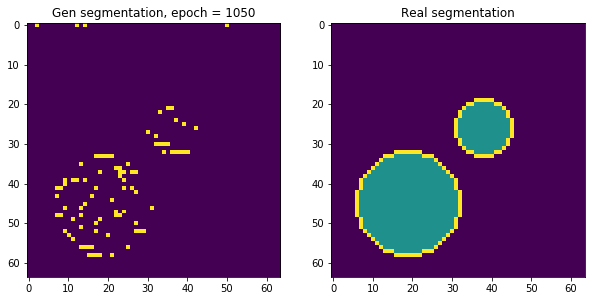

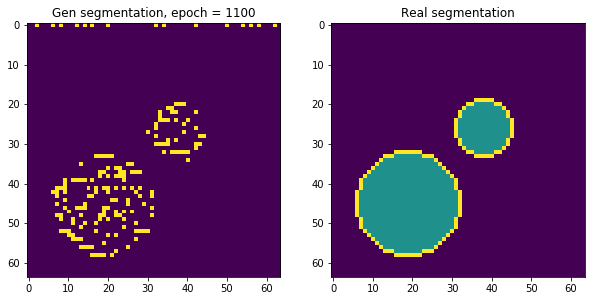

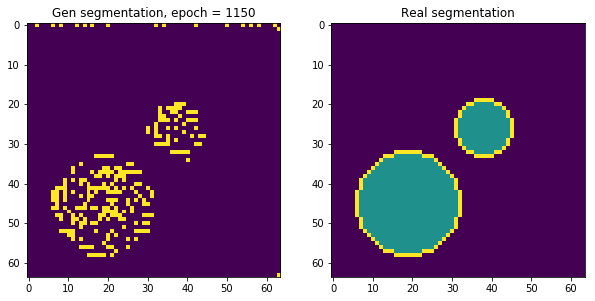

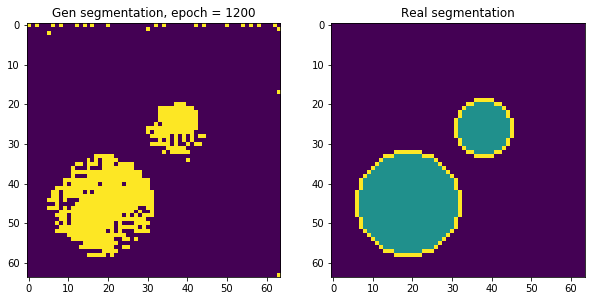

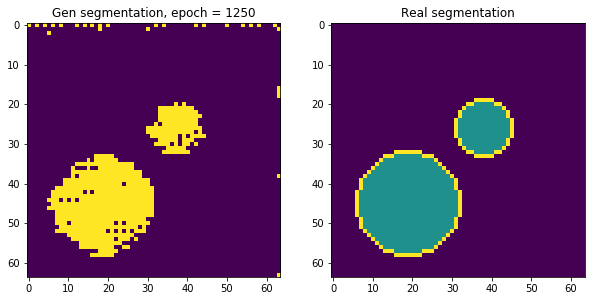

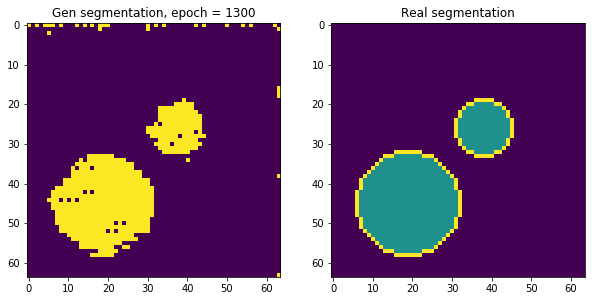

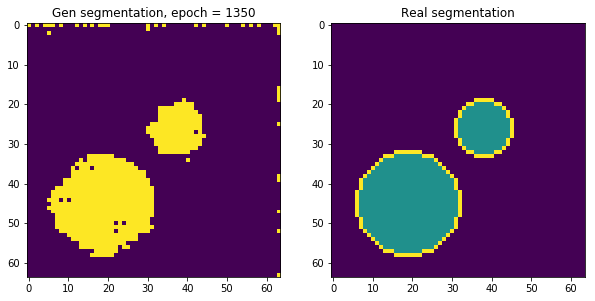

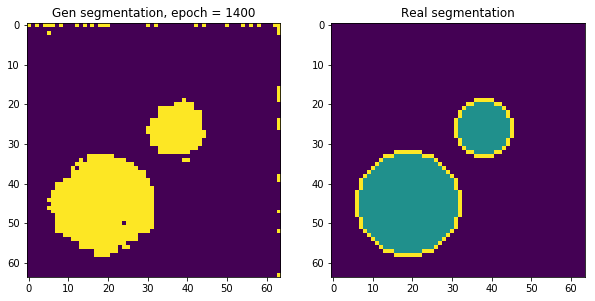

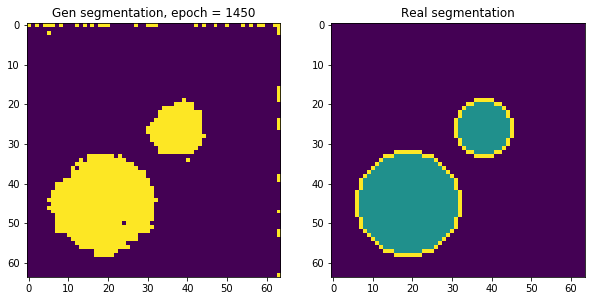

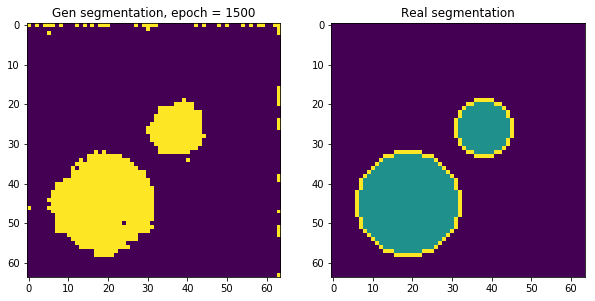

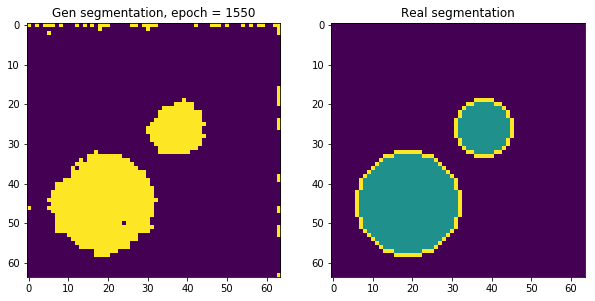

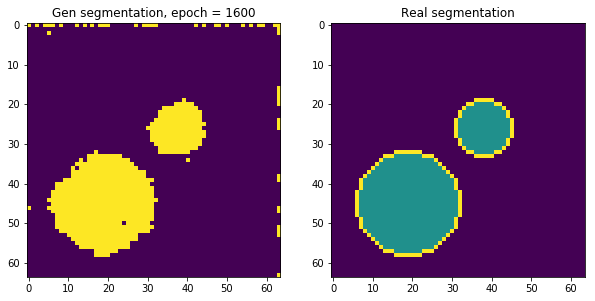

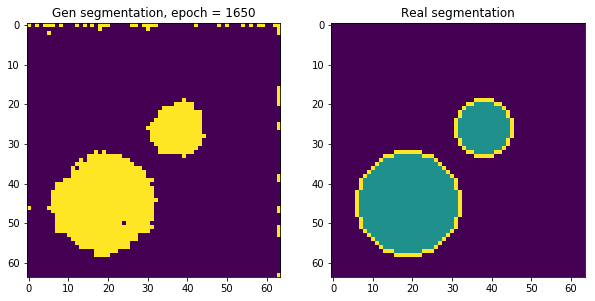

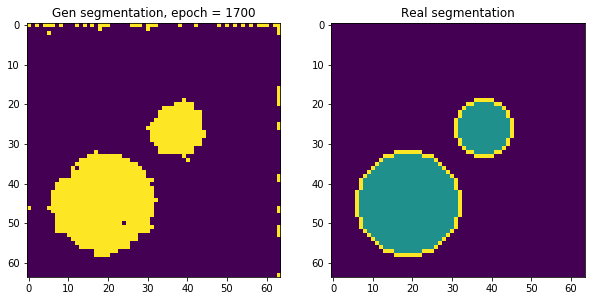

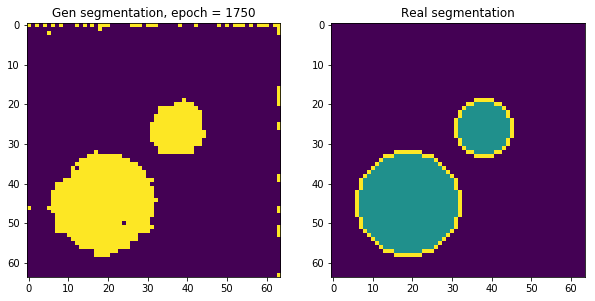

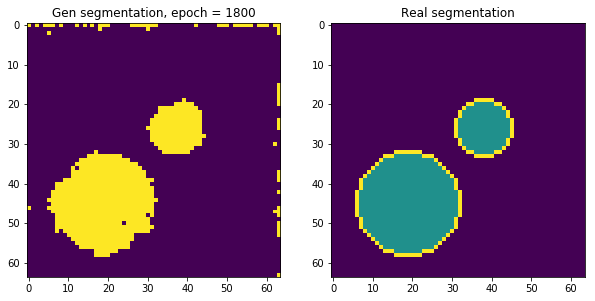

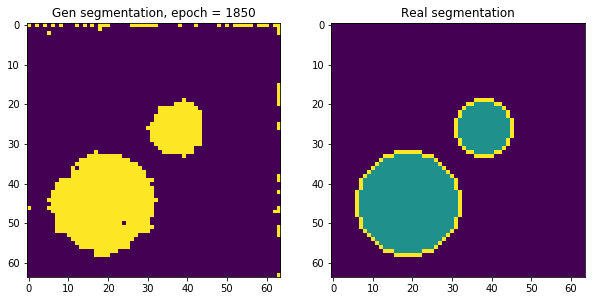

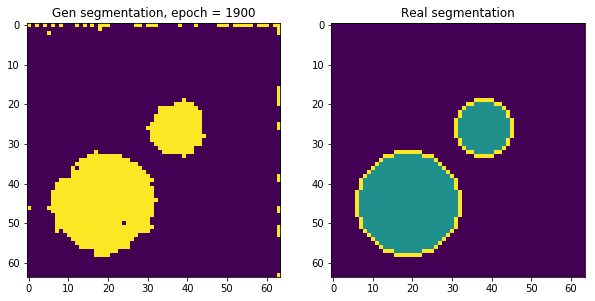

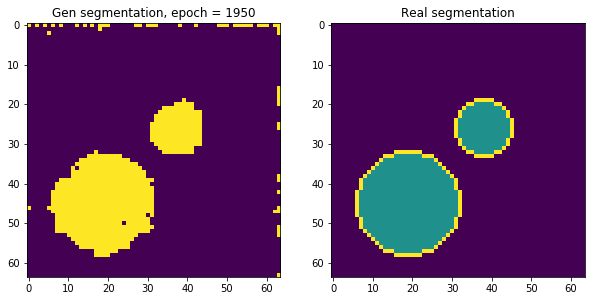

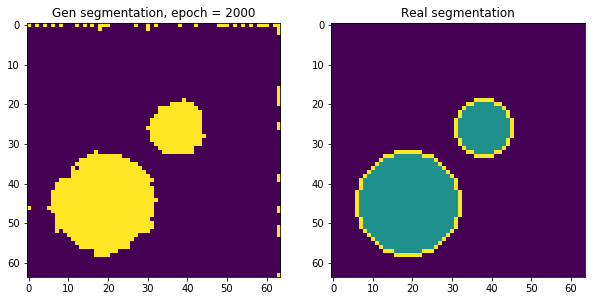

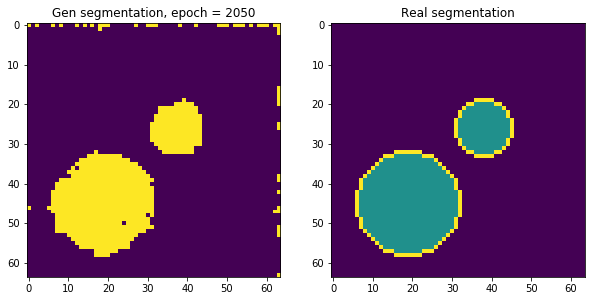

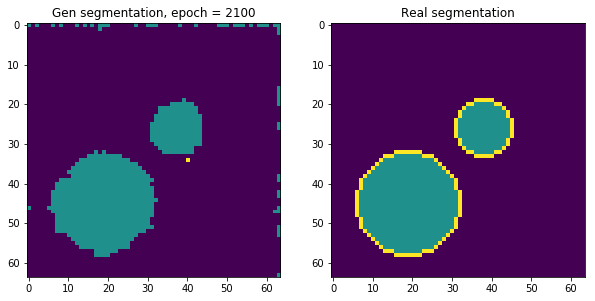

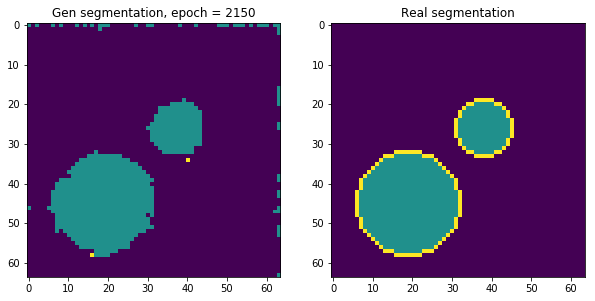

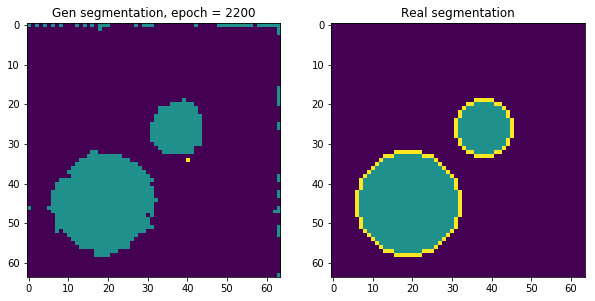

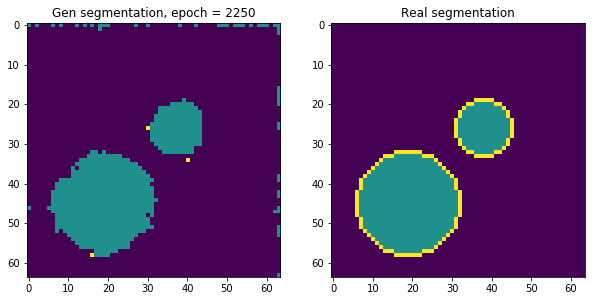

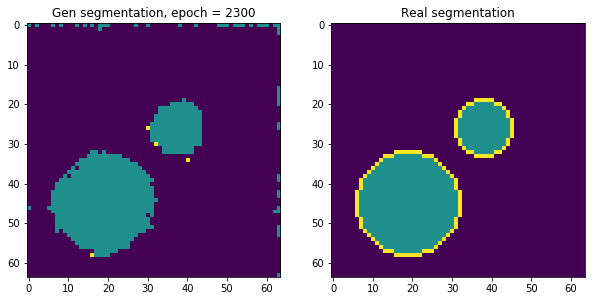

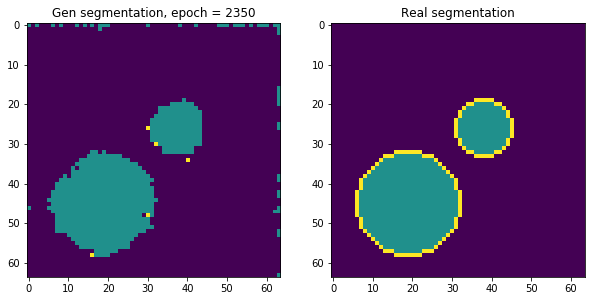

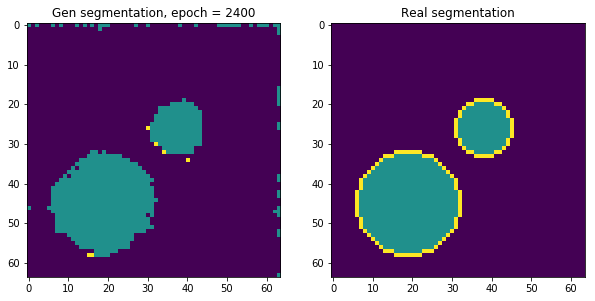

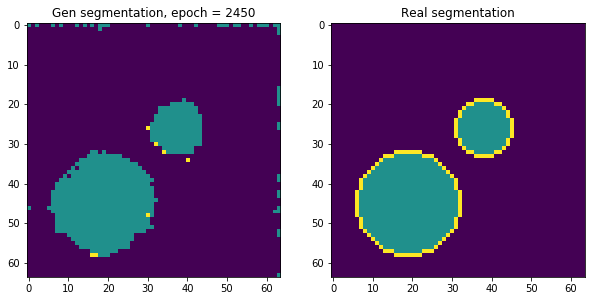

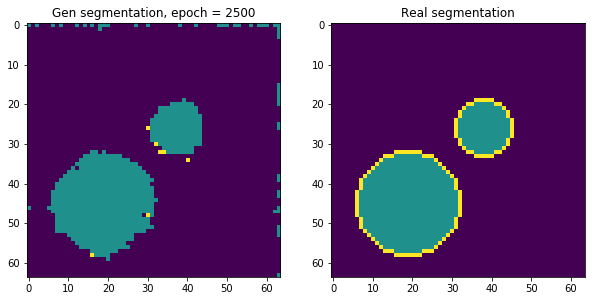

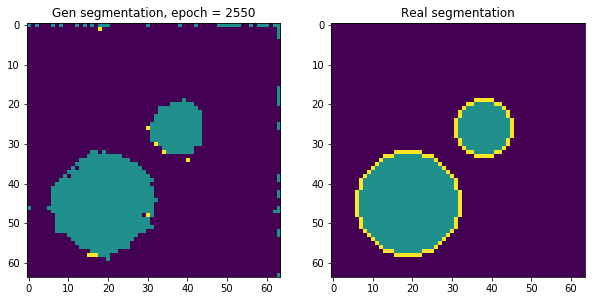

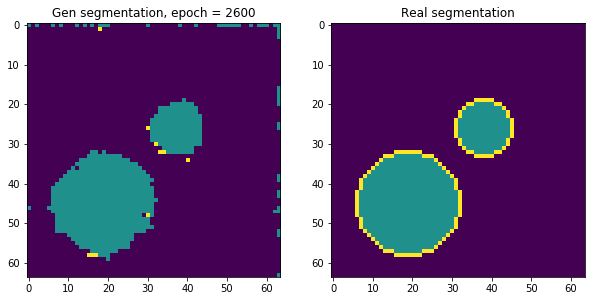

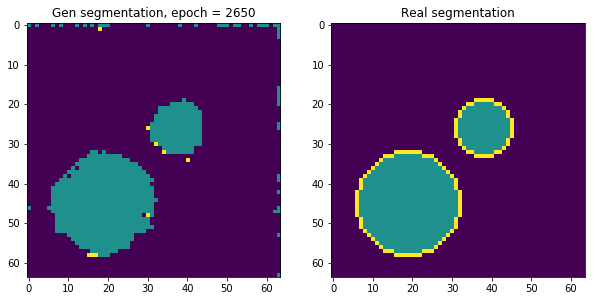

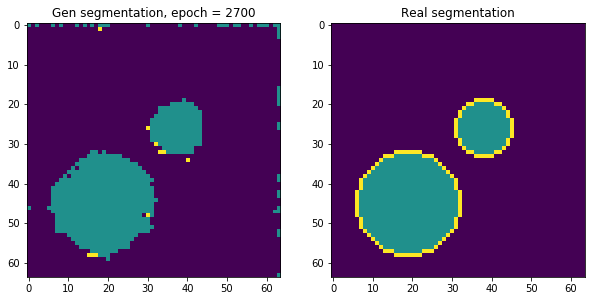

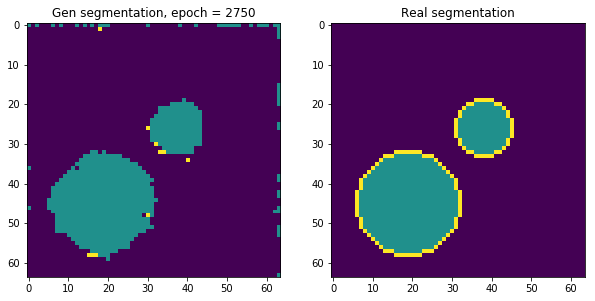

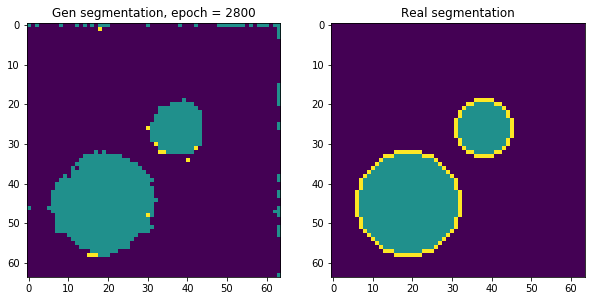

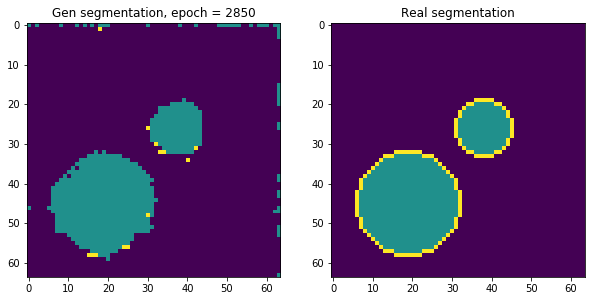

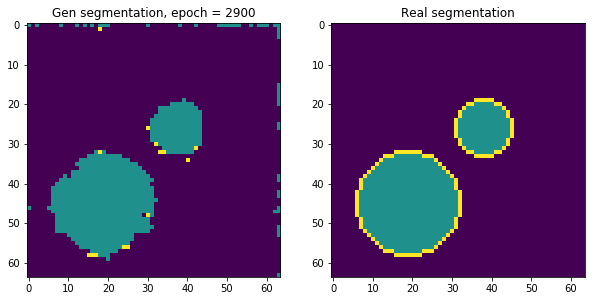

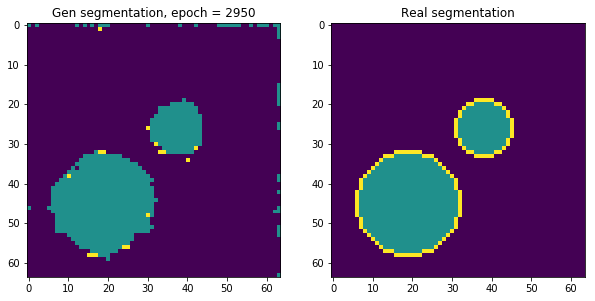

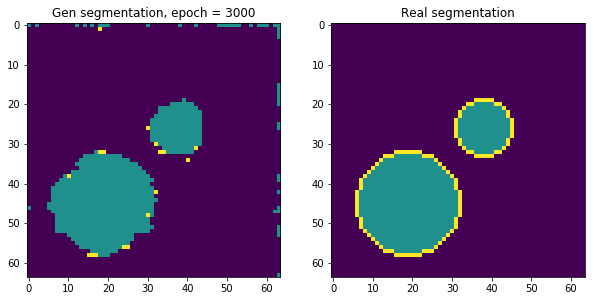

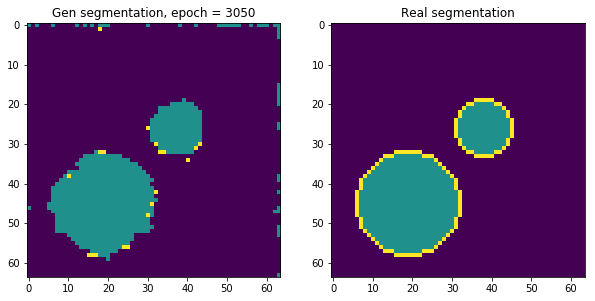

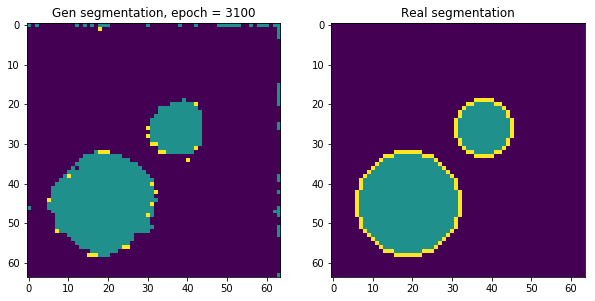

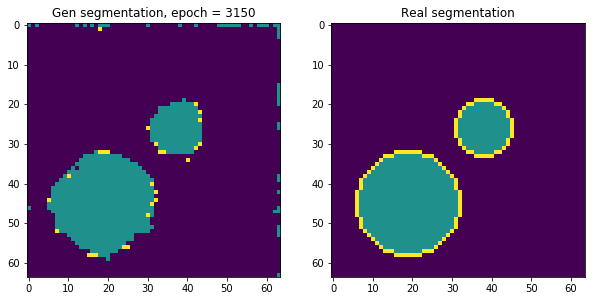

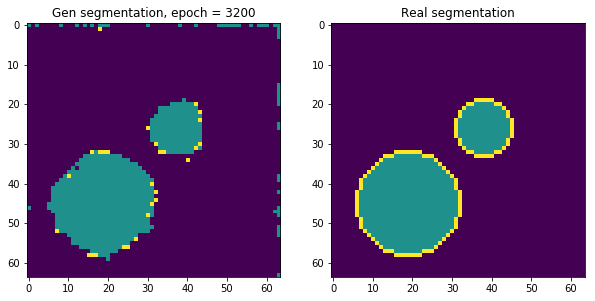

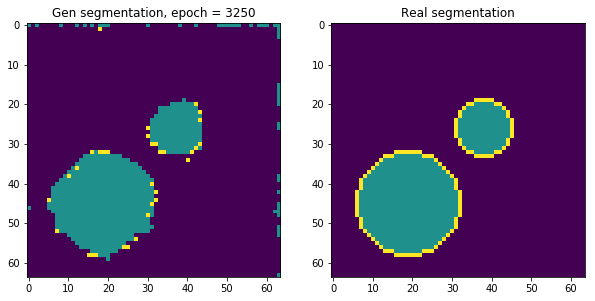

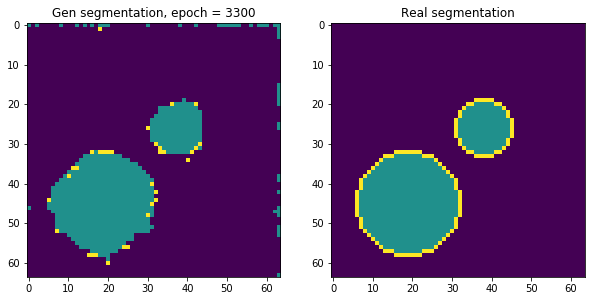

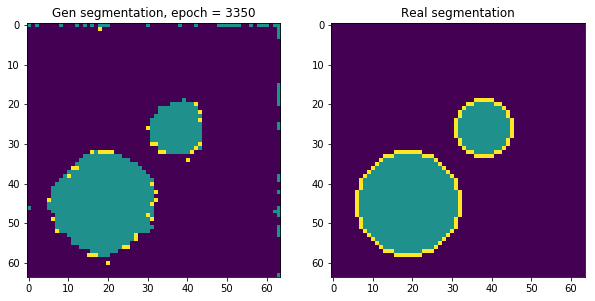

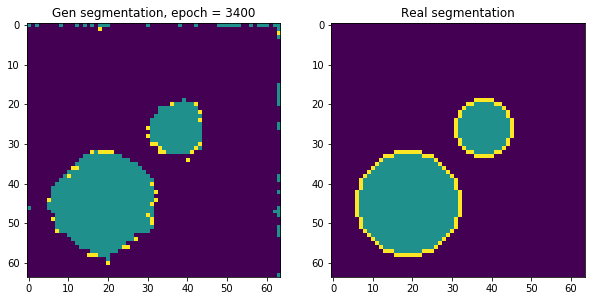

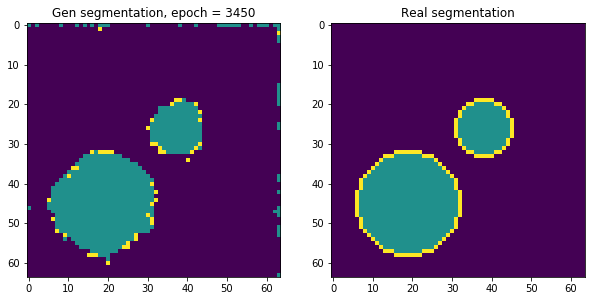

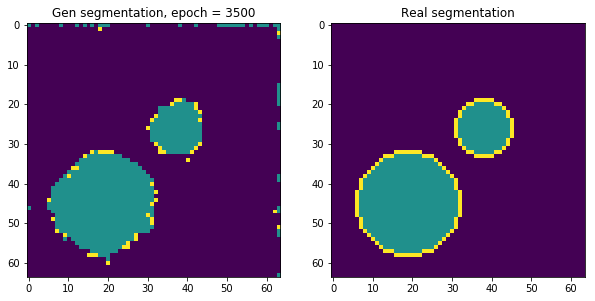

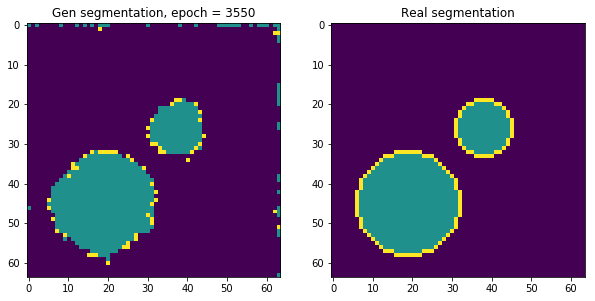

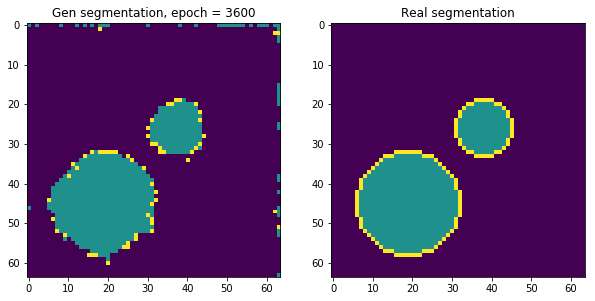

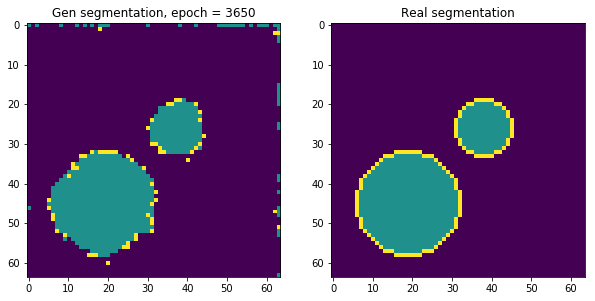

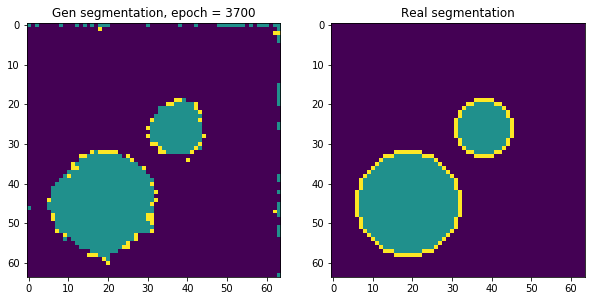

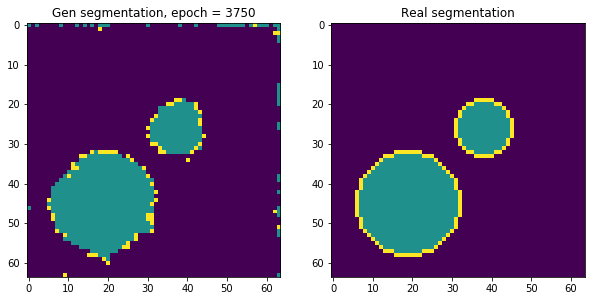

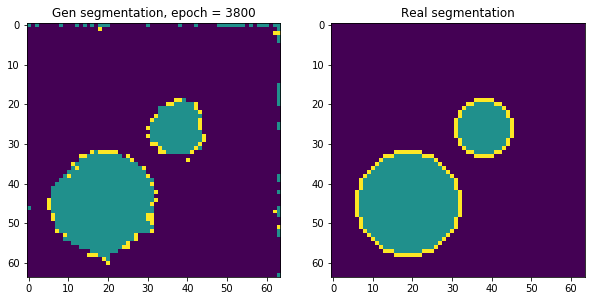

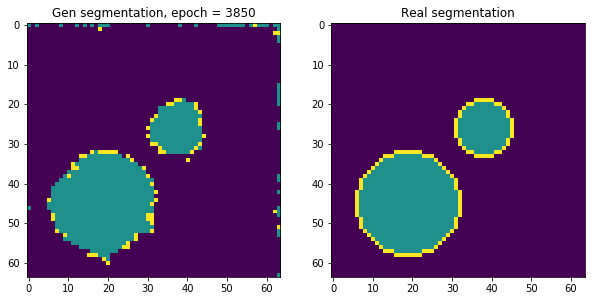

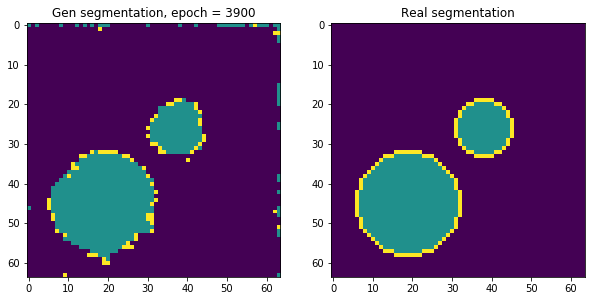

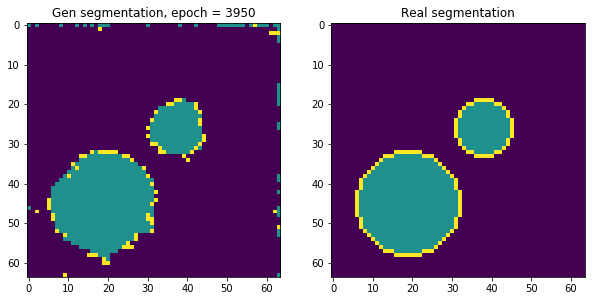

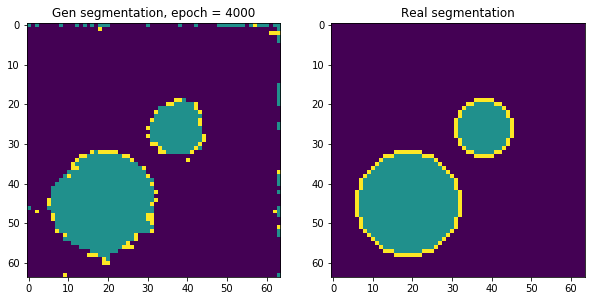

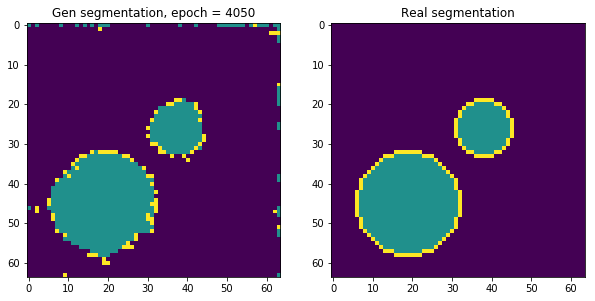

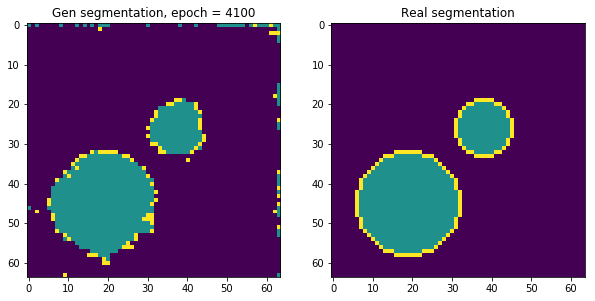

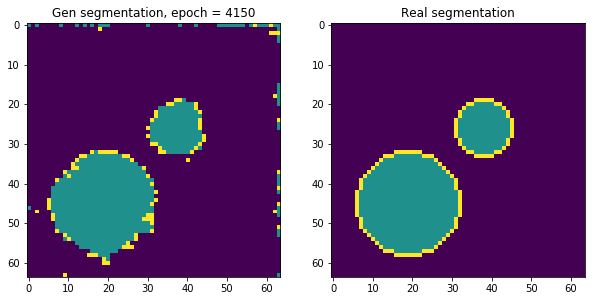

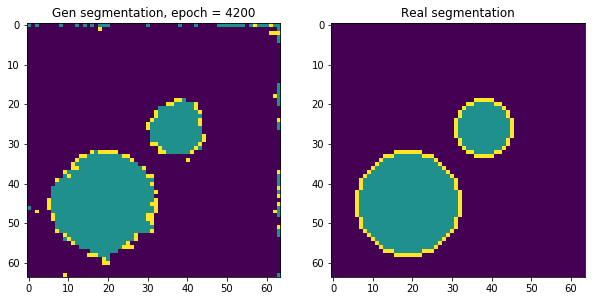

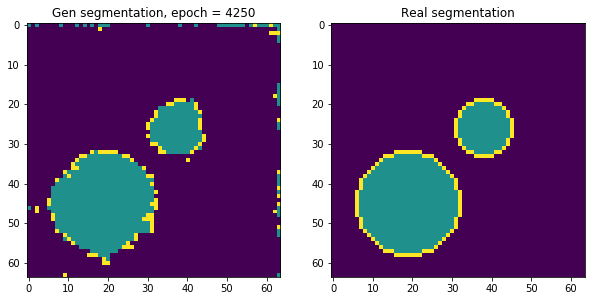

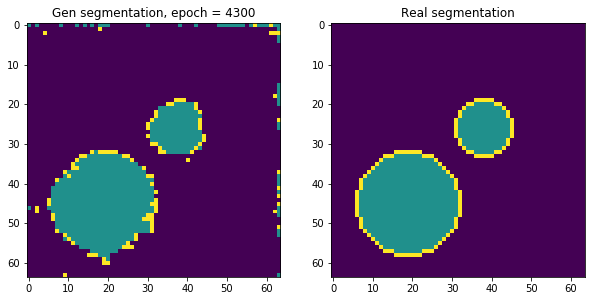

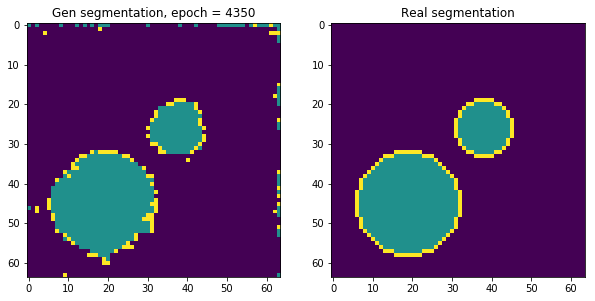

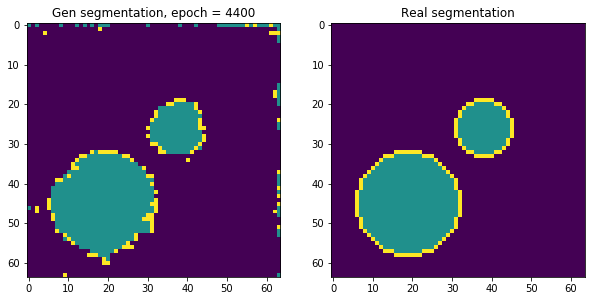

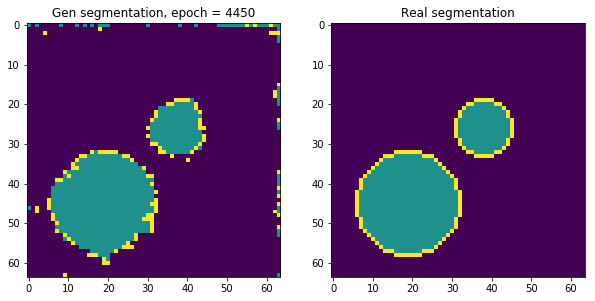

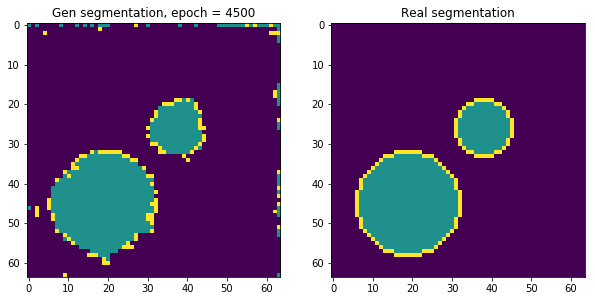

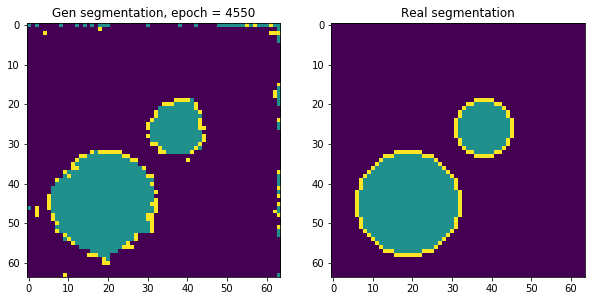

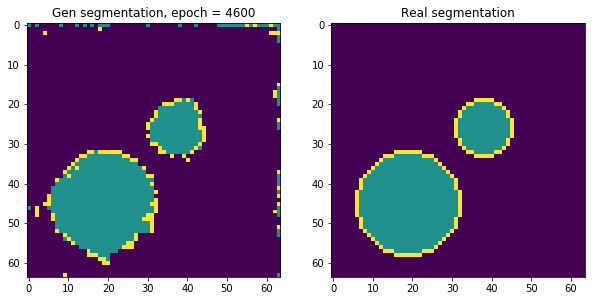

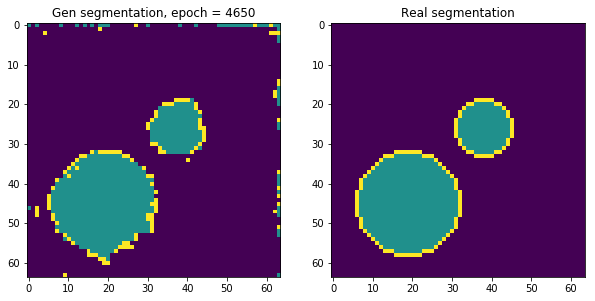

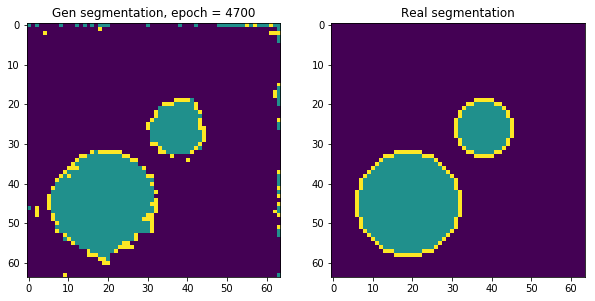

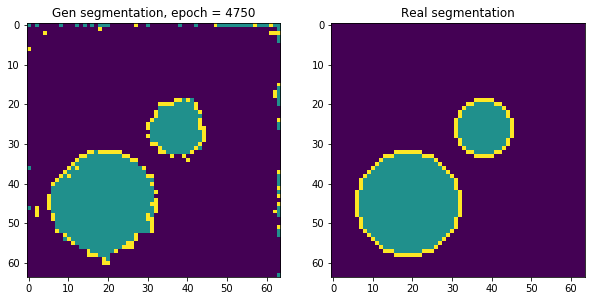

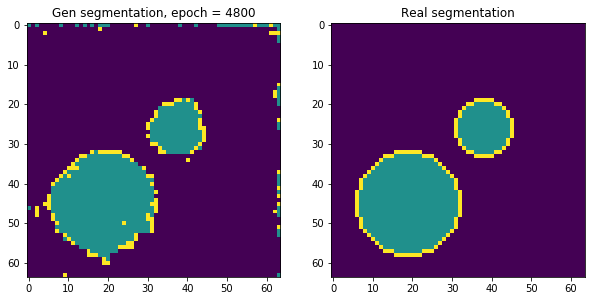

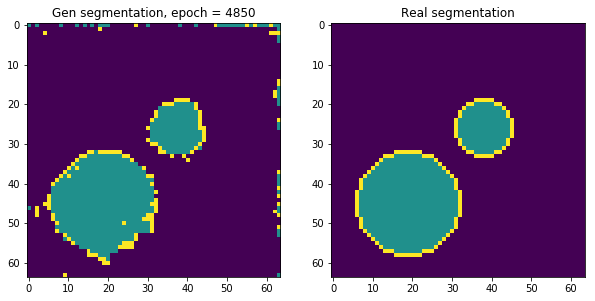

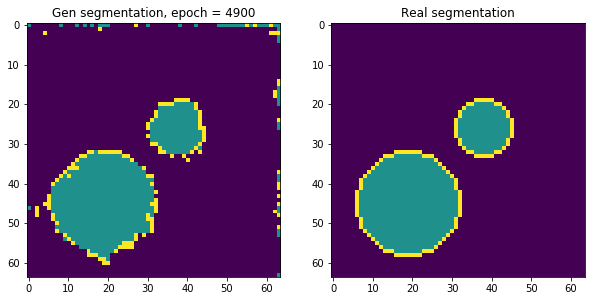

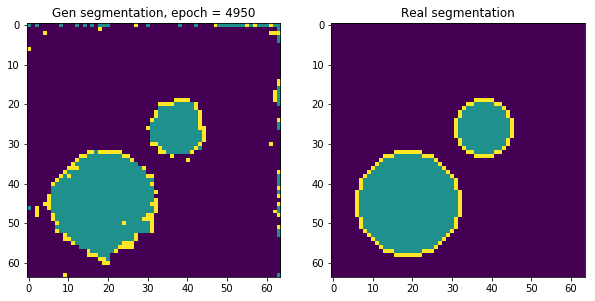

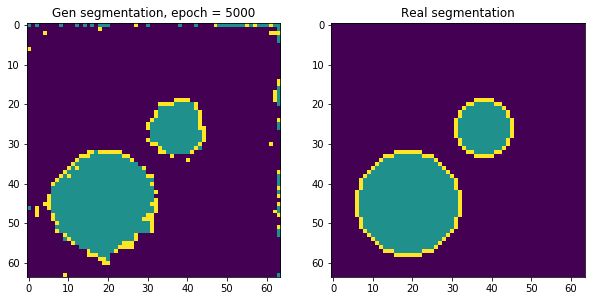

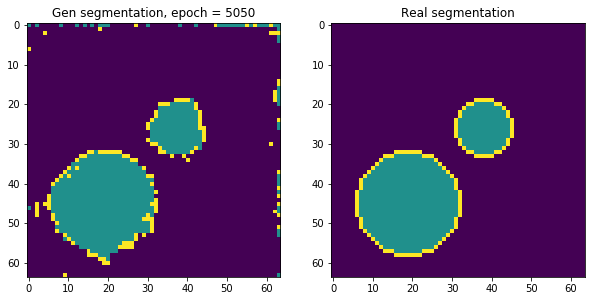

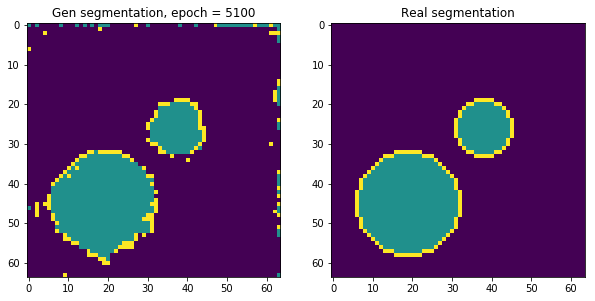

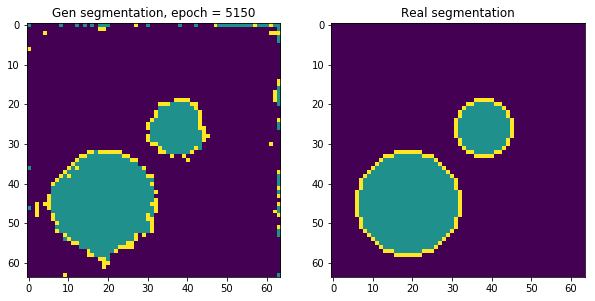

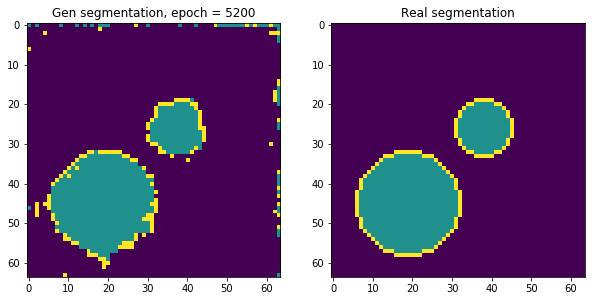

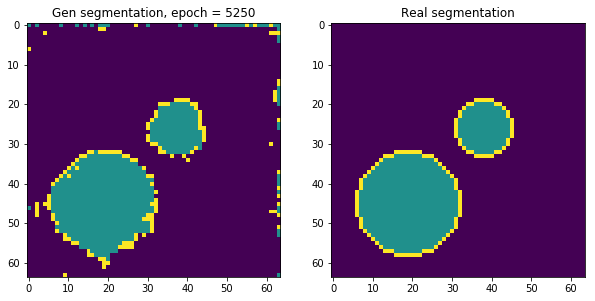

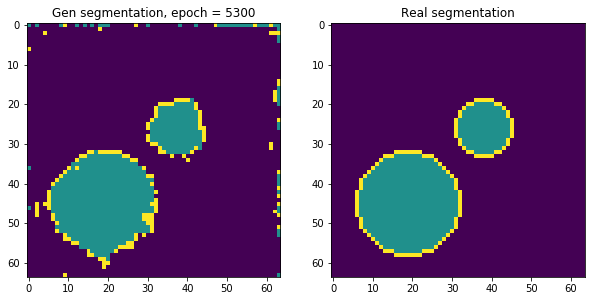

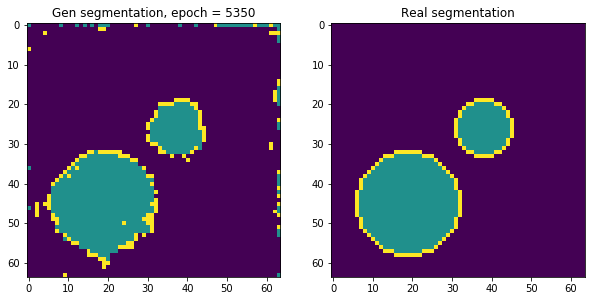

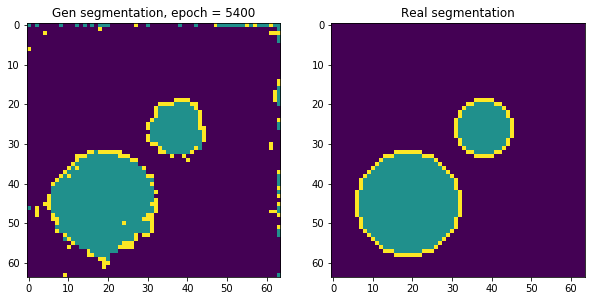

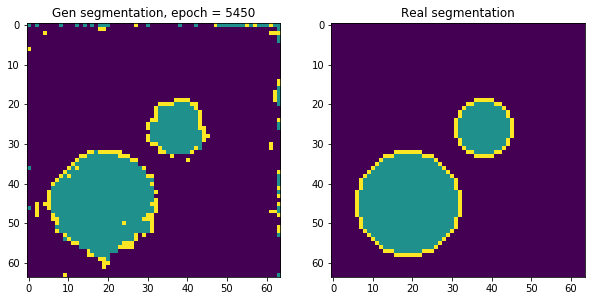

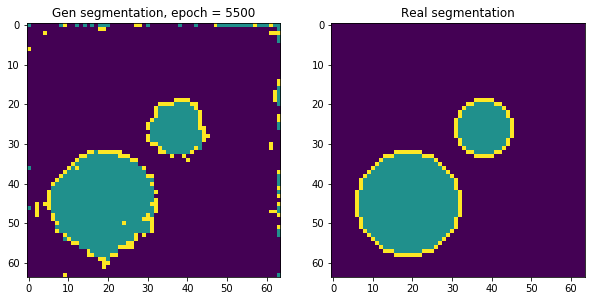

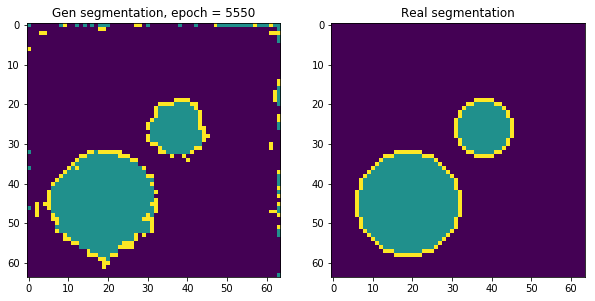

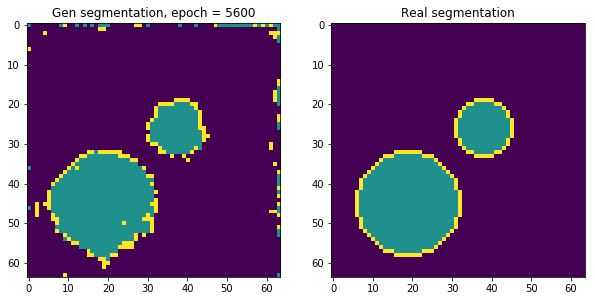

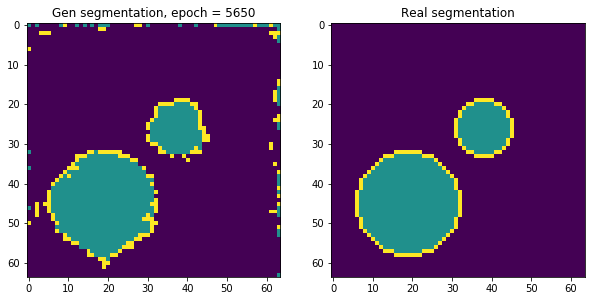

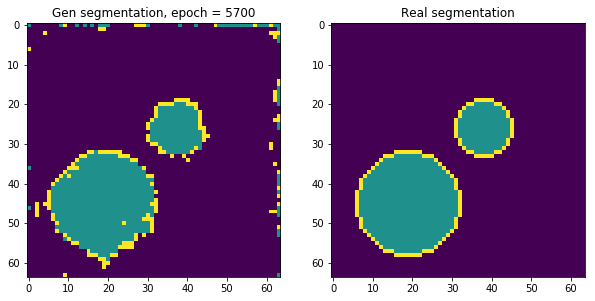

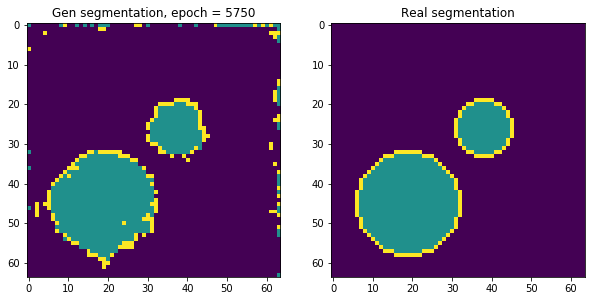

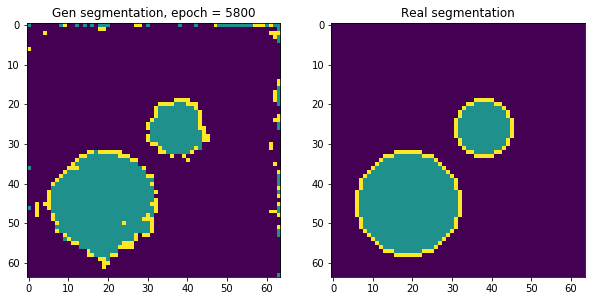

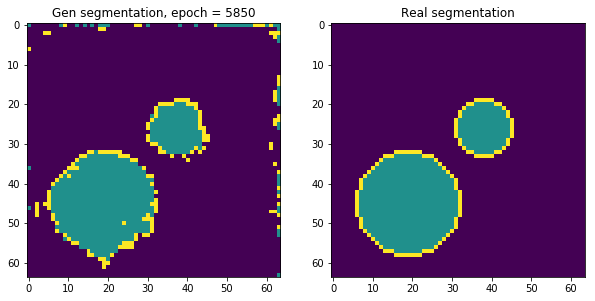

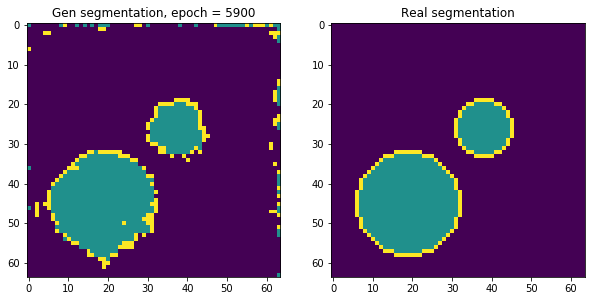

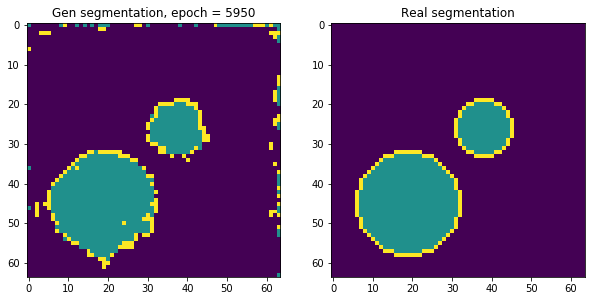

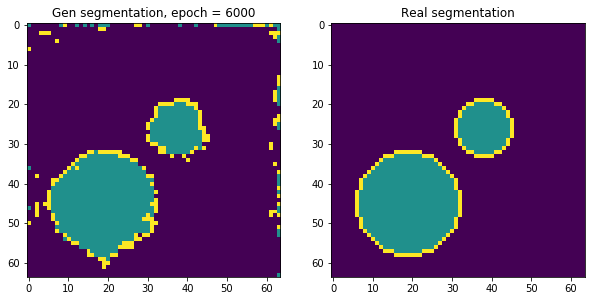

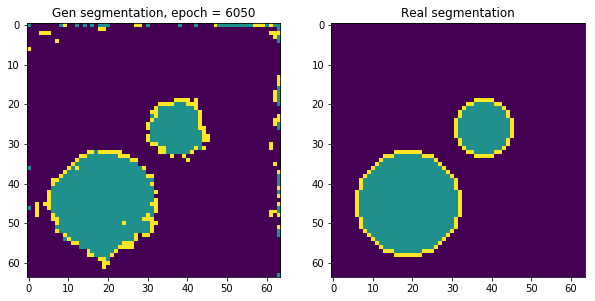

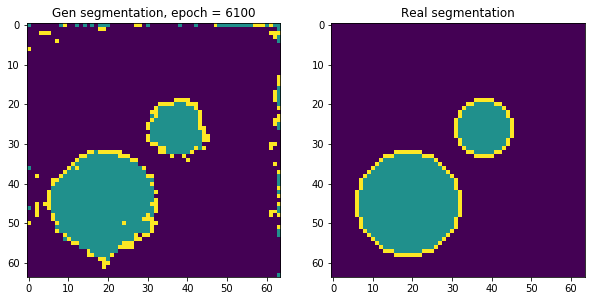

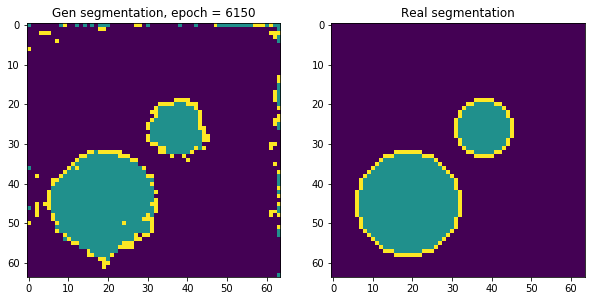

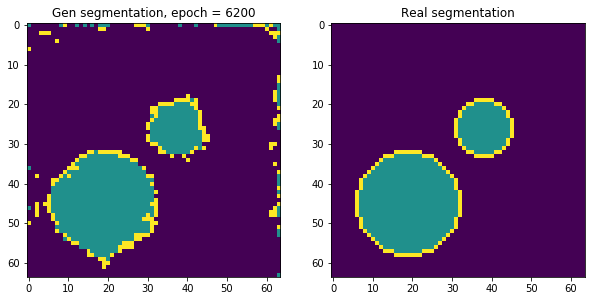

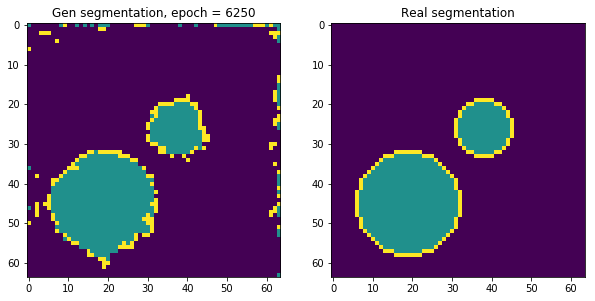

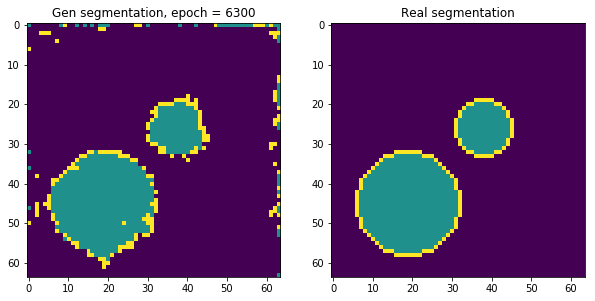

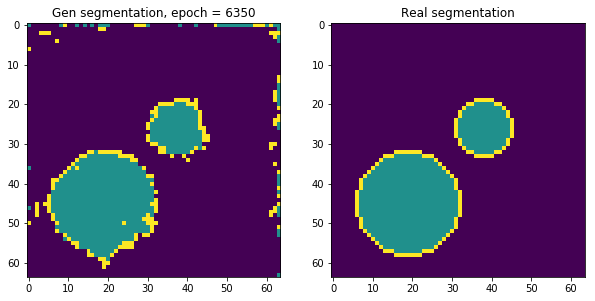

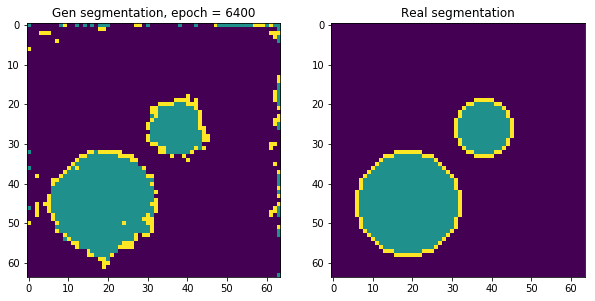

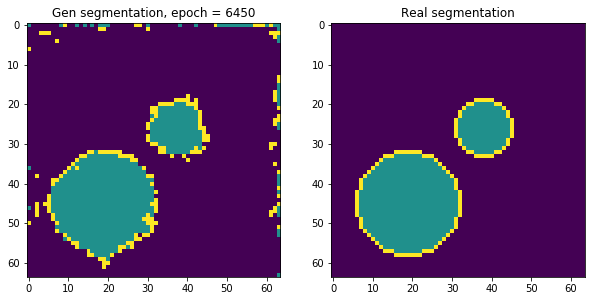

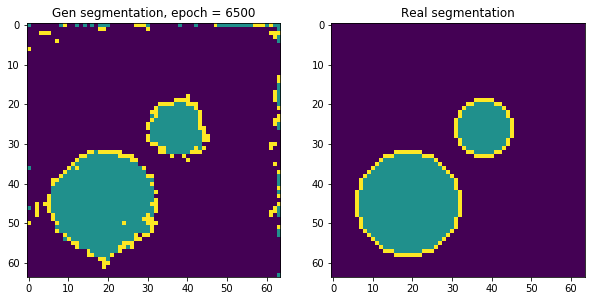

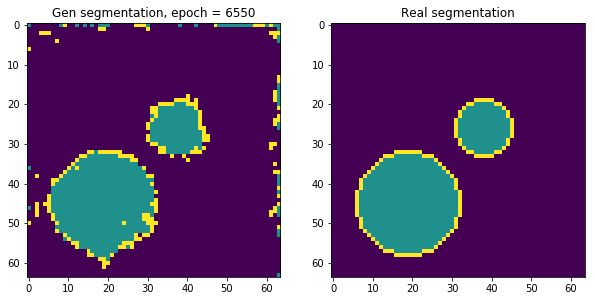

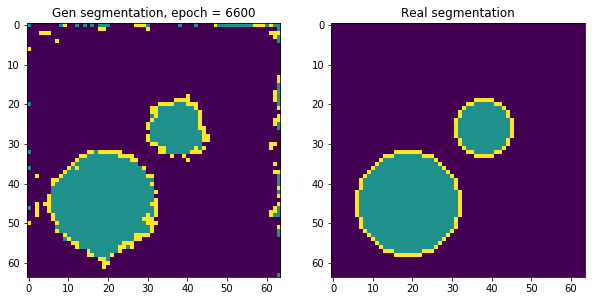

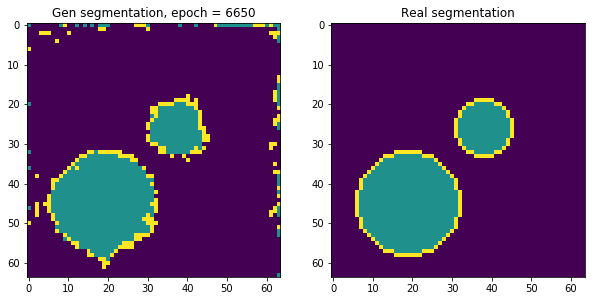

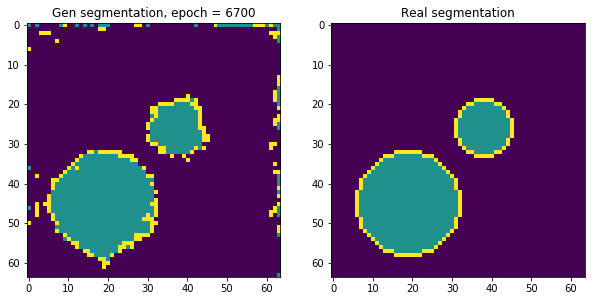

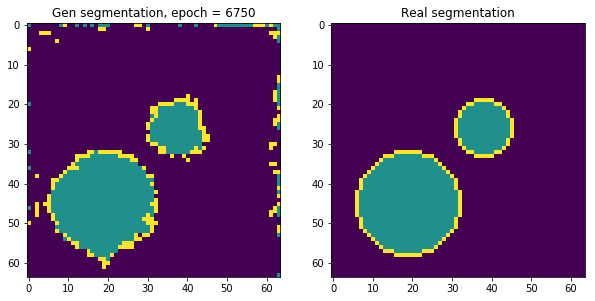

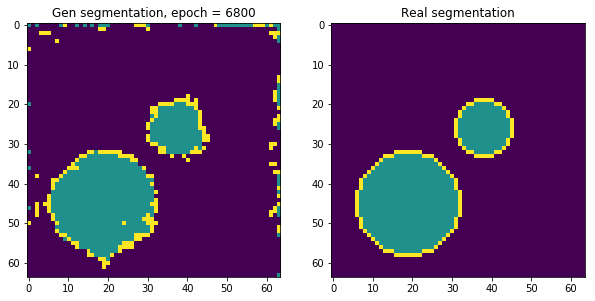

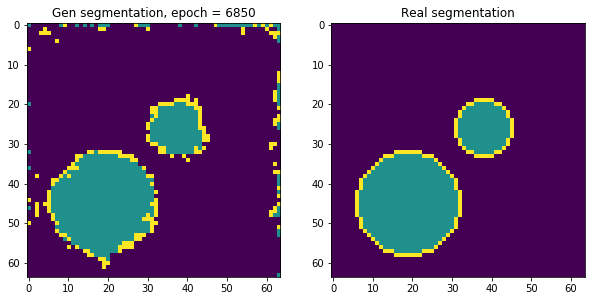

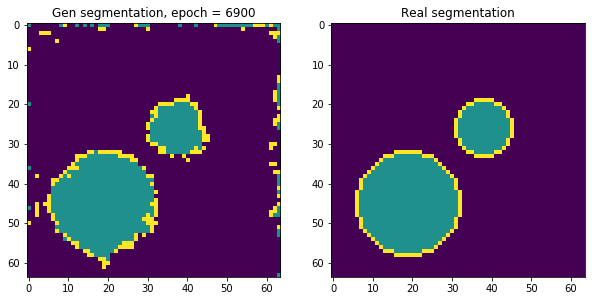

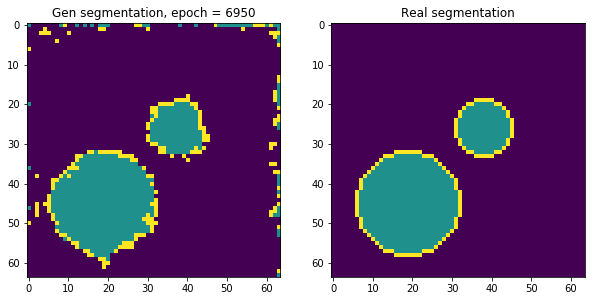

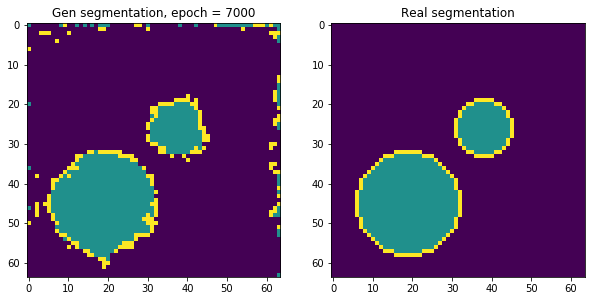

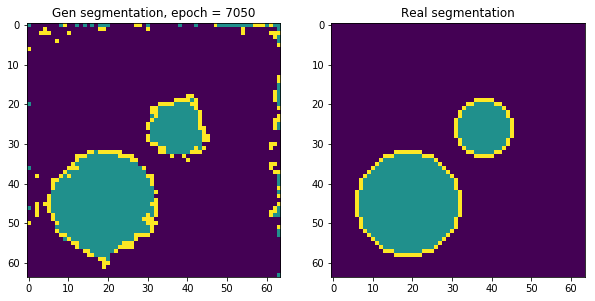

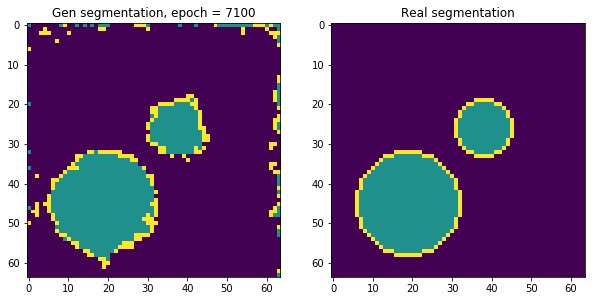

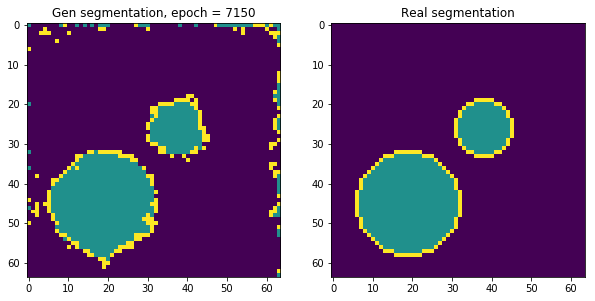

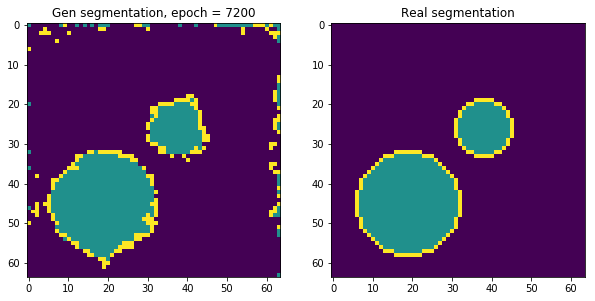

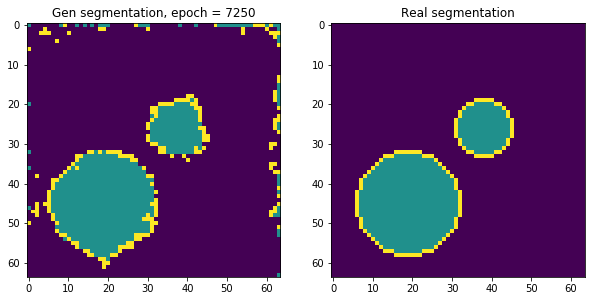

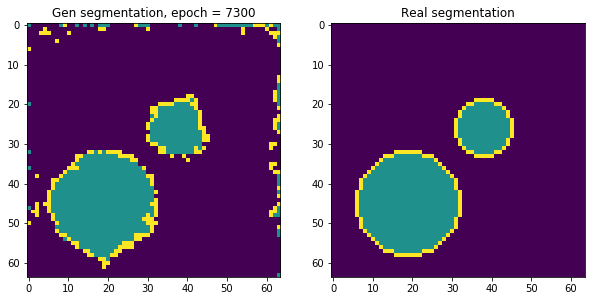

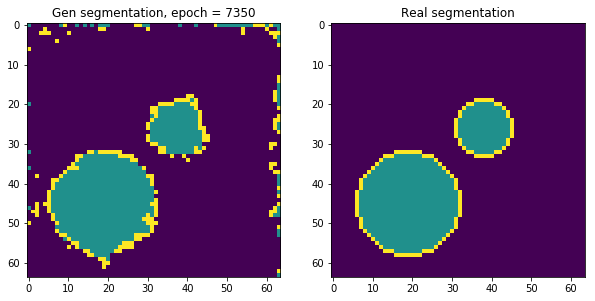

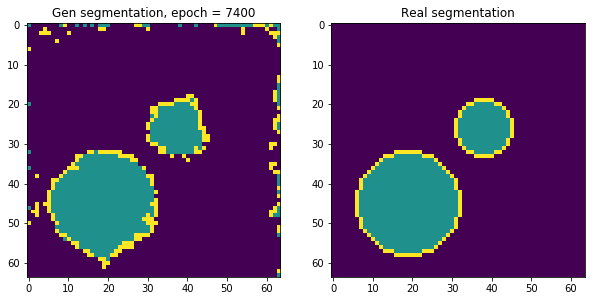

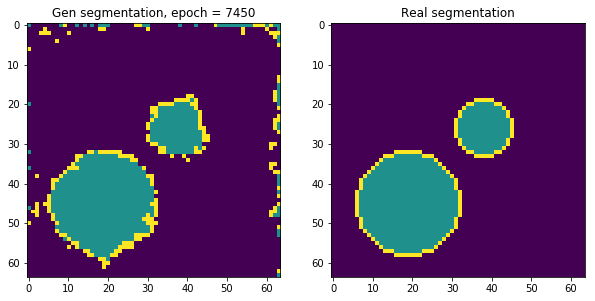

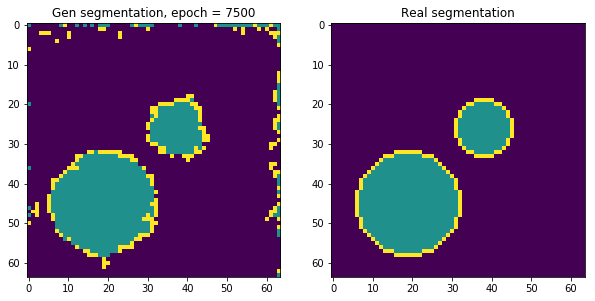

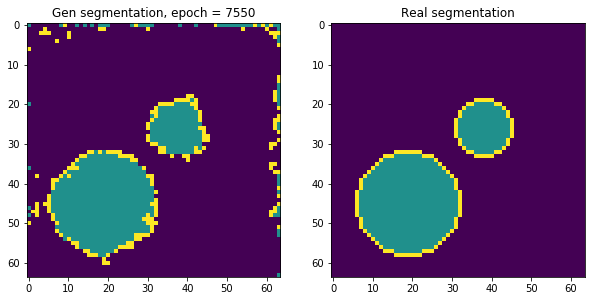

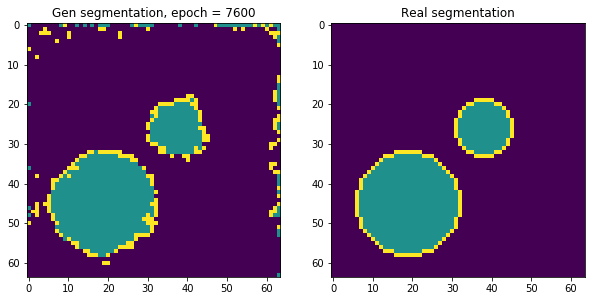

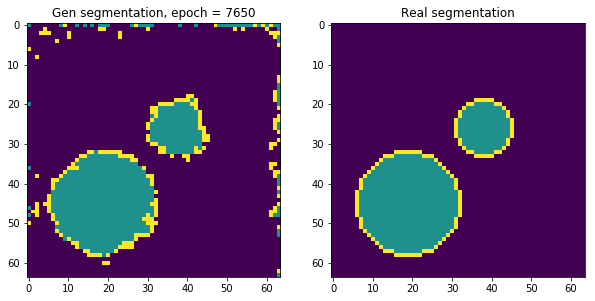

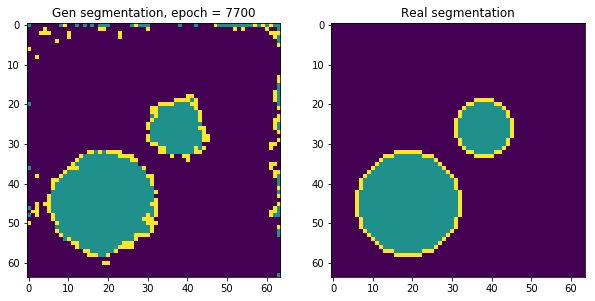

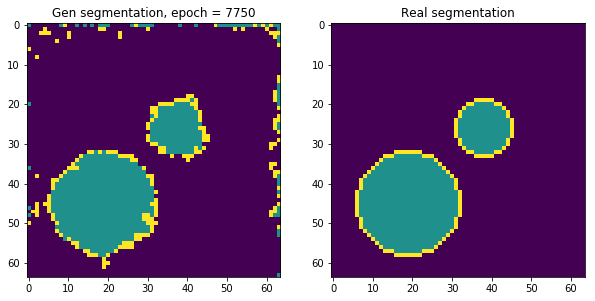

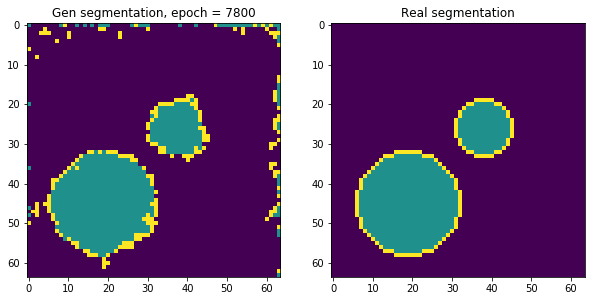

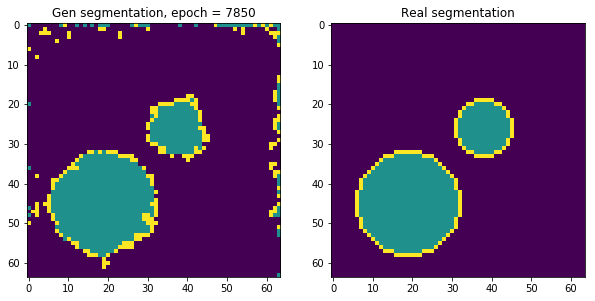

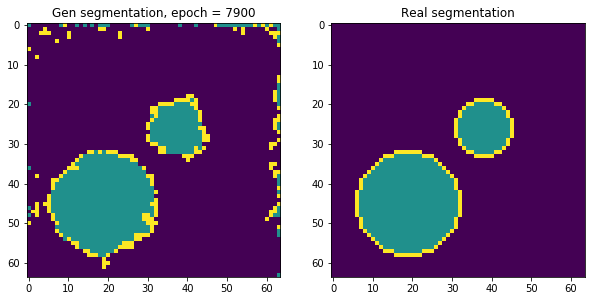

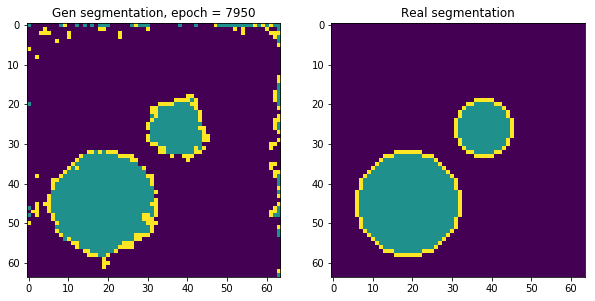

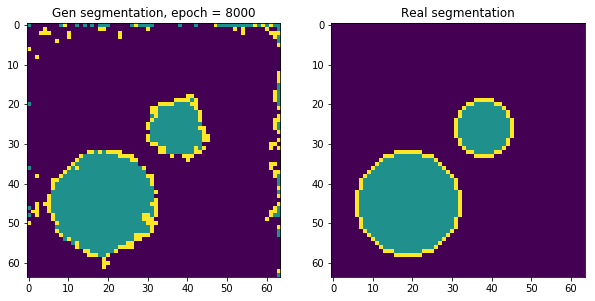

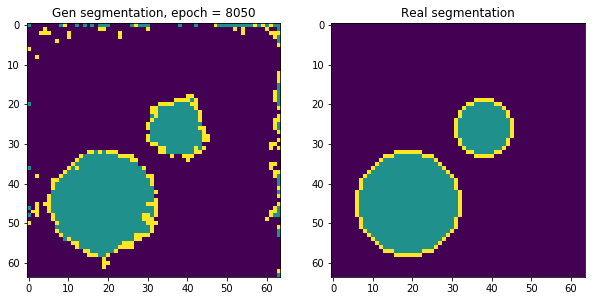

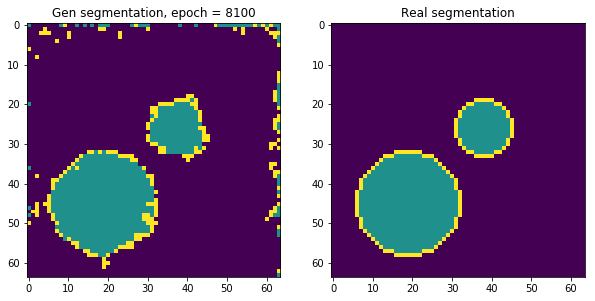

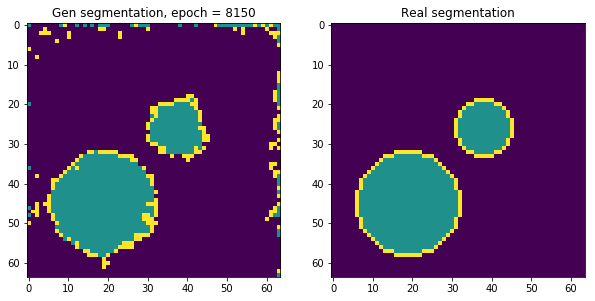

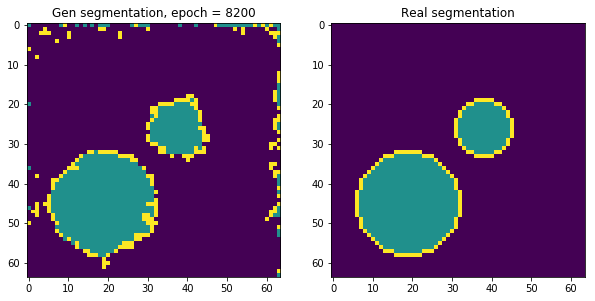

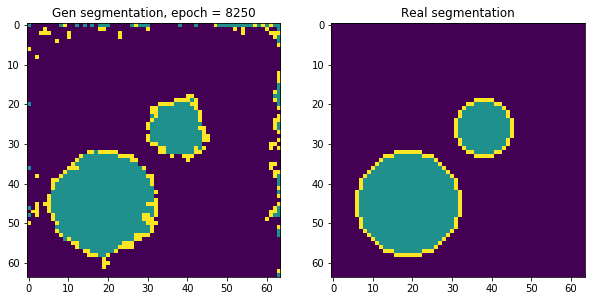

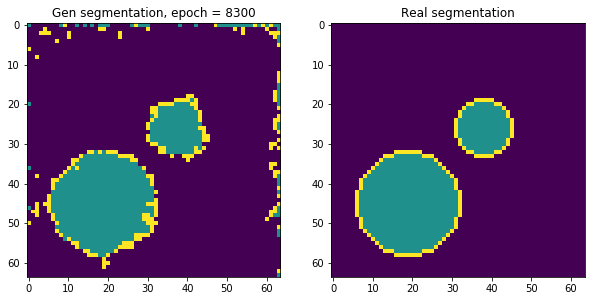

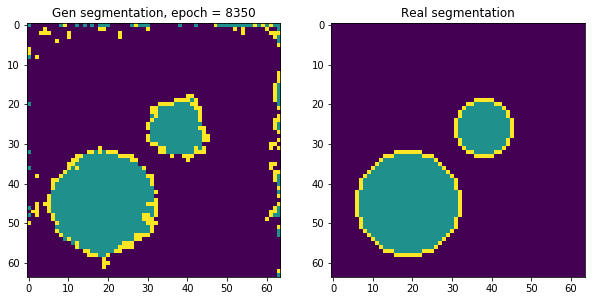

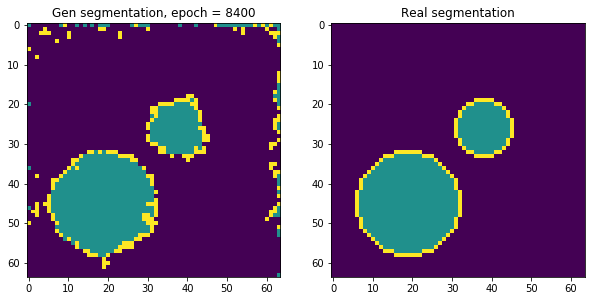

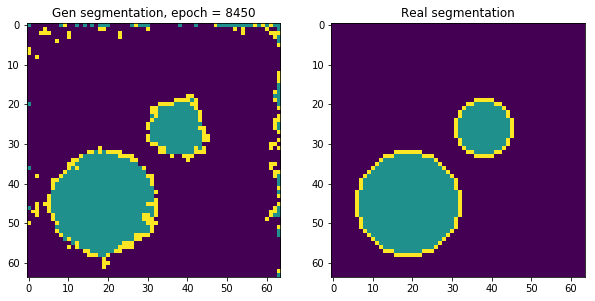

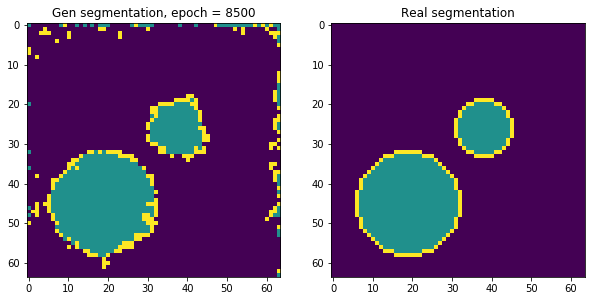

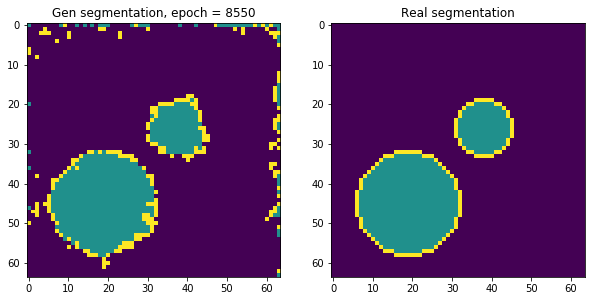

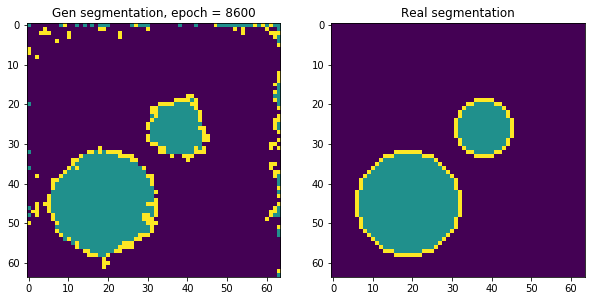

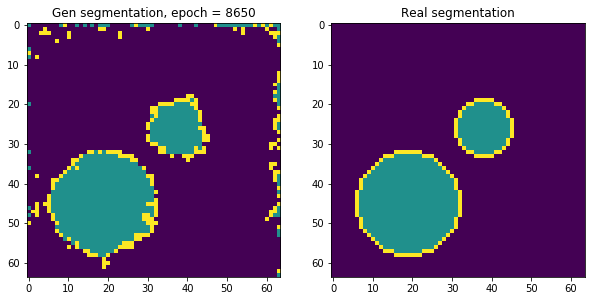

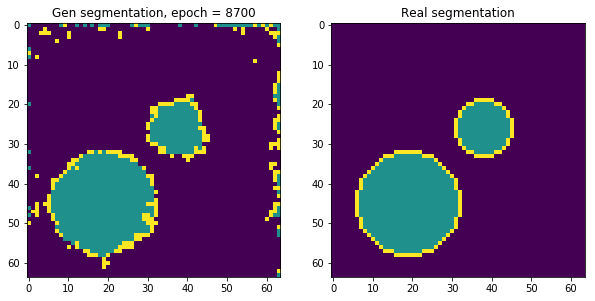

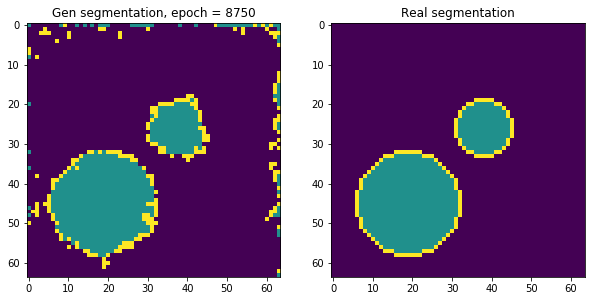

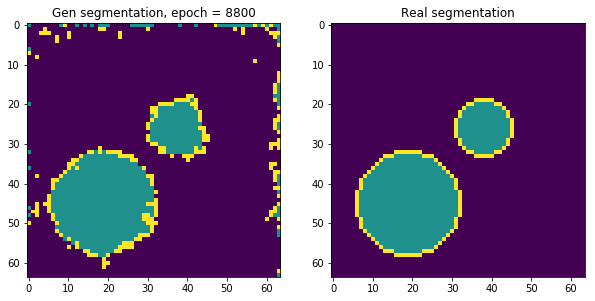

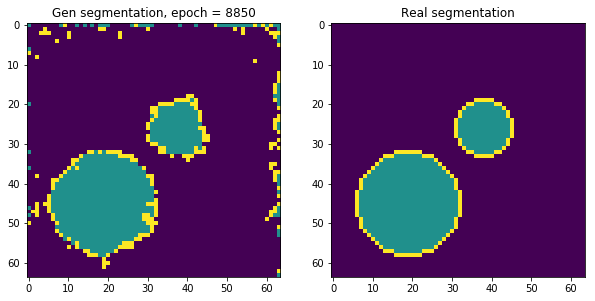

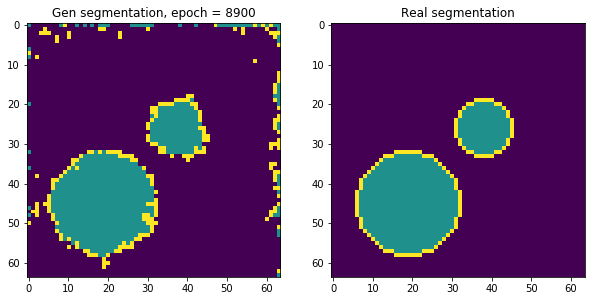

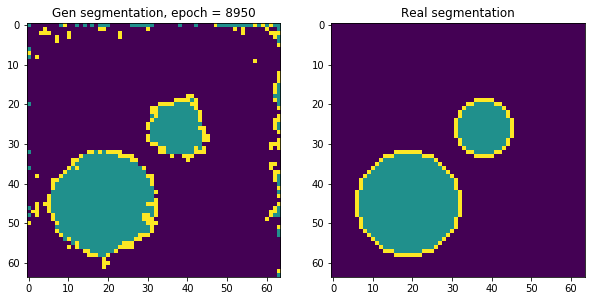

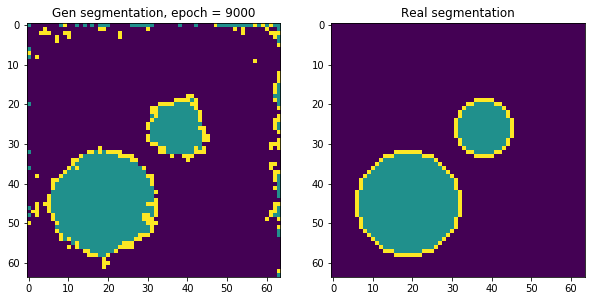

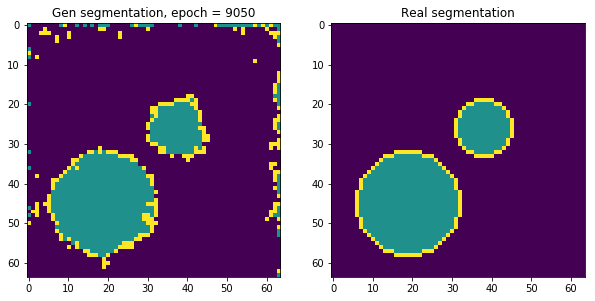

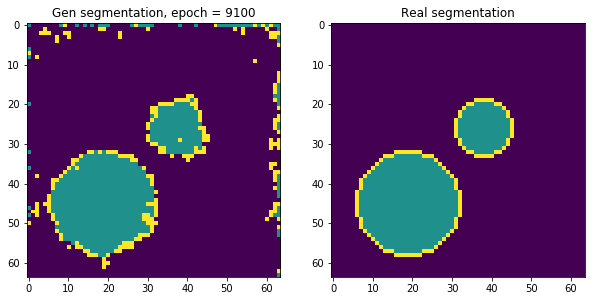

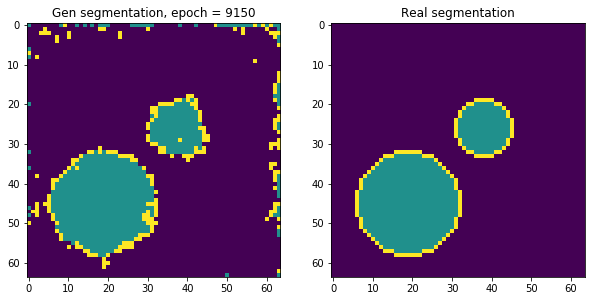

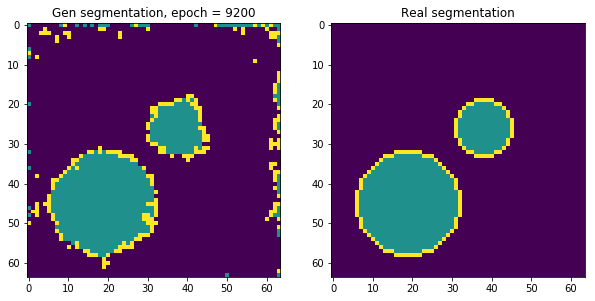

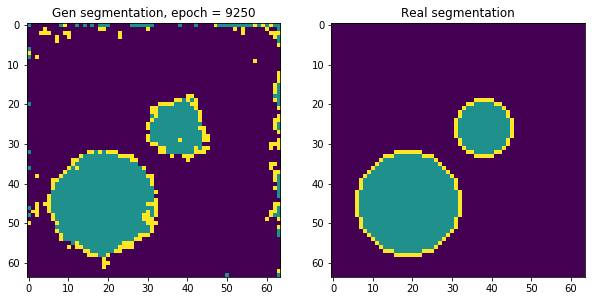

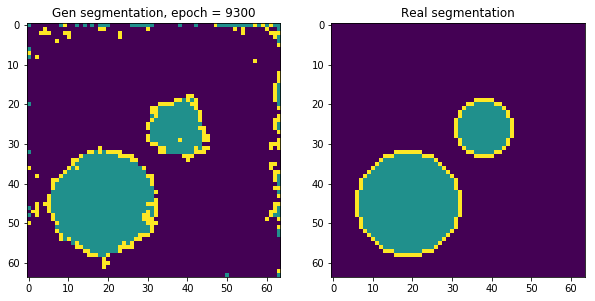

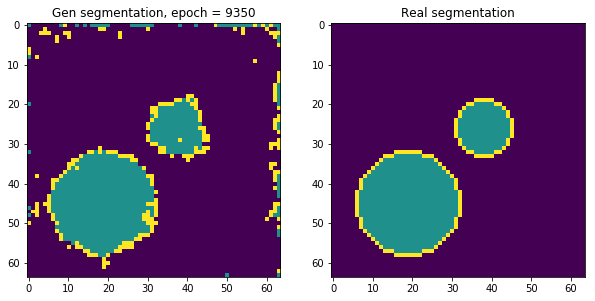

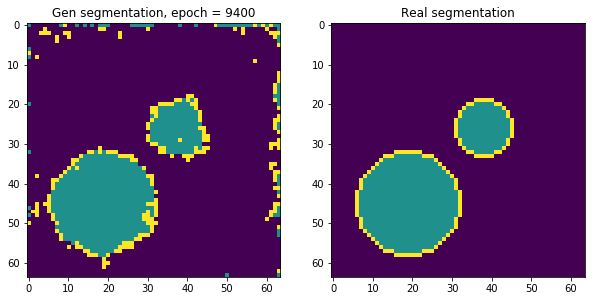

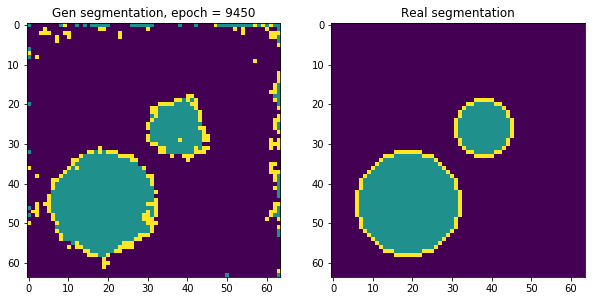

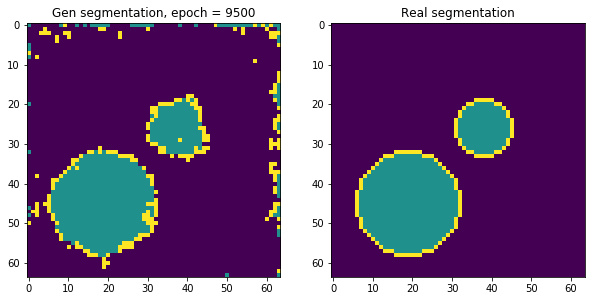

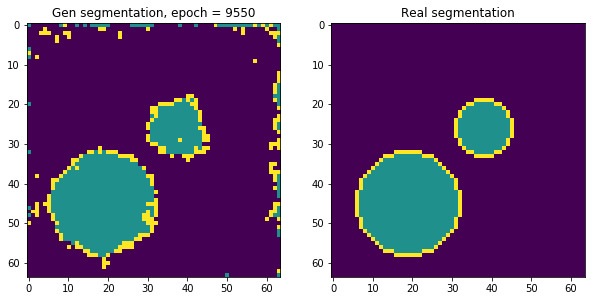

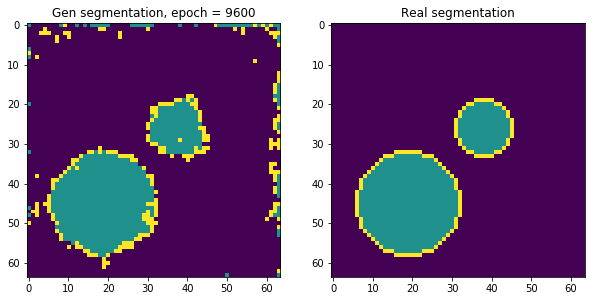

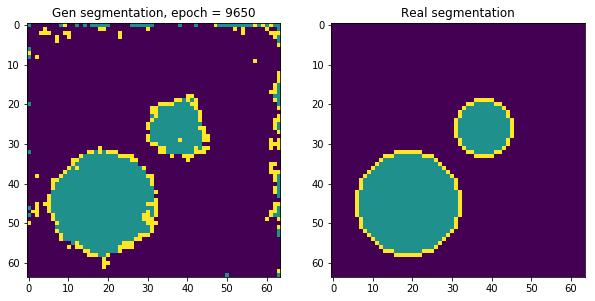

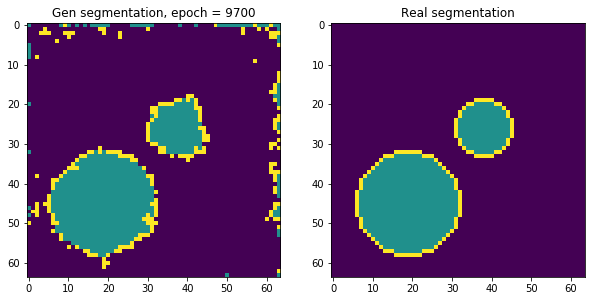

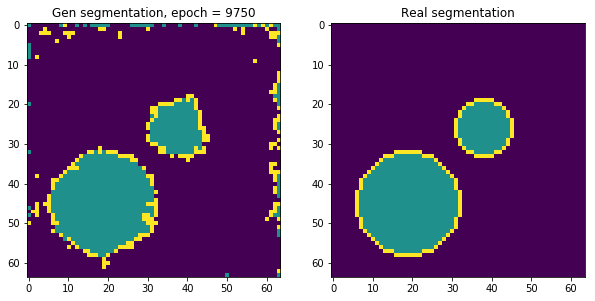

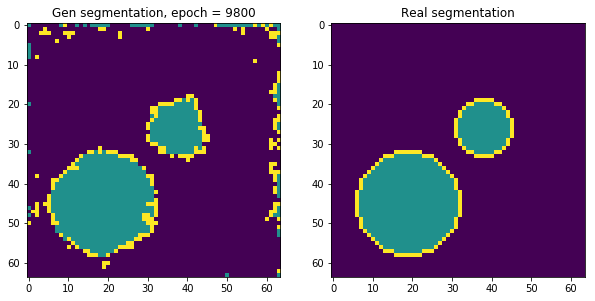

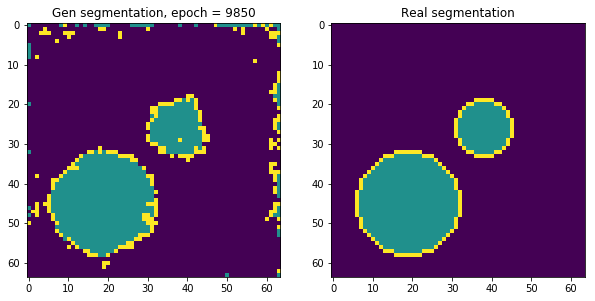

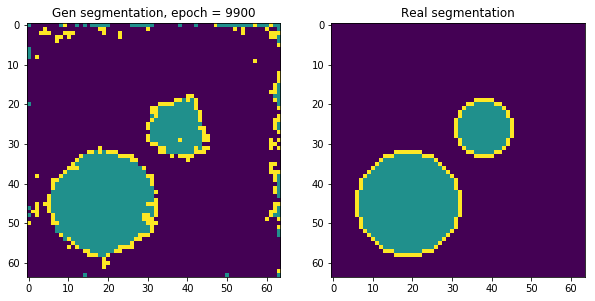

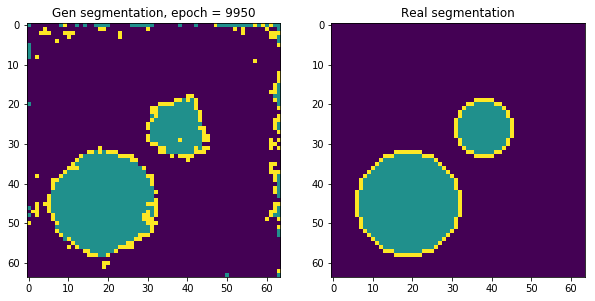

In [16]:
torch.manual_seed(42)
loss_10, loss_100, segm_loss_10, segm_loss_100 = generate_and_train(network_class=Unet)

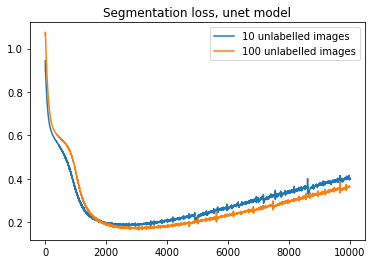

In [17]:
plt.plot(segm_loss_10, label='10 unlabelled images')
plt.plot(segm_loss_100, label='100 unlabelled images')
plt.title('Segmentation loss, unet model')
plt.legend()
plt.show()

### Segmentation loss

In [ ]:
plt.plot(segmentation_loss)
plt.title('Segmentation loss on unlabelled data')
plt.xlabel('# epoch')
plt.show()

In [ ]:
print('iteration with'.format(np.argmin(segmentation_loss)))

In [ ]:
torch.save(net.state_dict(), './model-1000')

### learning

In [ ]:
plt.plot(loss_epoch)
plt.title('loss')
plt.xlabel('# epoch')
plt.show()

In [ ]:
img, segm = net(z_input)

### Results 

In [ ]:
show_image_segm(img.data.numpy(), segm.data.numpy(), 
                train_images.data.numpy(), train_segmentation.data.numpy())

### generate test batch

In [ ]:
test_batch_size = 5

In [ ]:
np.random.seed(42)
test_images, test_segmentation = predata.get_train_batch(test_batch_size)

In [ ]:
test_images = Variable(torch.from_numpy(test_images).float(), requires_grad=False)
test_segm = Variable(torch.from_numpy(test_segmentation), requires_grad=False)

In [ ]:
torch.manual_seed(42)
z_test = Variable(torch.randn(test_batch_size, 3, 64, 64), requires_grad=True)

### Optimizing only latent variable z

In [ ]:
optimizer = optim.Adam([z_test], lr=0.001)

test_loss = []
num_epochs = 1000

for epoch in range(num_epochs):
    normalize_z(z_test)
    optimizer.zero_grad()   
    img, segm = net(z_test)
    loss = 1000 * img_loss(img, test_images)
    loss_epoch.append(loss.data)
    loss.backward()
    optimizer.step()
    print('epoch - {}, loss - {}'.format(epoch, loss.data.numpy()[0]))

normalize_z(z_test)

In [ ]:
test_img, test_segm = net(z_test)

In [ ]:
show_image_segm(test_img.data.numpy(), test_segm.data.numpy(), 
                test_images.data.numpy(), test_segmentation)